# Project 4 - Part 1 Regression Analysis

Gorkem Camli (105709280)

#### Library imports

In [203]:
import pandas as pd
import numpy as np
import random
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoLarsIC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest


from skopt import BayesSearchCV
from skopt.plots import plot_objective, plot_histogram
from skopt.space import Real, Categorical, Integer

import statsmodels.api as sm
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from subprocess import call

import lightgbm as lgb
from catboost import CatBoostRegressor

import joblib
import os.path

import warnings
warnings.filterwarnings('ignore')

In [2]:
 %matplotlib inline 
sns.set_style("whitegrid")

In [3]:
rand_seed = 142
np.random.seed(rand_seed)
random.seed(rand_seed)

#### Dataset Exploration

__Diamonds Data__

In [4]:
diamonds_df = pd.read_csv('diamonds.csv', index_col=0)
print(diamonds_df.shape)
diamonds_df.head()

(53940, 10)


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63
5   0.31     Good     J     SI2   63.3   58.0    338  4.34  4.35  2.75

In [5]:
diamonds_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

__Gas Turbine CO and NOx Emission Data__

In [6]:
repo_name = 'pp_gas_emission/'
file_names= ['gt_2011.csv',
             'gt_2012.csv',
             'gt_2013.csv',
             'gt_2014.csv',
             'gt_2015.csv'
]

gas_partial_dfs = []
for file_name in file_names:
    year = file_name[file_name.find('_')+1: file_name.find('.')]
    year_df = pd.read_csv(repo_name+file_name)
    year_df['year']= year
    gas_partial_dfs.append(year_df)


gas_df = pd.concat(gas_partial_dfs)
gas_df.reset_index(inplace=True, drop=True)
print(gas_df.shape)
gas_df.head()

(36733, 12)


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  year  
0  0.32663  81.952  2011  
1  0.44784  82.377  2011  
2  0.45144  83.776  2011  
3  0.23107  82.505  2011  
4  0.26747  82.028  2011

In [7]:
gas_df.describe()

AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX  
count  36733.000000  
mean      65.293067  
std       11.678357  
min       25.905000  
25%       57.162000  
50%       63.849000  
75%       71.548000  
max      119.910000

In [8]:
gas_df.describe(include=['category','object'])

year
count   36733
unique      5
top      2012
freq     7628

In [9]:
gas_df = gas_df.drop(columns=['CO'])
gas_df.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

      NOX  year  
0  81.952  2011  
1  82.377  2011  
2  83.776  2011  
3  82.505  2011  
4  82.028  2011

## Before Training

### Standardization

#### Question 1

##### __Diamonds Data__

For diamonds data, all the categorical features are quality features, therefore I used Ordinal Encoder to encode them. While encoding the given labels, I specified the ordering from low to high quality for the cut, color, clarity features. For example, for cut categories: Fair gets the lowest label number whereas Ideal got the highest. Later, for both numerical and encoded categorical features, standard scaler is applied. Target variable is kept same.

In [10]:
# get feature names by type
diamonds_num_cols =  diamonds_df.select_dtypes(include=['int64', 'float64']).drop(['price'], axis=1).columns
diamonds_cat_cols = diamonds_df.select_dtypes(include=['object', 'category']).columns

print(diamonds_num_cols)
print(diamonds_cat_cols)

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')
Index(['cut', 'color', 'clarity'], dtype='object')


In [11]:
# create a feature transformer for each type of features
cut_categories = ['Fair', 'Good','Very Good', 'Premium','Ideal']
color_categories = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_categories = ['I1','SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds_categs_order = [cut_categories, color_categories, clarity_categories]
    
def feature_transformer(data, numeric_feats, categ_feats, categs_order, scale=True):
    cat_transformer_ordinal = Pipeline(steps=[('ordinal_enc', OrdinalEncoder(categories=categs_order))])
    data[categ_feats] = cat_transformer_ordinal.fit_transform(data[categ_feats])
    if scale:
        num_transformer = Pipeline(steps=[('std_scaler', StandardScaler())])
        data[list(numeric_feats)+list(categ_feats)] = num_transformer.fit_transform(data[list(numeric_feats)+list(categ_feats)]) 
        
    #preprocessor = ColumnTransformer(transformers= [('num_transformer', num_transformer, numeric_feats),
    #                                               ('cat_transformer', cat_transformer_ordinal, categ_feats)])
    
    return data


In [12]:
print("Raw Diamonds Data")
display(diamonds_df.head(4))
diamonds_prep_df= diamonds_df.copy()
diamonds_prep_df = feature_transformer(data=diamonds_prep_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                categs_order=diamonds_categs_order,
                                                scale=True)
print("Diamonds Data After Standardization and Category Feature Encoding")
diamonds_prep_df.head(4)

Raw Diamonds Data


carat      cut color clarity  depth  table  price     x     y     z
1   0.23    Ideal     E     SI2   61.5   55.0    330  3.95  3.98  2.43
2   0.21  Premium     E     SI1   59.8   61.0    327  3.89  3.84  2.31
3   0.23     Good     E     VS1   56.9   65.0    328  4.05  4.07  2.31
4   0.29  Premium     I     VS2   62.4   58.0    337  4.20  4.23  2.63

Diamonds Data After Standardization and Category Feature Encoding


carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   

          x         y         z  
1 -1.587837 -1.536196 -1.571129  
2 -1.641325 -1.658774 -1.741175  
3 -1.498691 -1.457395 -1.741175  
4 -1.364971 -1.317305 -1.287720

In [13]:
print('Description of Diamonds data after standardization')
diamonds_prep_df.describe()

Description of Diamonds data after standardization


carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

In [14]:
diamonds_unscaled_df = diamonds_df.copy()
diamonds_unscaled_df = feature_transformer(data=diamonds_unscaled_df, 
                                                numeric_feats=diamonds_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                categs_order=diamonds_categs_order,
                                                scale=False)
#diamonds_unscaled_df.describe()

##### __Gas Data__

For gas data, I dropped the CO column and will use NOX as the target variable.
Only categorical feature is year. It is considered as an ordered feature, we could use ordinal encoder for it. It is also possible to use one-hot-encoding.
I used Ordinal Encoder to encode them. While encoding, I specified the ordering from low to high. Later, for both numerical and encoded categorical features, standard scaler is applied. Target variable is kept same (NOX).

In [15]:
# get feature names by type
gas_num_cols =  gas_df.select_dtypes(include=['int64', 'float64']).drop(['NOX'], axis=1).columns
gas_cat_cols = gas_df.select_dtypes(include=['object', 'category']).columns

print(gas_num_cols)
print(gas_cat_cols)

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP'], dtype='object')
Index(['year'], dtype='object')


In [16]:
print('years: ',gas_df['year'].unique())

years:  ['2011' '2012' '2013' '2014' '2015']


In [17]:
print("Raw Gas Data")
display(gas_df.head(4))
gas_prep_df= gas_df.copy()
year_categories = gas_df['year'].unique()
gas_prep_df = feature_transformer(data=gas_prep_df, 
                                numeric_feats=gas_num_cols, 
                                categ_feats=gas_cat_cols,
                                categs_order=[year_categories],
                                scale=True)
print("Gas Data After Standardization and Category Feature Encoding")
gas_prep_df.head(4)

Raw Gas Data


AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   

      NOX  year  
0  81.952  2011  
1  82.377  2011  
2  83.776  2011  
3  82.505  2011

Gas Data After Standardization and Category Feature Encoding


AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.762362  0.871052  0.401627 -0.451875 -0.377702  0.272119  0.536589   
1 -1.801920  0.809164  0.440351 -0.458207 -0.384376  0.266417  0.568742   
2 -1.854113  0.824636  0.483432 -0.442831 -0.375081  0.289227  0.589203   
3 -1.875718  0.809164  0.523263 -0.445415 -0.393909  0.289227  0.586280   

        TEY       CDP     NOX      year  
0  0.074502 -0.149273  81.952 -1.399443  
1  0.074502 -0.154783  82.377 -1.399443  
2  0.102033 -0.017015  83.776 -1.399443  
3  0.097551 -0.064774  82.505 -1.399443

In [18]:
print('Description of Gas data after standardization')
gas_prep_df.describe()

Description of Gas data after standardization


AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.176081e-16 -1.233647e-14 -5.942306e-16 -1.015144e-15  5.230467e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP           NOX  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  36733.000000   
mean   9.609823e-15 -8.300659e-15  9.888369e-16 -4.673376e-16     65.293067   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00     11.678357   
min   -4.597825e+00 -5.132585e+00 -2.144032e+00 -2.028623e+00     25.905000   
25%   -5.490425e-01 -2.102398e-01 -5.798539e-01 -5.745191e-01     57.162000   
50%    2.550115e-01  5.438962e-01  1.431620e-02 -8.773591e-02     63.849000   
75%    8.879903e-01  5.672802e-01  6.769952e-01  7.296924e-01     71.548000   
max    1.110388e+00  6.505859e-01  2.944830e+00  2.845821e+00    119.910000   

               year  
count  3.673300e+04  
mean  -7.427883e-17  
std    1.000014e+00  
min   -1.399443e+00  
25%   -6.946951e-01  
50%    1.005331e-02  
75%    7.148017e-01  
max    1.419550e+00

In [19]:
gas_unscaled_df = gas_df.copy()
gas_unscaled_df = feature_transformer(data=gas_unscaled_df, 
                                        numeric_feats=gas_num_cols, 
                                        categ_feats=gas_cat_cols,
                                        categs_order=[year_categories],
                                        scale=False)


### todo also try one hot encoding

I could have also standardized the target variables.The advantage of standardizing the target variables are especially when training models such as NN. Having very large range of target variables can make it difficult to adapt and assign weights to predict the results. This is because larger target results require larger weights. 

### Profiling Results

Pandas profiling is used to explore the dataset for both diamonds and gas dataset. The results can be seen below:

In [20]:
#profile_diamonds = ProfileReport(diamonds_df)
#profile_diamonds

In [21]:
#profile_gas = ProfileReport(gas_df)
#profile_gas

### Data Inspection

To further understand the data I did fata inspection and answered the following questions:

#### Question 2

Pearson Correlation Heatmap:


For Pearson correlation the values are between -1 to 1. Values closer -1 means strong negative correlation, values closer 1 means strong positive correlation and values closer to 0 means low correlation. High correlation means there is a strong linear relationship between two variables. If it is closer to 1, means increasing one variable we expect increase in the other. If the value is closer to -1, high negative correlation, increasing one variable will result in the decrease of the other variable. Having a value close to 0 means that there is no strong linear relation betweeen the two variables, changing one doesn't have a clear effect on the other as a direct increase or decrease. Having a pearson correlation 0 or close to 0 doesn't mean there is no relationship between the two, a nonlinear relationship may exist, it is just that we cannot tell nonlinear relationship by just looking Pearson correlation. 

For both datasets heatmap with pearson correlation is plotted:

In [22]:
def heat_map(data_df, data_name=''):
    plt.figure(figsize=(10,10))
    corr = data_df.corr(method='pearson')
    sns.heatmap(corr, annot=True, linewidths=1)
    plt.title(data_name+' Heatmap ')
    plt.show()

__Diamonds Data:__

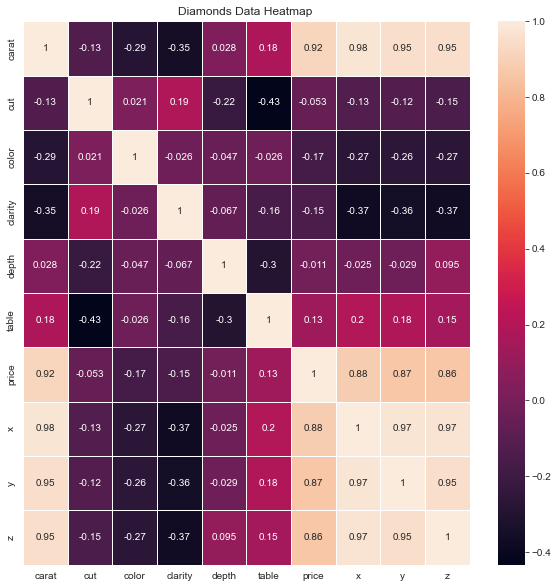

In [23]:
heat_map(data_df=diamonds_prep_df, data_name='Diamonds Data')

In the diamonds data Pearson Correlation heatmap, we see high correlation on carat,x, y, z and price columns. The pearson correlation values between price and carat is 0.92, x=0.88, y=0.87 and z=0.86. Carat seems to be the most important feature to tell the diamond price. The high correlation suggest carat, x, y, z values are the most predictive features for predicting the price of a diamond. The pearson correlation for these features are positive for target variable price. This means there is a positive relationship between these variables and price, hence the increasing any of these 4 features will lead the diamond price to be higher. These makes sense in the real world as well since the bigger diamonds (dimensions x,y,z) and/or carat (weight) are generally more expensive.


__Gas Data:__

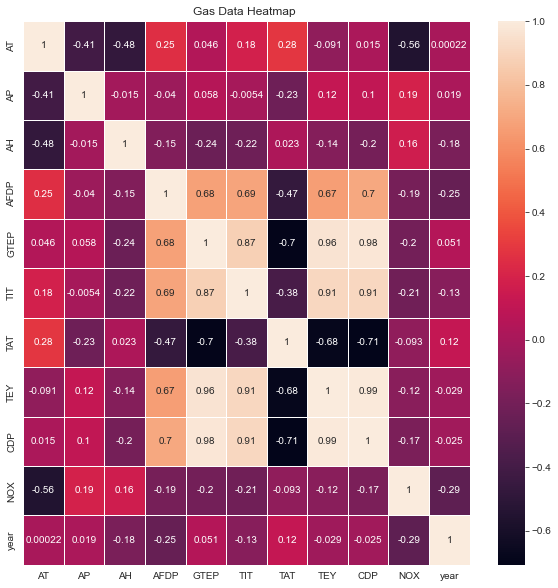

In [24]:
heat_map(data_df=gas_prep_df, data_name='Gas Data')

In the gas data Pearson Correlation heatmap, we see negative high correlation on AT column with our target variable NOX. This tells increasing AT tend to lowers NOX values. But rest of the variables don't seem very correlated with the NOX variable. This tells that we might have a hard time to have good results for the predictions (at least for the linear models).

What is interesting though other features seem to be correlated with each other, TAT, TEY, CDP and GTEP looks like very correlated with each other. TAT has high negative correlation with TEY, CDP and GTEP. GTEP correlation with TEY and CDP is very high and positive around 0.96, 0.98. The relations are same betweeen these 3 variables, this means we can drop 2 of them and only keep one, otherwise our models would put more emphasis on these data in order to predict the results. 

#### Question 3

Histogram of the numerical features for each dataset can be seen below:

In [25]:
def histogram_num_features(data, num_feats, data_name, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Numerical Features Histogram')
    for num_feat, ax_ind in zip(num_feats, ax.ravel()):
        sns.histplot(data, x=num_feat, ax=ax_ind)
        ax_ind.set_title(f'{num_feat} Histogram')
    plt.show()


##### __Diamond Dataset:__

In [26]:
#histogram_num_features(data=diamonds_prep_df,num_feats=diamonds_num_cols, data_name='Diamonds Data', 
#                       num_rows=3, num_cols=2, fig_size=(20,20))

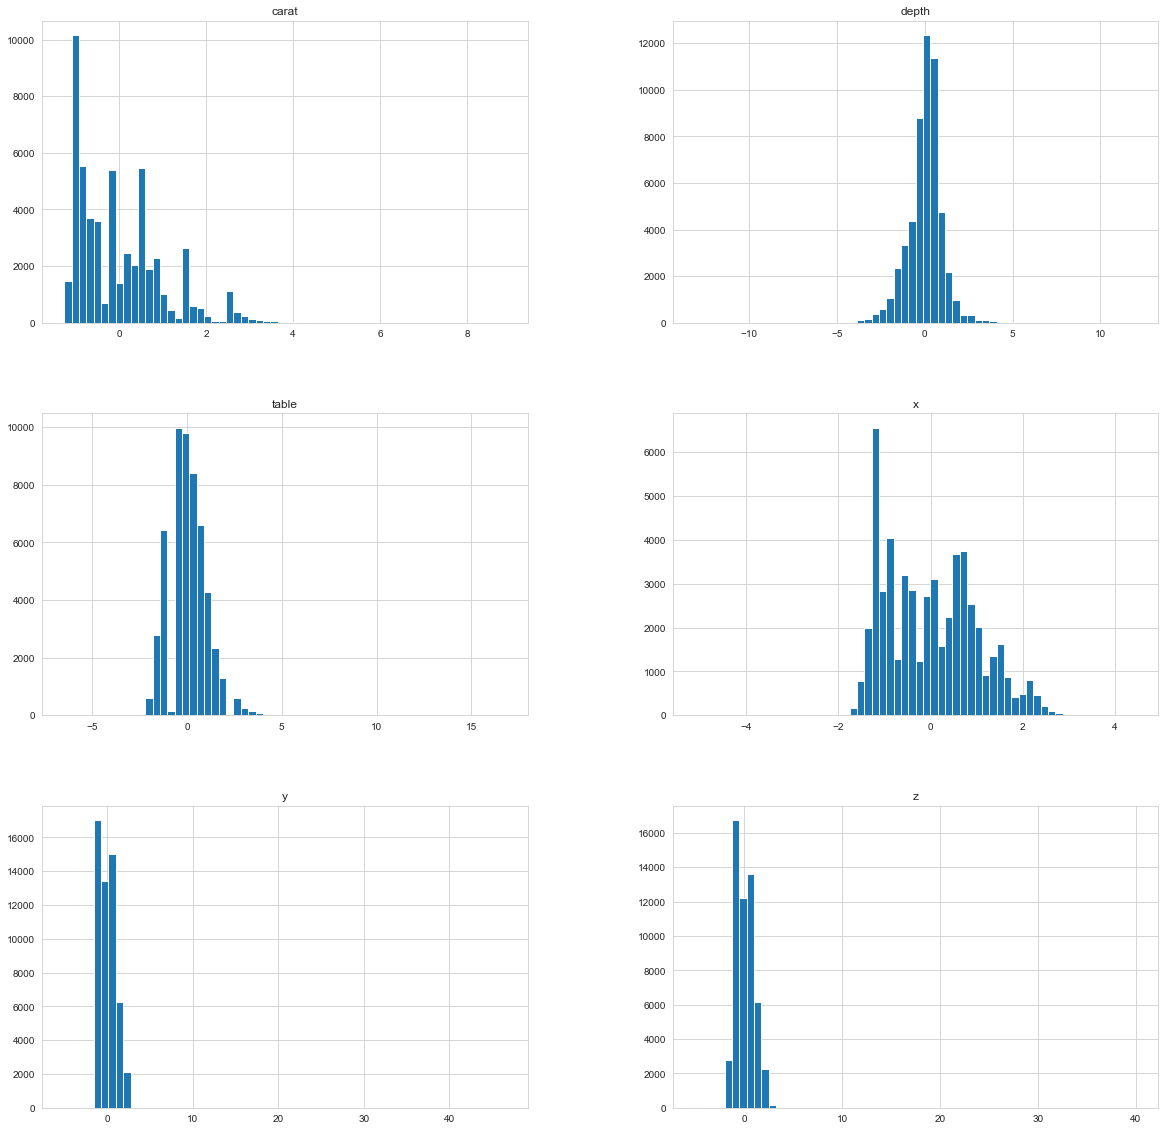

In [27]:
diamonds_prep_df[diamonds_num_cols].hist(figsize=(20, 20), bins=60)
plt.show()

In [28]:
diamonds_prep_df.describe()

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04  
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16  
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00  
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00  
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01  
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02  
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01  
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01

__Diamond Data:__

Carat and x features' histogram seems to be right skewed. Y and z plots have few outliers around 40 and they don't seem to follow gaussian distribution. Depth and table seems to be close to normal distribution.
 

##### __Gas Dataset:__

In [29]:
#histogram_num_features(data=gas_prep_df,num_feats=gas_num_cols, data_name='Gas Data', 
#                       num_rows=5, num_cols=2, fig_size=(20,20))

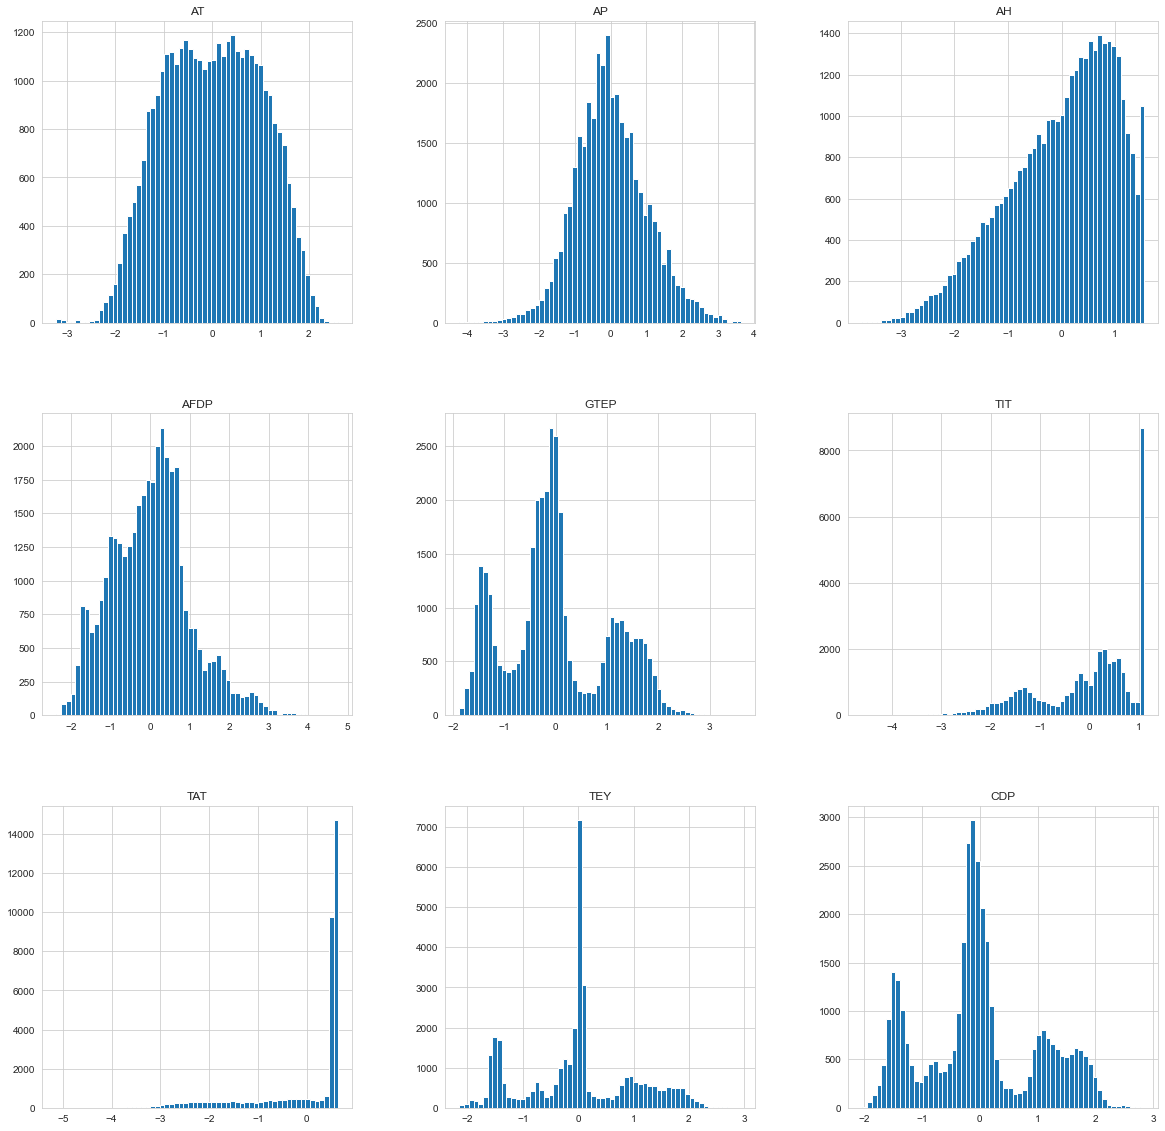

In [30]:
gas_prep_df[gas_num_cols].hist(figsize=(20, 20), bins=60)
plt.show()

In [31]:
gas_prep_df.describe()

AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.176081e-16 -1.233647e-14 -5.942306e-16 -1.015144e-15  5.230467e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP           NOX  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  36733.000000   
mean   9.609823e-15 -8.300659e-15  9.888369e-16 -4.673376e-16     65.293067   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00     11.678357   
min   -4.597825e+00 -5.132585e+00 -2.144032e+00 -2.028623e+00     25.905000   
25%   -5.490425e-01 -2.102398e-01 -5.798539e-01 -5.745191e-01     57.162000   
50%    2.550115e-01  5.438962e-01  1.431620e-02 -8.773591e-02     63.849000   
75%    8.879903e-01  5.672802e-01  6.769952e-01  7.296924e-01     71.548000   
max    1.110388e+00  6.505859e-01  2.944830e+00  2.845821e+00    119.910000   

               year  
count  3.673300e+04  
mean  -7.427883e-17  
std    1.000014e+00  
min   -1.399443e+00  
25%   -6.946951e-01  
50%    1.005331e-02  
75%    7.148017e-01  
max    1.419550e+00

__Gas Data:__

AT, AP features seem to have close distributions to normal distributions.
AH, AFDP are left skewed, CO is right skewed and features such as  GTEP, TEY, CDP are tri-modal dsitributions.
 

__What preprocessing can be done if the distribution of a feature has high skewness?__

There are different ways to handle high skewed data and reduce its skewness:

1- Log Transform (natural log)   
2- Square root transform    
2- Box-Cox transformation   

There are different transformation possibilities to address the skewness of the data, and it is difficult to determine which one needs to be applied. This generally depends highly on the current doistribution of the data. Box-Cox transformation is a family of transformations where you select $\lambda$ value typically from -5 to 5. Optimal $\lambda$ is chosen based on the data where its transformation is the best approximation of a normally distributed curve. The transformation of data y is simply $y_\text{transformed} = y^\lambda$. 

 $\lambda=0$ corresponds to the natural log of the data.    
 $\lambda=0.5$ corresponds to the square root transform of the data.
 
 Hence, the first two approach is also contained within the Box-Cox transformation family.
 
 By applying Box-Cox Transformation one can decrese the high skewness and make the data distribution closer to normal distribution.

#### Question 4

Box plot of categorical features in each dataset against target variable. For each dataset I plotted two boxplots one with fliers and the other one without fliers (showfliers=False to not show outliers). I added the plots without fliers as I noticed that there are extreme values that stretch the plots too much and makes the boxplots compact, by not showing outliers, I can zoom in the boxplot itself to visually better see the differences between category values. 

In [32]:
def boxplot_cat_features(data, cat_feats, target_feature, categs_order, data_name, num_rows, num_cols, fig_size, showfliers=True):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Categorical Features Boxplot against target variable ({target_feature})')
    if num_rows == 1 and num_cols==1:
        ax_s = [ax]
    else:
        ax_s = ax.ravel()
    for cat_feat, ax_ind, cat_order in zip(cat_feats, ax_s, categs_order):
        sns.boxplot(data=data, x=cat_feat, y=target_feature,  ax=ax_ind, order=cat_order, showfliers=showfliers)
    plt.show()

##### __Diamonds Data:__

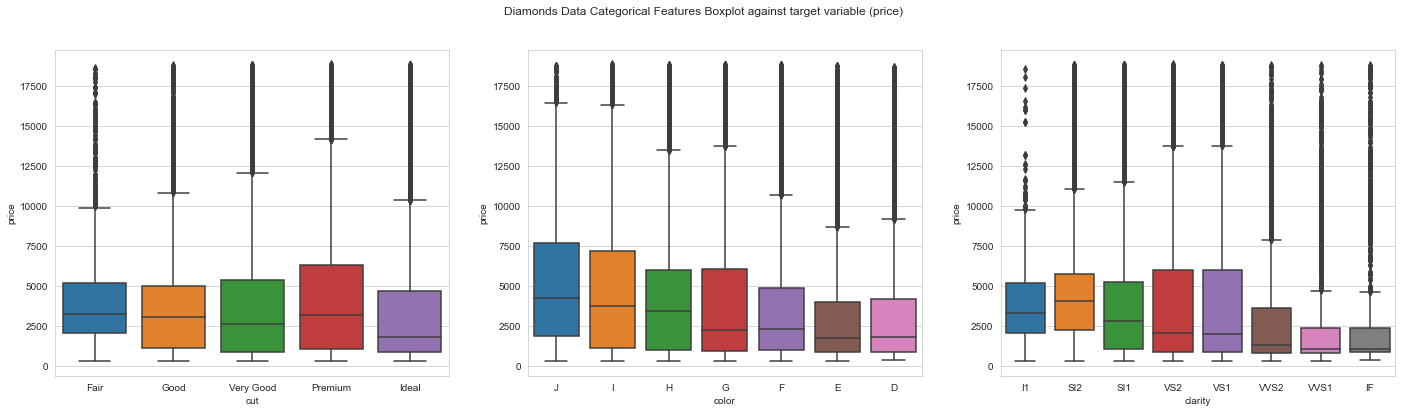

In [33]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, 
                     categs_order= diamonds_categs_order,
                     target_feature='price', data_name='Diamonds Data',
                     num_rows=1, num_cols=3, fig_size=(24,6))

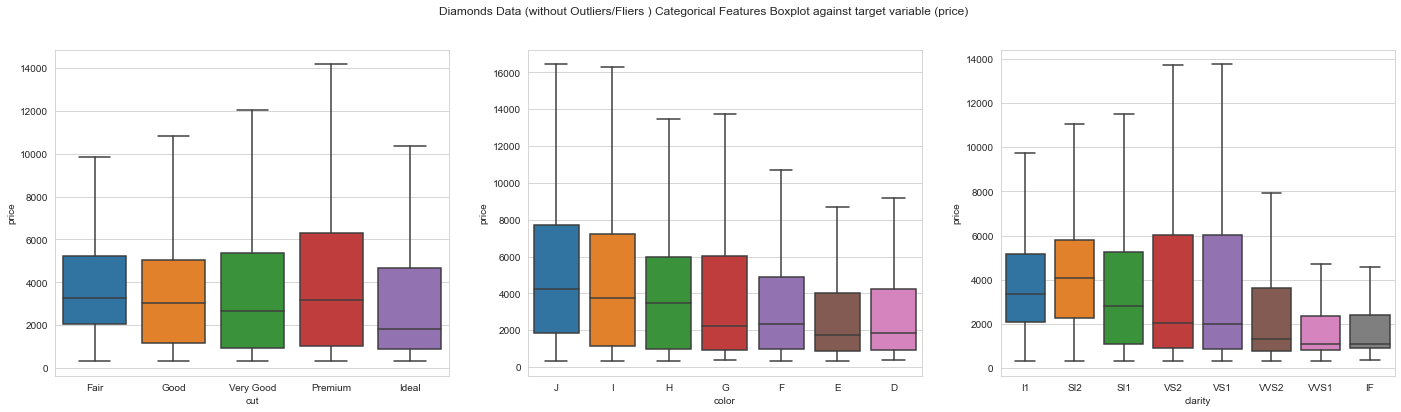

In [34]:
boxplot_cat_features(data=diamonds_df, cat_feats=diamonds_cat_cols, categs_order= diamonds_categs_order,
                     target_feature='price', data_name='Diamonds Data (without Outliers/Fliers )',
                     num_rows=1, num_cols=3, fig_size=(24,6), showfliers=False)

__Diamond Dataset:__

Cut boxplots: The minimum of the cut categories are all very close. The median values are close to each other except for the Ideal cut where the median price is lower compared to its counterparts. One surprising thing to see is that even though Ideal is the best quality, the median, 3rd percentile and maximum (Q3+1.5*IQR) prices are lower compared to Premium and Very Good cut categories. Premium cut has a higher  3rd percentile and maximum (Q3+1.5*IQR) values compared to other categories. All cuts have outlier prices that goes as high as around 17500. From the plot, we can say that the median and minimum price ranges are similar between cut types. 

Color boxplots: J color seems to have higher prices since its 1st quartile, median and 3rd quartile are higher than its counter parts. If we group colors by similar price distributions we can say that J,I pricing distribution are close to each other, with the highest price distributions and E,D is the colors where diamond prices are lower overall. Though outliers exists for all color types that has peak prices. For lower color quality the median and 3rd quartile prices are higher compared to the high quality colors.

Clarity boxplots: This is the variable that has most diverse price distributions on its categories. The highest median and minimum value price belongs to SI2. VS2 and VS1 distiributions looks like very similar, these two types of clarity seems to have a lower median but highest 3rd quartile compared to other clarity levels. Best clarity level IF, price distribution is more compact toward lower price ranges. Again all categories have many outliers. 



##### __Gas Data:__

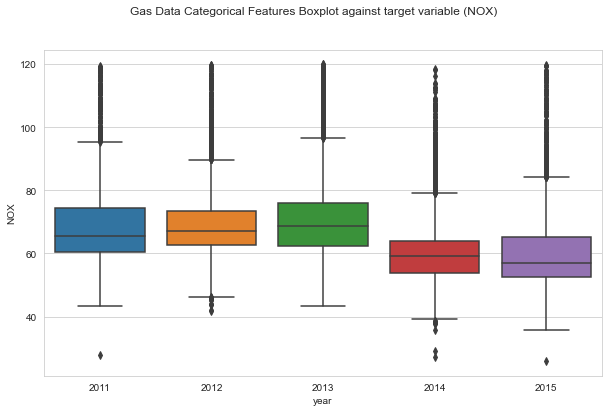

In [35]:
boxplot_cat_features(data=gas_df, cat_feats=gas_cat_cols,  categs_order= [year_categories],
                     target_feature='NOX', data_name='Gas Data',
                     num_rows=1, num_cols=1, fig_size=(10,6))

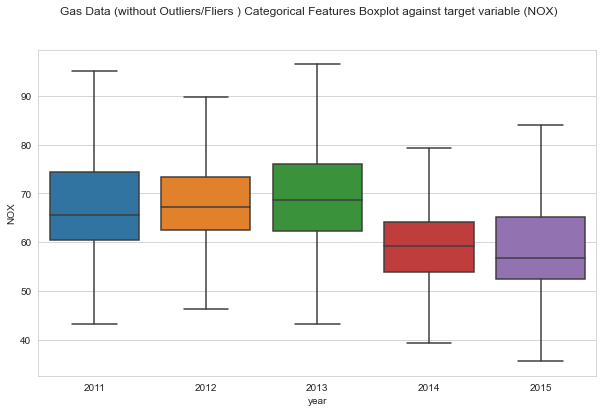

In [36]:
boxplot_cat_features(data=gas_df, cat_feats=gas_cat_cols,  categs_order= [year_categories],
                     target_feature='NOX', data_name='Gas Data (without Outliers/Fliers )',
                     num_rows=1, num_cols=1, fig_size=(10,6), showfliers=False)

__Gas Dataset:__

year boxplots: The NOX distributions seem to be very similar for years 2011, 2012 and 2013. Medians are similar for these 3 years. Although 1st, 3rd and minimum, maximum values of these 3 boxplots are different ranges. When we check 2014 and 2015, on the other hand, we see that NOX ranges captures are way lower compared the previous 3 years. The median values are lower, but even the 3rd quartiles and maximum for these 2 years are considerably lower than the previous 3 years. This can help us understand how NOX levels changed in Turkey within the 5 years. 

#### Question 5

In [37]:
def countplot_cat_features(data, num_feats, data_name,diamonds_categs_order, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Count plots')
    for num_feat, cat_order, ax_ind in zip(num_feats, diamonds_categs_order, ax.ravel()):
        sns.countplot(data=data, x=num_feat,  ax=ax_ind, order=cat_order)
    plt.show()

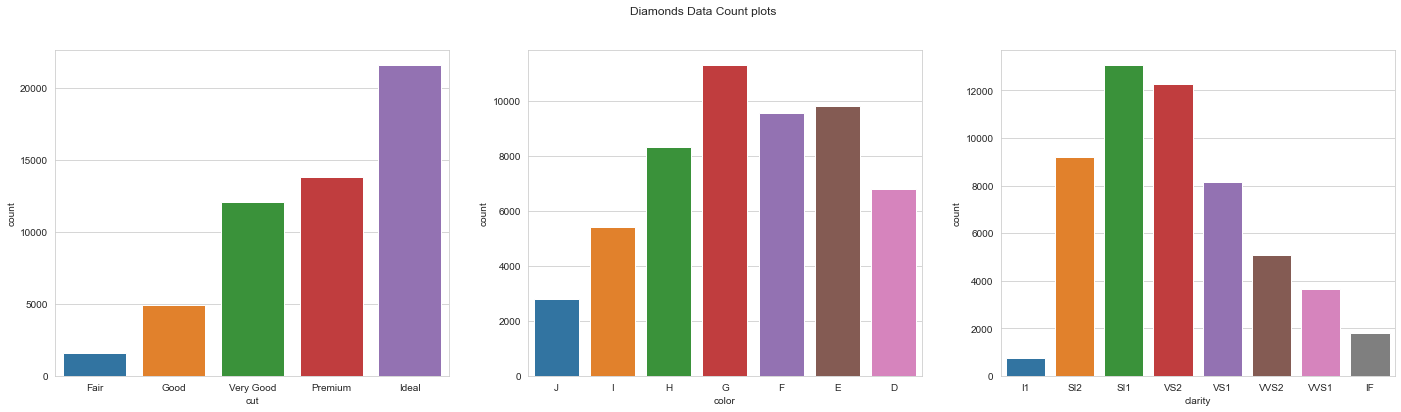

In [38]:
countplot_cat_features(data=diamonds_df, num_feats=diamonds_cat_cols, 
                     data_name='Diamonds Data', diamonds_categs_order=diamonds_categs_order,
                     num_rows=1, num_cols=3, fig_size=(24,6))

__In the diamonds data:__

Cut categories is not equally distributed in the data, ideal cut has the largest sample size. Actually cut quality vs sample size for that cut has positive relationship. Better quality cuts have more samples in the dataset.

Color categories are better distributed in the dataset compared to cut, but still not equally distributed per se. J has the lowest sample count in the dataset whereas G has the highest. Looks like the majority of the data has medium level quality colors.

Clarity variable for the data is uneven as well. The majority of the samples in the dataset lies within SI2, SI1 and VS2 categories (low-medium quality). There are fewer samples for the worst and best clarity diamonds. 

#### Question 6

__For the Gas Emission dataset, plot the yearly trends for each feature and compare them. The data points don’t have timestamps but you may assume the indices are times.__

In [39]:
def yearly_trends(data, num_feats, data_name, num_rows, num_cols, fig_size):
    plot_df = data.copy()
    plot_df['year'] = gas_df['year']
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'{data_name} Yearly Trends for Standardized Features')
    for col, ax_ind in zip(num_feats, ax.ravel()):
        sns.lineplot(data=plot_df, x=gas_df.index,  y=col, hue='year', ax=ax_ind)
        ax_ind.set_title(f'{col}')
    plt.show()

I plotted yearly trends for each feature in the Gas dataset, each year is colored to be able to see patterns more clearly. Indices used as times.

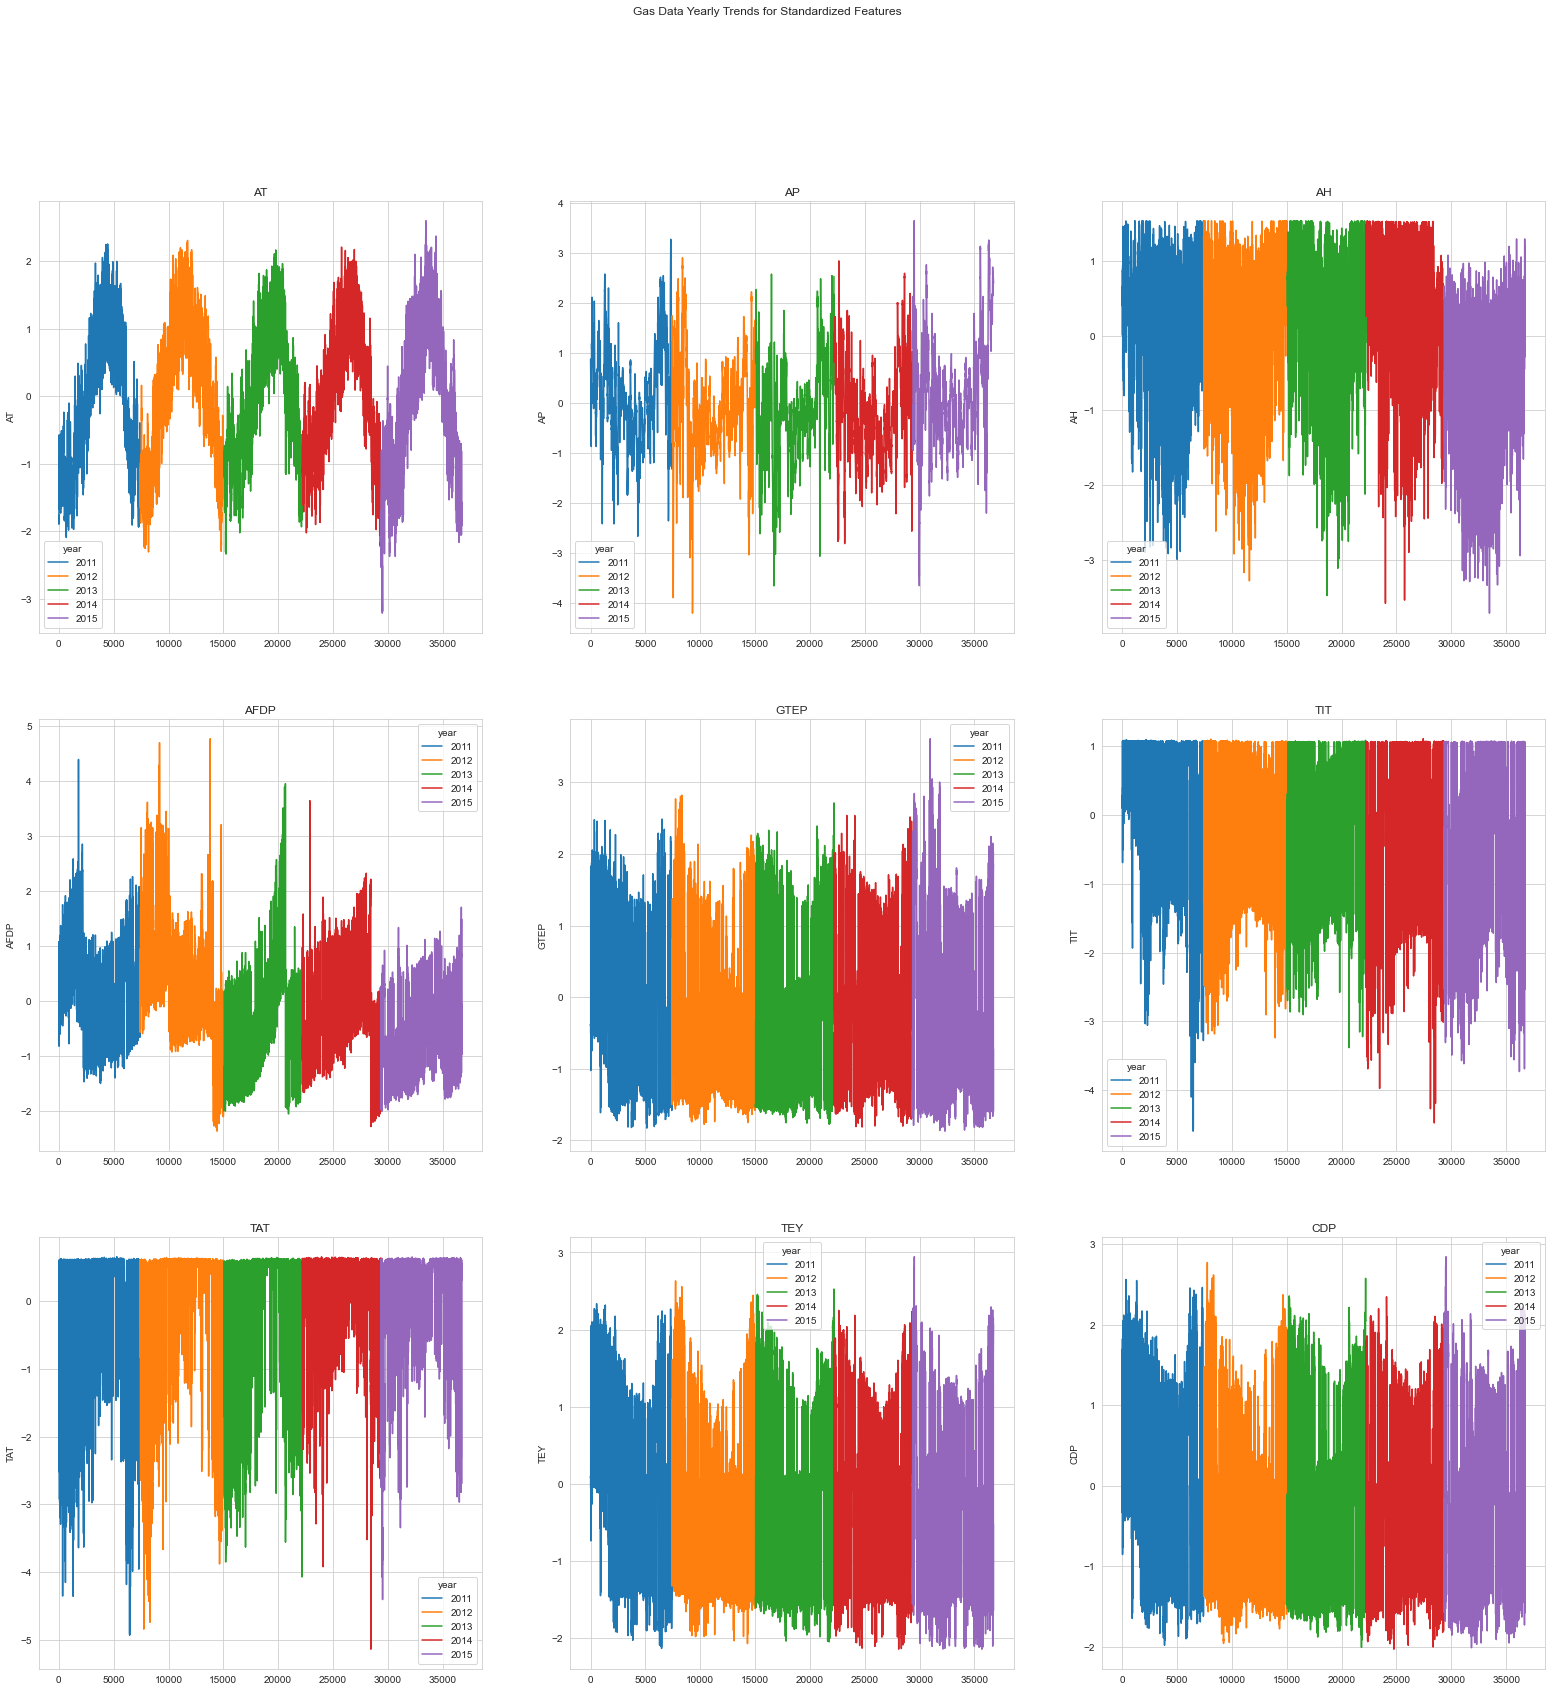

In [40]:

yearly_trends(data=gas_prep_df, num_feats=gas_num_cols, data_name='Gas Data', num_rows=3, num_cols=3, fig_size=(27,27))


From the abov plots, we can see that there are clear yearly patterns for all of the features. This is most obvious in the AT feature where we can see the same reversed V shape for each year. Some feature results are more varied within year such as TEY and CDP where it makes harder to understand the pattern, however even for those ones we can see some patterns such as towards the middle-end of each year there are some drops for all years compared to the beginning and end og each 5 years.

#### Feature Selection

For this part Mutual Info Regressiong and F regression is used from sklearn library for both datasets. For each preprocessed feature I computed the mutual info and f regression values against target variable.

##### __Question 7__

Mutual Info (MI) Regression calculates the dependency between two vairables and it should be a nonnegative value. 0 means two variables are independent from each other, higher MI values corresponds to higher dependency between the variables. 

F Regreesion performs univariate linear regression tests to capture the relationship between the given variables.

##### __Diamonds Data__

__Diamonds Data Mutual Info Regression & F Regression__

In [41]:
diamond_features = list(diamonds_num_cols)+list(diamonds_cat_cols)
X_diamonds = diamonds_prep_df[diamond_features]
X_diamonds_unscaled = diamonds_unscaled_df[diamond_features]
y_diamonds = diamonds_prep_df['price']

In [42]:
# mi regression
mi = mutual_info_regression(X_diamonds, y_diamonds)
mi_scaled = mi / np.max(mi)

# f regression
f_test, _ = f_regression(X_diamonds, y_diamonds)
f_test_scaled = f_test / np.max(f_test)

res_df = pd.DataFrame([diamond_features, mi, mi_scaled, f_test, f_test_scaled ]).T
res_df.rename(columns={0:'Feature Name', 1:'Mutual Info Regression Score',2:'Mutual Info Regression Score - Scaled',
                       3:'F Regression Score',4:'F Regression Score - Scaled'}, inplace=True)
res_df.sort_values(by='Mutual Info Regression Score - Scaled', ascending=False, inplace=True)
res_df

Feature Name Mutual Info Regression Score  \
0        carat                      1.65247   
4            y                      1.42218   
3            x                      1.41241   
5            z                      1.36035   
8      clarity                     0.217059   
7        color                     0.137524   
6          cut                    0.0600886   
2        table                    0.0329356   
1        depth                    0.0301225   

  Mutual Info Regression Score - Scaled F Regression Score  \
0                                     1             304051   
4                              0.860636             160916   
3                              0.854726             193742   
5                              0.823219             154923   
8                              0.131354            1188.01   
7                             0.0832233             1654.4   
6                             0.0363628            154.784   
2                             0.0199311            886.119   
1                             0.0182287            6.11586   

  F Regression Score - Scaled  
0                           1  
4                    0.529238  
3                      0.6372  
5                     0.50953  
8                  0.00390726  
7                  0.00544119  
6                 0.000509073  
2                  0.00291437  
1                 2.01146e-05

Table above shows the mutual info and f regression reasult for each variable against target variable price. Table is ordered by Mutual Info Regression Score - Scaled column. 

__Diamonds Data Scatter Plot of features vs target variable along with Scaled Mutual Info and F Regression Scores__

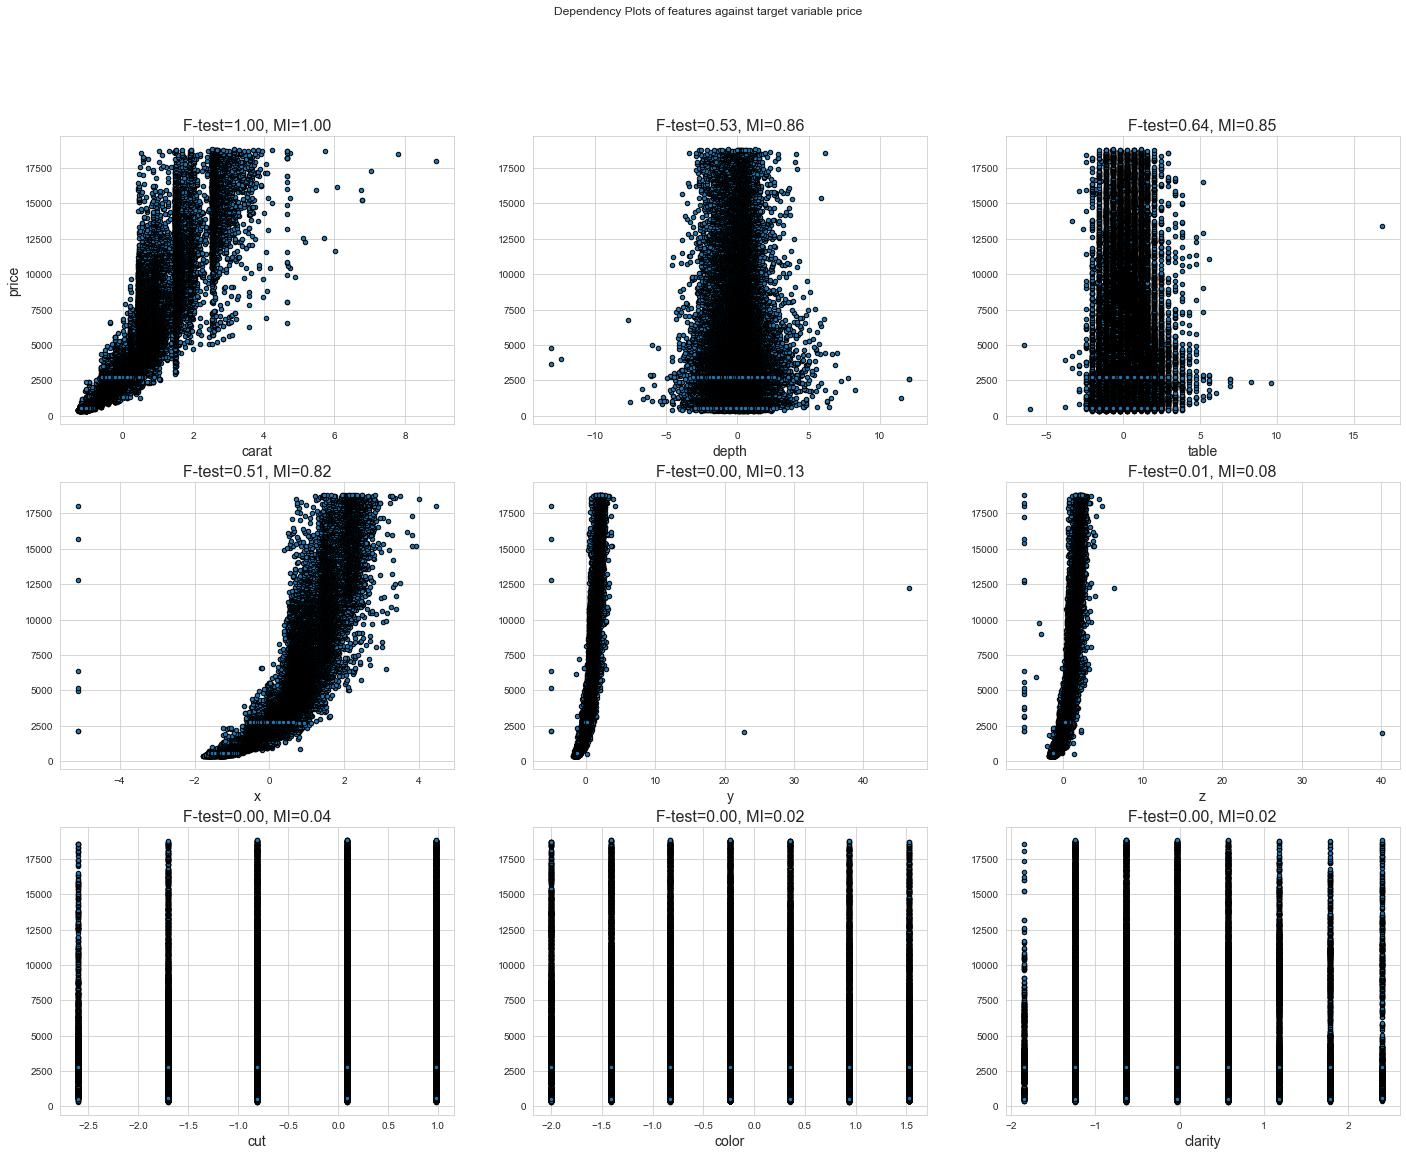

In [43]:
target_name ='price'
plt.figure(figsize=(24, 18))
plt.suptitle(f'Dependency Plots of features against target variable {target_name}')
for i, feat in enumerate(diamond_features):
    plt.subplot(3, 3, i + 1)
    plt.scatter(X_diamonds[feat], y_diamonds, edgecolor="black", s=20)
    plt.xlabel(feat, fontsize=14)
    if i == 0:
        plt.ylabel(target_name, fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(res_df['F Regression Score - Scaled'].iloc[i], res_df['Mutual Info Regression Score - Scaled'].iloc[i]), fontsize=16)
plt.show()

__Diamonds Data Most important Features:__

Mutual Info Regression most important 4 features:  carat, y, x, z.

F Regression most important 4 features: carat, x, y, z.

The order between mutual info and f regression for feature importances are slightly different.

I also experimented on different feature sets with Linear Regression model to see how their performance would change. All features in the diamond dataset seems to be helping for prediction since subset of the features perform worse with Linear Regression model. Given that diamonds dataset has very few variables, I decided to keep all of them and skip the feature selection part. In addition to this the experiments done on Q11 supports this decision, with the OLS experiment some results with other linear packages show that all features are important with p value being less than 0.05. You can refer to Q11 explanation for more details on this.

In [44]:
def apply_cv_to_model(model, X, y, model_name, cv=10, scoring= 'neg_root_mean_squared_error', print_res=True):
    cv_results = cross_validate(model, X,y,
                                    scoring=scoring, cv=cv, 
                                    return_train_score=True,return_estimator=True)
    train_rmse = cv_results['train_score']*(-1.)
    test_rmse = cv_results['test_score']*(-1.)
    if print_res:
        print(f'{model_name} Train Avg RMSE accross 10-fold cv: ', train_rmse.mean())
        print(f'{model_name} Validation Avg RMSE accross 10-fold cv: ',test_rmse.mean())
    return cv_results 

In [45]:
feat_sets = [ ('All Features', X_diamonds.columns.tolist()),
             ('Top 6 Features', ['carat','x','y','z','clarity','color']),
             ('Top 4 Features', ['carat','x','y','z'])
]

for f_name, feat_set in feat_sets:
    print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
    model_lr = LinearRegression()
    important_feats_diamonds = ['carat','x','y','z','clarity','color']
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_diamonds[feat_set], y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)

for name, fs in [('Mutual Info Regr.',mutual_info_regression),  ('F Regr.',f_regression)]:
    top_feats = 5
    print(f'\n\nTop {top_feats} {name} features:')
    X_new = SelectKBest(fs, k=top_feats).fit_transform(X_diamonds, y_diamonds)

    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_new, y=y_diamonds, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)



10-fold CV Linear Regression Experiment with All Features: 
 Features:['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


10-fold CV Linear Regression Experiment with Top 6 Features: 
 Features:['carat', 'x', 'y', 'z', 'clarity', 'color']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1221.6042206336504
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1228.2203041711414


10-fold CV Linear Regression Experiment with Top 4 Features: 
 Features:['carat', 'x', 'y', 'z']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1512.5608891324323
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1405.0166387786403


Top 5 Mutual Info Regr. features:
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1327.377219542444
Linear Regression (OLS) Validation Avg 

##### __Gas Data__

__Gas Data Mutual Info Regression & F Regression__

In [46]:
gas_features = list(gas_num_cols)+list(gas_cat_cols)
X_gas = gas_prep_df[gas_features]
X_gas_unscaled = gas_unscaled_df[gas_features]
y_gas = gas_prep_df['NOX']

In [47]:
# mi regression
mi = mutual_info_regression(X_gas, y_gas)
mi_scaled = mi / np.max(mi)

# f regression
f_test, _ = f_regression(X_gas, y_gas)
f_test_scaled = f_test / np.max(f_test)

res_df = pd.DataFrame([gas_features, mi, mi_scaled, f_test, f_test_scaled ]).T
res_df.rename(columns={0:'Feature Name', 1:'Mutual Info Regression Score',2:'Mutual Info Regression Score - Scaled',
                       3:'F Regression Score',4:'F Regression Score - Scaled'}, inplace=True)
res_df.sort_values(by='Mutual Info Regression Score - Scaled', ascending=False, inplace=True)
res_df

Feature Name Mutual Info Regression Score  \
5          TIT                     0.279721   
7          TEY                     0.274431   
0           AT                     0.268504   
4         GTEP                     0.249459   
8          CDP                     0.232809   
3         AFDP                     0.143041   
9         year                     0.141031   
6          TAT                     0.120372   
1           AP                    0.0960705   
2           AH                    0.0430093   

  Mutual Info Regression Score - Scaled F Regression Score  \
5                                     1            1760.54   
7                              0.981089            502.111   
0                              0.959901            16622.8   
4                              0.891814            1556.57   
8                              0.832292            1109.82   
3                               0.51137            1349.46   
9                              0.504185            3421.69   
6                              0.430329             319.01   
1                              0.343451            1404.93   
2                              0.153758            1023.09   

  F Regression Score - Scaled  
5                    0.105911  
7                   0.0302062  
0                           1  
4                   0.0936405  
8                   0.0667649  
3                   0.0811813  
9                    0.205844  
6                   0.0191911  
1                   0.0845184  
2                   0.0615477

Table above shows the mutual info and f regression reasult for each variable against target variable NOX. Table is ordered by Mutual Info Regression Score - Scaled column. TIT, TEY, AT, GTEP and CDP seems to be the most important features for Mutual Info Regression. For F Regression the most important feature seems to be AT. However, it is also important to note that the unscaled values for both of the results for each feature scores are relatively low.

__Gas Data Scatter Plot of features vs target variable along with Scaled Mutual Info and F Regression Scores__

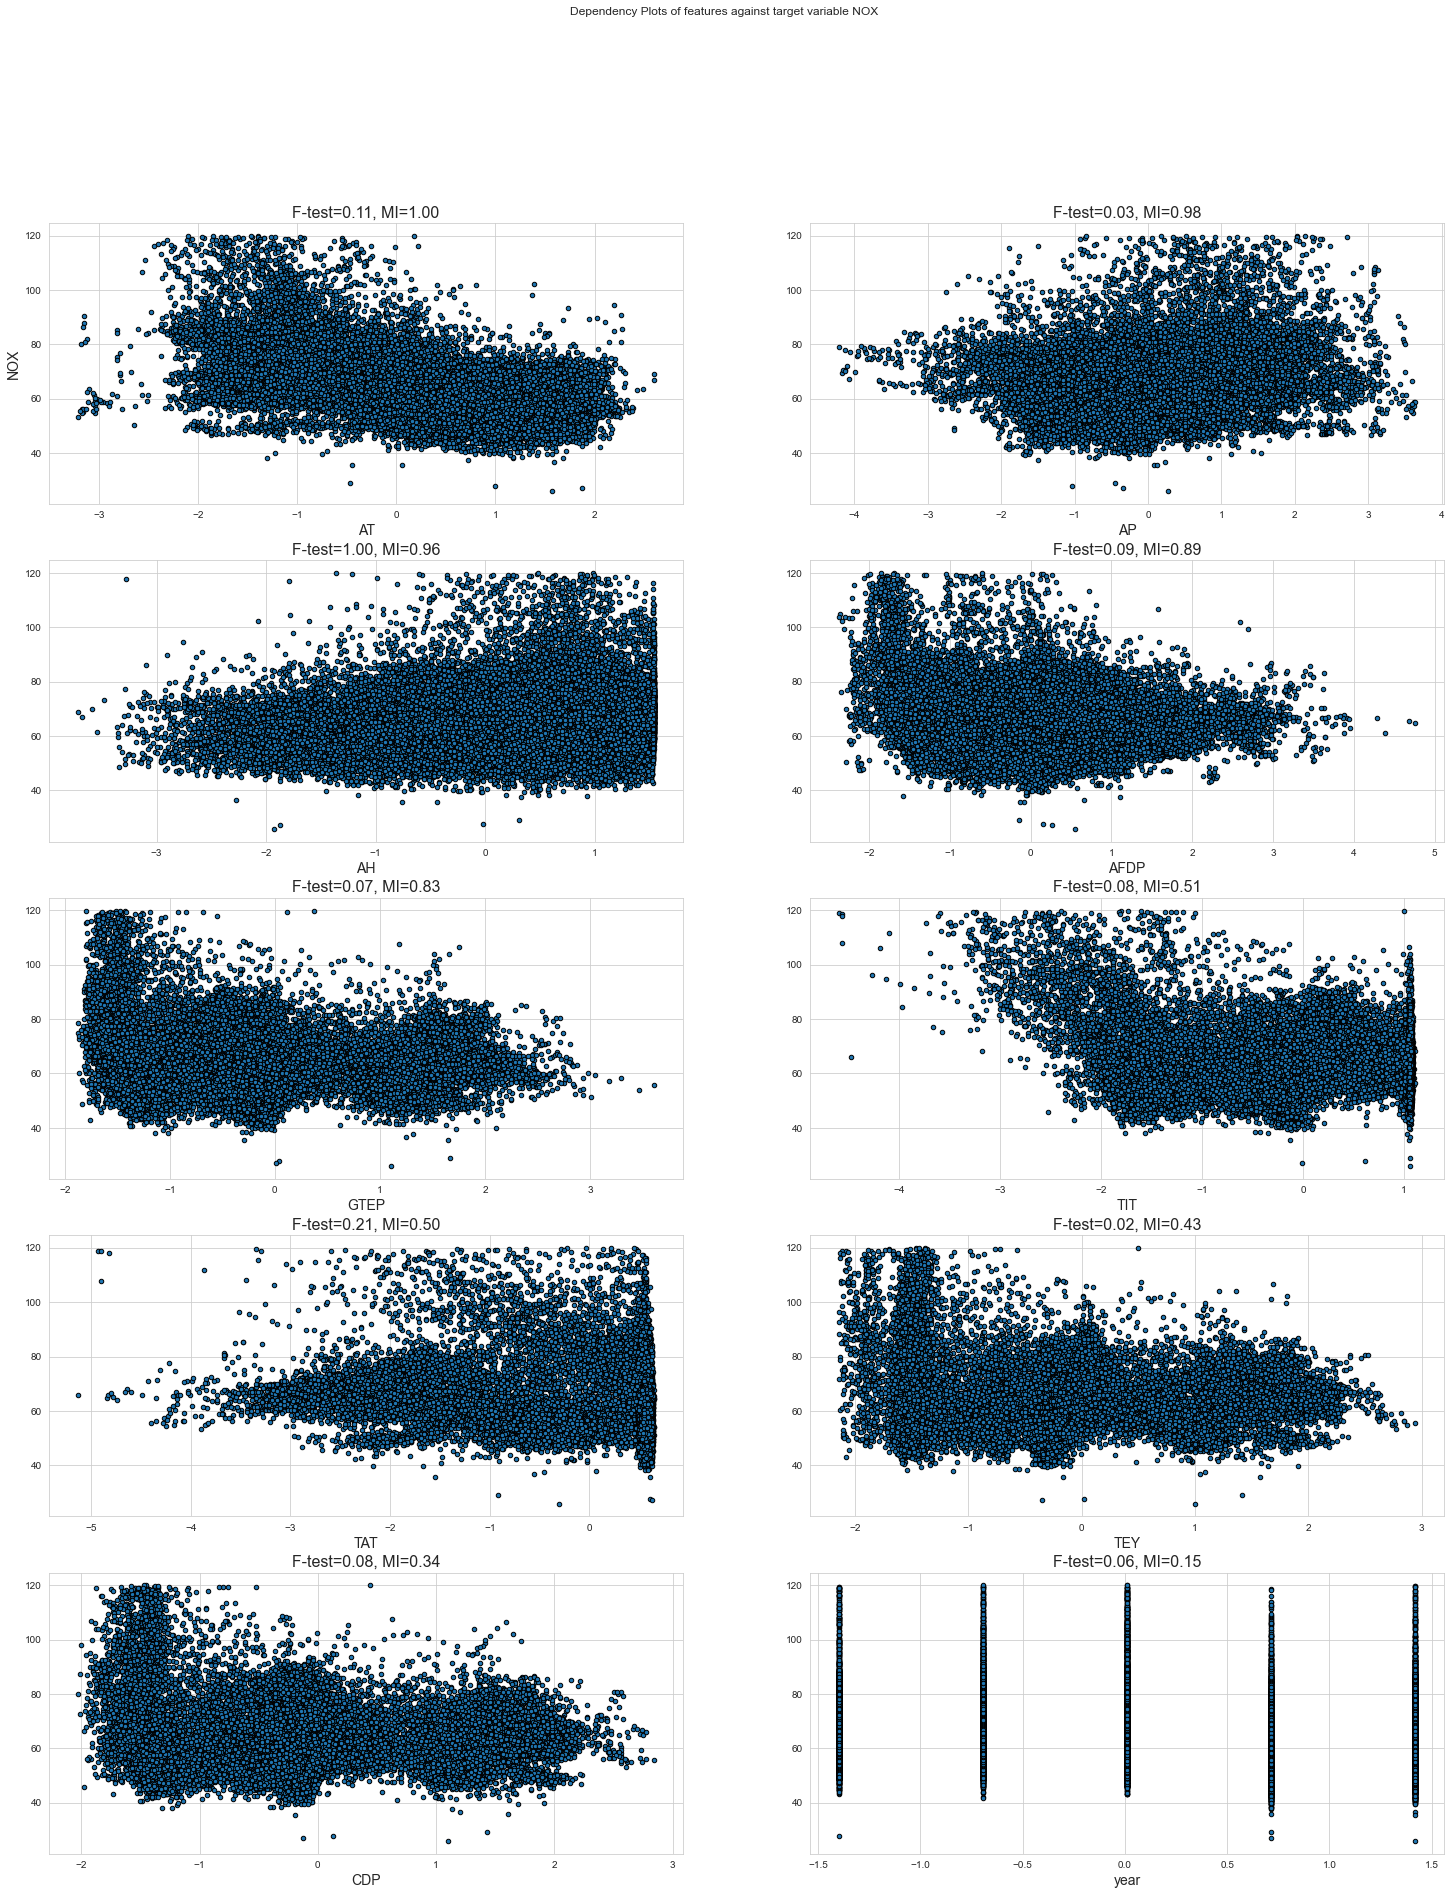

In [48]:
target_name ='NOX'
plt.figure(figsize=(25, 30))
plt.suptitle(f'Dependency Plots of features against target variable {target_name}')
for i, feat in enumerate(gas_features):
    plt.subplot(5, 2, i + 1)
    plt.scatter(X_gas[feat], y_gas, edgecolor="black", s=20)
    plt.xlabel(feat, fontsize=14)
    if i == 0:
        plt.ylabel(target_name, fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(res_df['F Regression Score - Scaled'].iloc[i], res_df['Mutual Info Regression Score - Scaled'].iloc[i]), fontsize=16)
plt.show()

__Gas Data Most important Features:__

Mutual Info Regression most important 5 features:  TIT, TEY, AT, GTEP and CDP 

F Regression most important 3 features: AT, year, TIT.

Important features found by mutual info and f regression are very different.

I also experimented on different feature sets with Linear Regression model to see how their performance would change. All features in the RMSE dataset seems to be helping for prediction since subset of the features perform worse with Linear Regression model. 

In [49]:
feat_sets = [ ('All Features', X_gas.columns.tolist()),
             ('Top MI Reg. Features', ['TIT','TEY','AT','GTEP','CDP']),
             ('Top F Reg. Features', ['AT','year','TIT'])
]

for f_name, feat_set in feat_sets:
    print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_gas[feat_set], y=y_gas, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)

for name, fs in [('Mutual Info Regr.', mutual_info_regression),  ('F Regr.',f_regression)]:
    top_feats = 5
    print(f'\n\nTop {top_feats} {name} features:')
    X_new = SelectKBest(fs, k=top_feats).fit_transform(X_gas, y_gas)

    model_lr = LinearRegression()
    cv_results_lr = apply_cv_to_model(model=model_lr, 
                                      X=X_new, y=y_gas, 
                                      model_name='Linear Regression (OLS)',
                                      cv=10)



10-fold CV Linear Regression Experiment with All Features: 
 Features:['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410762


10-fold CV Linear Regression Experiment with Top MI Reg. Features: 
 Features:['TIT', 'TEY', 'AT', 'GTEP', 'CDP']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  9.14421286309772
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  9.455365986158789


10-fold CV Linear Regression Experiment with Top F Reg. Features: 
 Features:['AT', 'year', 'TIT']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.870111551541857
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  9.278648847152846


Top 5 Mutual Info Regr. features:
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  9.14421286309772
Linear Regression (OLS) Validation Avg RMSE a

Though one thing I realized when I was looking at the heatmap 3 of the features are very correlated with each other, and it might makes sense to drop 2 of them. Since this is the feature selection part, I will also explore this in here.

However, it is also important that the decision to drop is only based on what I saw in the heatmap, one could make better decision by knowing the meaning of each gas types and see if they are really correlated with each other. Since I am no expert in this area, I will check below to see if dropping two of them (CDP and GTEP) will help with the model performance. 

In [50]:
feat_set = ['AT', 'AP', 'AH', 'AFDP', 'TIT', 'TAT', 'TEY', 'year']
print(f'\n\n10-fold CV Linear Regression Experiment with {f_name}: \n Features:{feat_set}')
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_gas[feat_set], y=y_gas, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)



10-fold CV Linear Regression Experiment with Top F Reg. Features: 
 Features:['AT', 'AP', 'AH', 'AFDP', 'TIT', 'TAT', 'TEY', 'year']
Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.036895416801087
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.713495424542154


The model performance is slightly improved, avg. 10-fold cross validation RMSE score decreased from 8.8 to 8.7, we can see that it doesn't hurt deleting these features. Given that 3 of these features (GTEP, TEY and CDP) are very correlated with each other, I considered to drop them. Though as I said I am no expert and a better decision can be made by experts in these area.

In addition to that the names of these features from the table are below:
CDP: Compressor discharge pressure
TEY: Turbine energy yield 
GTEP: Gas turbine exhaust pressure

Again this doesn't tell me too much about the data.

I found the paper published for this dataset and its benchmark. I realized that the authors of the paper also saw a correlation between these two variables, point out that it has benefits in predictive modelling and they might be dropped. 
However, in their experiment results and feature importances I saw that they kept these variables. Given that they are more knowledgable, experts in the field, the ones who prepared and benchmarked the dataset, and I didn't see huge changes in the above results, I finally decided to keep them and use all the features. 

Paper link: https://journals.tubitak.gov.tr/elektrik/issues/elk-19-27-6/elk-27-6-54-1807-87.pdf

__How does this step affect the performance of your models in terms of test RMSE?__

Feature selection has different effects on the performance of the test data. If the removed features contains redundant data, noise or unrelated to the target variable, this step reduces the chances for overfitting, enhance the model generalization and improves the test RMSE score. This means if features selected precisely, test RMSE score is expected to lower and model to perform better. However, if deleted features contain important information that can be used for the prediction, the test RMSE score would increase and model performing worse. That is why, feature selection is a not a trivial step and should be performed carefully on which data we want to keep and remove. Feature selection also help decreasing both training and inference time given that we have to deal with less data. 

If we think specifically for feature selection based on mutual information, it is not only limited to linear dependency but it rather quantifies the amount of information obtained from observing one variable about the other one. Whereas f regression captures only linear relationship between variables. Ideally, both feature selection methods expect to decrease redundant variables which leads less opportunity to overfit the model and better generalization. This means we expect to have good performing models with lower RMSE test scores. However, again we need to be careful, for example, with f regression we might possibly discard important nonlinear features during feature selection. This might hurt the model performance and increase the test RMSE score.
To conclude, feature selection is a step to help reducing overfitting and to have generalization, improving both performance and time to train and inference of the model and leads to lower test RMSE score if performed successfully.




## Linear Regression

#### Question 8

__What is the objective function?__

The Linear Regression model prediction is made: 

\begin{equation} \hat{y} = b + \sum_{i=1}^{p} x_iw_i =  x^Tw \end{equation}

$\hat{y}$ is predicted value, b bias (intercept term), p is the number for features, w is weights and x is the input data.
(In the second part of the equation b is incorparated in the w in this case.).

Using RMSE as our error metric:

__Ordinary Least Squares (Linear Regression without Regularization) Objective Function:__

\begin{equation} \min_{w} ||(Xw - Y)||^2_2 \end{equation}

__Lasso Regression (L1 Regularization) Objective Function:__

\begin{equation} \min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||_1 \end{equation}


__Ridge Regression (L2 Regularization) Objective Function:__

\begin{equation} \min_{w} ||(Xw - Y)||^2_2  + \lambda ||w||^2_2 \end{equation}

X input, Y ground truth label, w parameters and $\lambda$ is the regularization strength, hyperparameter to be tuned.

__Explain how each regularization scheme affects the learned hypotheses.__ 

Regularization techniques are used to avoid model overfitting and improving model generalization by adding a penalty term to the objective function. The intuition behind regularization is that by adding penalty terms related to the model weights (coefficients), the optimizer won't try to increase some weights larger and larger, so it encourages the weights to be kept small.

- __Lasso Regression:__

Lasso is also called L1 Regularization, it adds the absolute value of magnitude of coefficients  (L1 norm) as penalty term to the loss function. It's advantage is it can set some coefficients to 0 (create sparse solutions), hence it might eliminate some features and can be considered as a built-in feature selection. It has unstable solution and may have  multiple solutions for the optimization problem. 


- __Ridge Regression:__

Ridge also called as L2 regularization since it adds squared magnitude of coefficients (squared L2 norm) as penalty term to the loss function. It forces the coefficients to be lower, close to 0 but not 0. The output is therefore non-sparse and it doesn't choose some subset of the features. It is computationally efficient since it has analytical solutions. After L2 regularization the optimal solutions are generally more stable.


#### Question 9

For each model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

__How to pick optimal penalty (lambda) parameter? (alpha in sklearn)__

There are several ways to select best values for choosing optimal regaularization value for linear models:

1- Via cross validation and grid search    
2- Using information criterion (AIC, BIC) for Lasso Regression     
3- Using model specific cross validations implemented in sklearn such as LassoCV and RidgeCV.   

Lasso and Ridge models also have their own special cross validation implementations in scikit-learn to find a good value of penalty scores. They are called LassoCV and RidgeCV model, but the scores are calculated in terms of MSE rather than RMSE and only test scores are returned. Given that we are also interested on the training scores for the questions, I could't use these functions. 

For Lasso Regression you can see the results of different lambda (alpha in sklearn) parameters both with Cross Validation + GridSearch and with AIC, BIC method. For Ridge Regression alpha value is only done with 10-fold cross validation over gridsearch with different lambda (alpha in sklearn) values.

Note: For cross validation results, sklearn scoring function uses negative RMSE values (neg_root_mean_squared_error) to be able to minimize the loss function. That is why the returned RMSE values are negative and we can simply get their absolute results as the RMSE value.

##### Diamonds Data Results

###### __Ordinary Least Squares (Linear Regression without Regularization)__

In [51]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.280596794617
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850985


Check RMSE results for each of the 10-fold:

In [52]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


###### __Lasso Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [53]:
def linear_model_exp(X,y):
    full_pipeline = Pipeline([('model', "passthrough")
                             ])
    alphas = [10**(x) for x in range(-8,6)]
    params = {
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)
               ],
        "model__alpha": alphas
    }

    t0 = time.time()
    grid_search = GridSearchCV(full_pipeline, params, cv=10, 
                               scoring='neg_root_mean_squared_error', 
                               return_train_score=True)
    cv_results = grid_search.fit(X, y)
    t1 = time.time()
    elapsed = t1-t0
    #print(time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
    grid_results_df = pd.DataFrame(grid_search.cv_results_)
    grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')
    grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
    grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
    grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
    #grid_results_df.head()
    return grid_search, grid_results_df

In [54]:
grid_search_lr, grid_res_lr_df = linear_model_exp(X=X_diamonds, y=y_diamonds)

In [55]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df[grid_res_lr_df.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045052      Lasso              1e-06
17       1206.280597            1205.045064      Lasso              1e-05
18       1206.280597            1205.045161      Lasso             0.0001
19       1206.280597            1205.046257      Lasso              0.001
20       1206.280605            1205.057629      Lasso               0.01
21       1206.281434            1205.175550      Lasso                0.1
22       1206.357387            1206.498138      Lasso                  1
23       1210.657916            1225.290602      Lasso                 10
24       1251.275772            1244.896044      Lasso                100
25       1843.911711            1770.022846      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

The best average train and validation RMSE scores for Lasso Regression are in the 1205-1206 ranges. A good range for alpha is in this case is around 0.01 and 1. Since the RMSE doesn't change too much, we can pick 1 as the optimal penalty parameter. The reason behind is that we want to have simpler model that could achieve a good performance. Having a higher regularization helps us having simpler model and we can see that with $\alpha=1$ we can achieve average RMSE results very close to the ones we found in the case of no regularization both in training and validation sets.   

###### __Penalty Selection based on AIC/BIC for Lasso__

Lasso model fit with Lars using BIC (Bayes Information criterion) or AIC (Akaike information criterion) for model selection. 
These two criterion are used to select the regularization parameter. A good model should explain well the data while being simple to achieve that a trade-off between the goodness of fit and the complexity of the model is made.

In [56]:
lasso_lars_ic =  LassoLarsIC(criterion="aic", normalize=False).fit(X=X_diamonds, y=y_diamonds)
results = pd.DataFrame({"alphas": lasso_lars_ic.alphas_,
                        "AIC criterion": lasso_lars_ic.criterion_,}).set_index("alphas")
alpha_aic = lasso_lars_ic.alpha_
lasso_lars_ic.set_params(criterion="bic").fit(X_diamonds, y_diamonds)
results["BIC criterion"] = lasso_lars_ic.criterion_
alpha_bic = lasso_lars_ic.alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

In [57]:
def plot_aic_bic(alpha_aic, alpha_bic, results):
    ax = results.plot(figsize=(8,7))
    ax.vlines(
        alpha_aic,
        results["AIC criterion"].min(),
        results["AIC criterion"].max(),
        label="alpha: AIC estimate",
        linestyles="--",
        color="tab:blue",
    )
    ax.vlines(
        alpha_bic,
        results["BIC criterion"].min(),
        results["BIC criterion"].max(),
        label="alpha: BIC estimate",
        linestyle="--",
        color="tab:orange",
    )
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel("criterion")
    ax.set_xscale("log")
    ax.legend()
    _ = ax.set_title(
        f"Information-criterion for model selection)"
    )

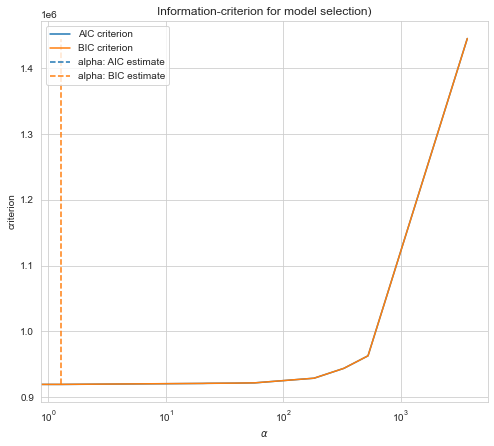

In [58]:
plot_aic_bic(alpha_aic=alpha_aic, alpha_bic=alpha_bic, results=results)

According to AIC criterion good alpha value is 0, and BIC criterion is around 1.3. This also supports the result we found above.

###### __Ridge Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [59]:
grid_res_lr_df[grid_res_lr_df.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045052      Ridge              1e-05
4        1206.280597            1205.045059      Ridge             0.0001
5        1206.280597            1205.045137      Ridge              0.001
6        1206.280597            1205.045909      Ridge               0.01
7        1206.280598            1205.053637      Ridge                0.1
8        1206.280754            1205.131037      Ridge                  1
9        1206.295931            1205.916546      Ridge                 10
10       1207.536689            1214.414691      Ridge                100
11       1248.699264            1292.818122      Ridge               1000
12       1458.983908            1489.476610      Ridge              10000
13       2112.850610            1950.711595      Ridge             100000

In the case of Rigde regression we can increase the regularization in the range of 1-10. With the similar reasoning explained for Lasso, I will pick 10 as the optimal parameter. 

###### __Best Regularization with optimal penalty parameter__

In the diamonds dataset, both Lasso and Ridge Regularization reach the same optimal results for average RMSE on training and validation sets. These results are also same for Linear Regression without regularization and lies in within 1205-1206 RMSE score. If we only look at the average optimal results, these 3 models don't really have much difference. When I checked the std of the train and validation RMSE scores for 10-fold cv(shown below) and the scores for each fold individually, again there is nothing very different for Lasso and Ridge Regression.

If I choose one, I would pick Ridge regularization since it seems to be better regularization scheme for diamonds data for the overall RMSE scores for higher regularization values. The avg. scores are way lower in Ridge then Lasso. For example Lasso when alpha=1000 avg RMSE validation score=1770 and Ridge when alpha=1000 avg RMSE validation score=1292. Therefore, Ridge regularization is best regularization scheme with optimal penalty 1.

Ridge Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [60]:
model = 'Ridge'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
8        -943.047423        -918.745592       -1112.593318       -1480.207682   
9        -945.772298        -921.113590       -1112.713075       -1476.998752   

   split4_test_score  split5_test_score  split6_test_score  split7_test_score  \
8       -2806.756166       -1700.057234        -815.570266        -877.496956   
9       -2809.011538       -1702.738090        -814.432034        -876.470311   

   split8_test_score  split9_test_score  mean_validation_score  \
8        -670.987363        -725.848366            1205.131037   
9        -672.135127        -727.780644            1205.916546   

   std_test_score  rank_test_score  
8      617.997804               16  
9      618.307116               18

split0_train_score  split1_train_score  split2_train_score  \
8        -1246.677053        -1248.662286        -1230.784516   
9        -1246.688078        -1248.673713        -1230.798464   

   split3_train_score  split4_train_score  split5_train_score  \
8        -1190.650864         -954.234736        -1157.681538   
9        -1190.668558         -954.268267        -1157.694613   

   split6_train_score  split7_train_score  split8_train_score  \
8        -1256.252739        -1252.998340        -1264.052939   
9        -1256.266196        -1253.011377        -1264.065238   

   split9_train_score  mean_train_score  std_train_score  
8        -1260.812526       1206.280754        90.084923  
9        -1260.824805       1206.295931        90.078895

Lasso Regression Results (test score columns are actually validation score here, crossvalidate names them as test.)

In [61]:
model = 'Lasso'
val_cols = [c for c in grid_res_lr_df.columns if 'test' in c or 'validation' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][val_cols])

tr_cols = [c for c in grid_res_lr_df.columns if 'train' in c]
display(grid_res_lr_df[(grid_res_lr_df.model_name==model) & (grid_res_lr_df.param_model__alpha.isin([1,10]))][tr_cols])

split0_test_score  split1_test_score  split2_test_score  \
22        -948.420031        -923.845640       -1113.481926   
23       -1001.156908        -974.532777       -1125.583926   

    split3_test_score  split4_test_score  split5_test_score  \
22       -1476.159596       -2810.451532       -1705.121582   
23       -1436.060043       -2869.030266       -1761.357107   

    split6_test_score  split7_test_score  split8_test_score  \
22        -812.459728        -874.713354        -671.818620   
23        -788.742713        -848.425307        -684.250555   

    split9_test_score  mean_validation_score  std_test_score  rank_test_score  
22        -728.509373            1206.498138      618.777888               19  
23        -763.766418            1225.290602      632.064742               21

split0_train_score  split1_train_score  split2_train_score  \
22        -1246.742106        -1248.726980        -1230.852788   
23        -1250.603468        -1252.591315        -1234.881322   

    split3_train_score  split4_train_score  split5_train_score  \
22        -1190.696045         -954.420070        -1157.758913   
23        -1194.615517         -961.823509        -1162.617515   

    split6_train_score  split7_train_score  split8_train_score  \
22        -1256.316502        -1253.061068        -1264.115736   
23        -1260.161182        -1256.757931        -1267.712219   

    split9_train_score  mean_train_score  std_train_score  
22        -1260.883657       1206.357387        90.051053  
23        -1264.815178       1210.657916        88.987987

__Best model feature importance:__

From the best found linear regression model (Ridge Regression) we see the coefficients below:

In [62]:
best_model_lr = grid_search_lr.best_estimator_
feature_names = X_diamonds.columns

coefs_df = pd.DataFrame(
    best_model_lr['model'].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs_df['coef_absolute'] = coefs_df.Coefficients.apply(lambda x: abs(x))
coefs_df[coefs_df.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

carat           x     clarity      color         cut  \
Coefficients   5092.655074 -984.480857  826.612634  548.94111  134.816544   
coef_absolute  5092.655074  984.480857  826.612634  548.94111  134.816544   

                    depth      table          y          z  
Coefficients  -114.319163 -59.802654  49.963989 -20.679798  
coef_absolute  114.319163  59.802654  49.963989  20.679798

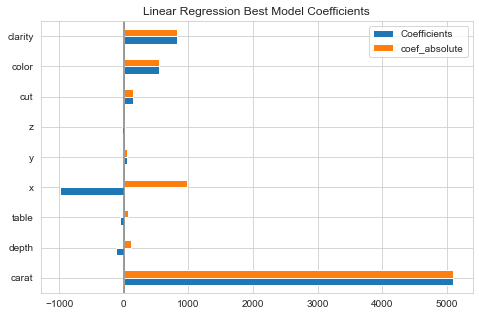

In [63]:
coefs_df[coefs_df.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Linear Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

According to coeffs, the most important feature is carat, followed by x, clarity, color and cut. x, depth, table and z has reverse relation with target variable whereas the other features have positive correlation.

In [64]:
# TODO experiment with different categorical encoding.

##### Gas Data Results

###### __Ordinary Least Squares (Linear Regression without Regularization)__

In [65]:
model_lr_gas = LinearRegression()
cv_results_lr_gas = apply_cv_to_model(model=model_lr_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='Linear Regression (OLS)',
                                  cv=10)

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410762


Check RMSE results for each of the 10-fold:

In [66]:
print('Train RMSEs:', cv_results_lr_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr_gas['test_score']*(-1.))

Train RMSEs: [8.20232426 8.0507639  8.1187614  8.17650722 7.74108808 7.83083707
 7.79695147 8.26129408 8.19835912 7.92784446]
Validation RMSEs:  [ 7.43536346  8.57794857  7.89249311  7.21361859 11.91720141 10.28186932
 11.55608868  6.192516    7.87080299  9.88056272]


###### __Lasso Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [67]:
grid_search_lr_gas, grid_res_lr_df_gas = linear_model_exp(X=X_gas, y=y_gas)

In [68]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14          8.030497               8.890395      Lasso              1e-08
15          8.030497               8.890394      Lasso              1e-07
16          8.030497               8.890384      Lasso              1e-06
17          8.030496               8.890279      Lasso              1e-05
18          8.030491               8.889226      Lasso             0.0001
19          8.030507               8.878864      Lasso              0.001
20          8.036236               8.802989      Lasso               0.01
21          8.343862               8.958754      Lasso                0.1
22          8.888678               9.370859      Lasso                  1
23         11.656838              11.747458      Lasso                 10
24         11.656838              11.747458      Lasso                100
25         11.656838              11.747458      Lasso               1000
26         11.656838              11.747458      Lasso              10000
27         11.656838              11.747458      Lasso             100000

The best average train and validation RMSE scores for Lasso Regression are in the 8.03-8.9 ranges. A good alpha value in this case is 0.01 where validation score is minimized. 

###### __Penalty Selection based on AIC/BIC for Lasso__

In [69]:
lasso_lars_ic =  LassoLarsIC(criterion="aic", normalize=False).fit(X=X_gas, y=y_gas)
results = pd.DataFrame({"alphas": lasso_lars_ic.alphas_,
                        "AIC criterion": lasso_lars_ic.criterion_,}).set_index("alphas")
alpha_aic = lasso_lars_ic.alpha_
lasso_lars_ic.set_params(criterion="bic").fit(X_gas, y_gas)
results["BIC criterion"] = lasso_lars_ic.criterion_
alpha_bic = lasso_lars_ic.alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

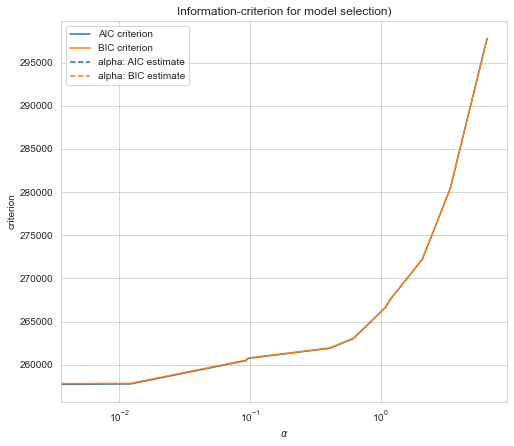

In [70]:
plot_aic_bic(alpha_aic=alpha_aic, alpha_bic=alpha_bic, results=results)

According to AIC and BIC criterion good alpha value is 0.

###### __Ridge Regression__

I tried alpha values from 1e-8 to 1e6. Results can be seen from below table:

In [71]:
grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0           8.030473               8.881846      Ridge              1e-08
1           8.030473               8.881846      Ridge              1e-07
2           8.030473               8.881846      Ridge              1e-06
3           8.030473               8.881846      Ridge              1e-05
4           8.030473               8.881846      Ridge             0.0001
5           8.030473               8.881841      Ridge              0.001
6           8.030473               8.881795      Ridge               0.01
7           8.030473               8.881332      Ridge                0.1
8           8.030498               8.876794      Ridge                  1
9           8.032520               8.839102      Ridge                 10
10          8.094992               8.761643      Ridge                100
11          8.316408               8.949233      Ridge               1000
12          8.778942               9.323730      Ridge              10000
13         10.333445              10.634421      Ridge             100000

In the case of Rigde best alpha value is 100 where validation score is minimized.

###### __Best Regularization with optimal penalty parameter__

Top 3 results from experiment:

In [72]:
grid_res_lr_df_gas[show_cols].sort_values(by=['mean_validation_score']).head(3)

mean_train_score  mean_validation_score model_name param_model__alpha
10          8.094992               8.761643      Ridge                100
20          8.036236               8.802989      Lasso               0.01
9           8.032520               8.839102      Ridge                 10

In the gas dataset, both Lasso and Ridge Regularization reach similar optimal results for average RMSE on training and validation sets. These results are also very close for Linear Regression without regularization and lies in within 8-8.8 RMSE score. Ridge regularization seem to perform slighlty better than Lasso, therefore the best regularization scheme for this dataset is Ridge with alpha 100.

__Best model feature importance:__

From the best found linear regression model (Ridge Regression) we see the coefficients below:

In [73]:
best_model_lr_gas = grid_search_lr_gas.best_estimator_
feature_names_gas = X_gas.columns

coefs_df_gas = pd.DataFrame(
    best_model_lr_gas['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_gas,
)

coefs_df_gas['coef_absolute'] = coefs_df_gas.Coefficients.apply(lambda x: abs(x))
coefs_df_gas[coefs_df_gas.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

TEY        TIT         AT       TAT        AH       CDP  \
Coefficients  -15.753769  13.057814 -10.803841 -5.660252 -3.279827 -2.640984   
coef_absolute  15.753769  13.057814  10.803841  5.660252  3.279827  2.640984   

                   year        AP     AFDP      GTEP  
Coefficients  -2.102134 -1.204434  0.30354 -0.263377  
coef_absolute  2.102134  1.204434  0.30354  0.263377

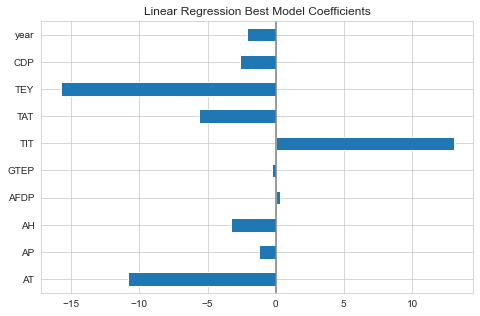

In [74]:
coefs_df_gas[coefs_df_gas.Coefficients!=0]['Coefficients'].plot(kind="barh", figsize=(10, 5))
plt.title("Linear Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

According to coeffs, the most important 5 features are TEY, followed by TIT, then AT, TAT and AH. Only TIT is the positively correlatead feature with NOX within these 5 important features found.

#### Question 10

The same experiments as Q9 applied on unscaled features.

##### __Diamond Dataset Unscaled Feature results__

In [75]:
model_lr = LinearRegression()
cv_results_lr = apply_cv_to_model(model=model_lr, 
                                  X=X_diamonds_unscaled, y=y_diamonds, 
                                  model_name='Linear Regression (OLS)')

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  1206.2805967946167
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  1205.045050850984


Check RMSE results for each of the 10-fold:

In [76]:
print('Train RMSEs:', cv_results_lr['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr['test_score']*(-1.))

Train RMSEs: [1246.67693953 1248.66216822 1230.78437231 1190.65068211  954.23438537
 1157.68140298 1256.25260037 1252.99820555 1264.05281144 1260.81240006]
Validation RMSEs:  [ 942.74216047  918.48055067 1112.58133725 1480.56810359 2806.51518647
 1699.75830566  815.69881421  877.61209435  670.86071043  725.63324541]


In [77]:
grid_search_lr_unscl, grid_res_lr_df_unscl = linear_model_exp(X=X_diamonds_unscaled, y=y_diamonds)

In [78]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14       1206.280597            1205.045051      Lasso              1e-08
15       1206.280597            1205.045051      Lasso              1e-07
16       1206.280597            1205.045053      Lasso              1e-06
17       1206.280597            1205.045073      Lasso              1e-05
18       1206.280597            1205.045263      Lasso             0.0001
19       1206.280597            1205.047165      Lasso              0.001
20       1206.280609            1205.066857      Lasso               0.01
21       1206.281892            1205.272222      Lasso                0.1
22       1206.403372            1207.533286      Lasso                  1
23       1215.137979            1238.590955      Lasso                 10
24       1362.777782            1459.776195      Lasso                100
25       2049.825908            1984.620077      Lasso               1000
26       3957.162324            3544.036398      Lasso              10000
27       3957.162324            3544.036398      Lasso             100000

In [79]:
grid_res_lr_df_unscl[grid_res_lr_df_unscl.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
2        1206.280597            1205.045051      Ridge              1e-06
3        1206.280597            1205.045055      Ridge              1e-05
4        1206.280597            1205.045088      Ridge             0.0001
5        1206.280597            1205.045421      Ridge              0.001
6        1206.280597            1205.048757      Ridge               0.01
7        1206.280619            1205.082125      Ridge                0.1
8        1206.282816            1205.417296      Ridge                  1
9        1206.492542            1208.905905      Ridge                 10
10       1220.380991            1249.715537      Ridge                100
11       1388.872280            1472.734228      Ridge               1000
12       1597.964835            1620.737422      Ridge              10000
13       2266.684099            2074.013462      Ridge             100000

##### __Gas Dataset Unscaled Feature results__

In [80]:
model_lr_gas = LinearRegression()
cv_results_lr_gas = apply_cv_to_model(model=model_lr_gas, 
                                  X=X_gas_unscaled, y=y_gas, 
                                  model_name='Linear Regression (OLS)')

Linear Regression (OLS) Train Avg RMSE accross 10-fold cv:  8.030473106723004
Linear Regression (OLS) Validation Avg RMSE accross 10-fold cv:  8.881846484410753


Check RMSE results for each of the 10-fold:

In [81]:
print('Train RMSEs:', cv_results_lr_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_lr_gas['test_score']*(-1.))

Train RMSEs: [8.20232426 8.0507639  8.1187614  8.17650722 7.74108808 7.83083707
 7.79695147 8.26129408 8.19835912 7.92784446]
Validation RMSEs:  [ 7.43536346  8.57794857  7.89249311  7.21361859 11.91720141 10.28186932
 11.55608868  6.192516    7.87080299  9.88056272]


In [82]:
grid_search_lr_unscl_gas, grid_res_lr_df_unscl_gas = linear_model_exp(X=X_gas_unscaled, y=y_gas)

In [83]:
show_cols =['mean_train_score','mean_validation_score','model_name','param_model__alpha']
grid_res_lr_df_unscl_gas[grid_res_lr_df_unscl_gas.model_name=='Lasso'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
14          8.030497               8.890395      Lasso              1e-08
15          8.030497               8.890395      Lasso              1e-07
16          8.030497               8.890389      Lasso              1e-06
17          8.030497               8.890334      Lasso              1e-05
18          8.030495               8.889781      Lasso             0.0001
19          8.030495               8.884250      Lasso              0.001
20          8.031513               8.841661      Lasso               0.01
21          8.036915               8.728267      Lasso                0.1
22          8.166387               8.714142      Lasso                  1
23          9.562444               9.933988      Lasso                 10
24         11.656838              11.747458      Lasso                100
25         11.656838              11.747458      Lasso               1000
26         11.656838              11.747458      Lasso              10000
27         11.656838              11.747458      Lasso             100000

In [84]:
grid_res_lr_df_unscl_gas[grid_res_lr_df_unscl_gas.model_name=='Ridge'][show_cols]

mean_train_score  mean_validation_score model_name param_model__alpha
0           8.030473               8.881846      Ridge              1e-08
1           8.030473               8.881846      Ridge              1e-07
2           8.030473               8.881846      Ridge              1e-06
3           8.030473               8.881846      Ridge              1e-05
4           8.030473               8.881846      Ridge             0.0001
5           8.030473               8.881846      Ridge              0.001
6           8.030473               8.881843      Ridge               0.01
7           8.030473               8.881816      Ridge                0.1
8           8.030473               8.881545      Ridge                  1
9           8.030482               8.878971      Ridge                 10
10          8.030814               8.861215      Ridge                100
11          8.032528               8.786004      Ridge               1000
12          8.056832               8.580556      Ridge              10000
13          8.412807               8.791324      Ridge             100000

__Does feature scaling play any role (in the cases with and without regularization)?__

For diamonds data, Ridge Regression on scaled data has lower average RMSE values for the alpha > 10 compared the same lambda values applied on unscaled data on Ridge. For Lasso, we see that for larger alpha values, we see the same trend, scaled data has either lower or very similar value compared the unscaled data. 
The trends are same both in train and validation sets. This experiment shows that scaling our data is a good technique, which helps us getting better avg. RMSE scores especially against higher penalty regularization parameter values (seen from above tables). It is also important to note that the best/optimal avg. RMSE values found for scaled and unscaled data are almost same for optimal Ridge and optimal Lasso alpha values lying in the 1205-1206 range. For the unscaled data, the optimal value for regularization parameters are smaller, for Ridge optimal alpha is 1 and for Lasso alpha is 0.1.

From the experiments on diamonds data above, scaling data doesn't seem to play a role on the case without regularization.
For the regularization on the other hand, scaling improves the avg. RMSE scores across different lambda values. This means for unscaled data the choice of regularization parameter is more crucial since the RMSE results can explode and grow very quickly when the data is unscaled and an unoptimal lambda parameter is chosen. 

In [85]:
print('Diamonds Data Scaled Best Results')
display(grid_res_lr_df[show_cols].sort_values(by=['mean_validation_score']).head(3))
print('Diamons Data Unscaled Best Results')
grid_res_lr_df_unscl[show_cols].sort_values(by=['mean_validation_score']).head(3)

Diamonds Data Scaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
1        1206.280597            1205.045051      Ridge              1e-07
14       1206.280597            1205.045051      Lasso              1e-08

Diamons Data Unscaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
0        1206.280597            1205.045051      Ridge              1e-08
14       1206.280597            1205.045051      Lasso              1e-08
1        1206.280597            1205.045051      Ridge              1e-07

For the gas data, the validation scores for scaled and unscaled data are again very similar. Unscaled results are slightly better than the scaled ones as it can be seen below. But it doesn't play a big role.

In [86]:
print('Gas Data Scaled Best Results')
display(grid_res_lr_df_gas[show_cols].sort_values(by=['mean_validation_score']).head(3))
print('Gas Data Unscaled Best Results')
grid_res_lr_df_unscl_gas[show_cols].sort_values(by=['mean_validation_score']).head(3)

Gas Data Scaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
10          8.094992               8.761643      Ridge                100
20          8.036236               8.802989      Lasso               0.01
9           8.032520               8.839102      Ridge                 10

Gas Data Unscaled Best Results


mean_train_score  mean_validation_score model_name param_model__alpha
12          8.056832               8.580556      Ridge              10000
22          8.166387               8.714142      Lasso                  1
21          8.036915               8.728267      Lasso                0.1

#### Question 11

__Some linear regression packages return p-values for different features. What is the meaning of them and how can you infer the most significant features?__


P-values for each feature tests a null hypothesis that the coefficient has no effect (equal to 0). A typical threshold for p-value is 0.05 (corresponds to 95% confidence interval. A p-value lower than threshold ( < 0.05) means we should reject the null hypothesis and the feature is important for the prediction of the target variable. A p-value higher than threshold, means that the feature is statistically not significant to predict the target variable, the change in target variable is not associated with the feature. The p-values can be used to find most meaningful feature and may be used to decide which features to keep in the model and which ones we can remove.

scipy.stats.linregress and statsmodels.regression.linear_model.OLS are two library models that returns p-values for each feature where we can infer most significant features using them. I experimented with statsmodels.regression.linear_model.OLS on diamonds dataset to find important features for scaled and unscaled dataset:

##### __Diamonds Data__

__Diamonds Data Scaled (statsmodels.regression.linear_model.OLS) Results__

In [87]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)

OLS params: 
 carat      5092.655074
depth      -114.319163
table       -59.802654
x          -984.480857
y            49.963989
z           -20.679798
cut         134.816544
color       548.941110
clarity     826.612634
dtype: float64


These are the coefficients assigned to each feature. The highest coefficient is given to carat meaning carat has the highest positive impact on the diamond price. Whereas x has the largest negative coefficient which means x also has a high impact, this time inverse relation, on the diamond price: lower the x the higher price we can assign.

__OLS Summary for Scaled Diamonds Data:__

In [88]:
print(ols_stats_model_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              5100.
Date:                Fri, 11 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:58:57   Log-Likelihood:                     -5.2549e+05
No. Observations:               53940   AIC:                                  1.051e+06
Df Residuals:                   53931   BIC:                                  1.051e+06
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By looking the p-values in the above table (P >|t|), we can see that carat, depth, x, cut, color, clarity values have p-values lower than 0.05 and are the most important features. The R^2 and adjusted R^2 values for the model is 0.46 which is pretty low. 

__Diamonds Data Unscaled (statsmodels.regression.linear_model.OLS) Results__

When we used unscaled data to apply OLS the R^2 and adjusted R^2 results are very high, 0.953 with all the diamonds features. Also all the features have p-values lower than 0.05. This means that with unscaled features OLS can fit a good linear model where all features are important for the prediction.

In [89]:
ols_stats_model = sm.OLS(y_diamonds,X_diamonds_unscaled)
ols_stats_model_results = ols_stats_model.fit()
print('OLS params: \n', ols_stats_model_results.params)
print(ols_stats_model_results.summary())

OLS params: 
 carat      10587.758498
depth        -41.693458
table         -8.901253
x           -770.488938
y             60.599056
z           -121.711175
cut          144.798827
color        324.416568
clarity      506.522714
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.210e+05
Date:                Fri, 11 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:58:57   Log-Likelihood:                     -4.5975e+05
No. Observations:               53940   AIC:                                  9.195e+05
Df Residuals:                   53931   BIC:                                  9.196e+05
Df Model:                           9              

##### __Gas Data__

__Gas Data Scaled (statsmodels.regression.linear_model.OLS) Results__

In [90]:
ols_stats_model_gas = sm.OLS(list(y_gas),X_gas)
ols_stats_model_results_gas = ols_stats_model_gas.fit()
print('OLS params: \n', ols_stats_model_results_gas.params)

OLS params: 
 AT     -12.906630
AP      -1.493527
AH      -3.317940
AFDP     0.289539
GTEP     0.568738
TIT     19.725546
TAT     -7.755266
TEY    -28.881104
CDP      2.063782
year    -1.339015
dtype: float64


These are the coefficients assigned to each feature. The highest absolute coefficient is given to TEY which has the highest negative impact on the NOX. Whereas TIT has the largest positive coefficient, and second biggest absolute coefficient, which means TIT also has a high impact, this time it has positive relation, on the NOX prediction.

__OLS Summary for Scaled Gas Data:__

In [91]:
print(ols_stats_model_results_gas.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              60.38
Date:                Fri, 11 Mar 2022   Prob (F-statistic):                   2.89e-122
Time:                        11:58:57   Log-Likelihood:                     -2.0590e+05
No. Observations:               36733   AIC:                                  4.118e+05
Df Residuals:                   36723   BIC:                                  4.119e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

By looking the p-values in the above table (P >|t|), we can see that all features except AFDP, GTEP and CDP are important features for NOX prediction. They aññ have p-values lower than 0.05 and are the most important features. The R^2 and adjusted R^2 values for the model is 0.016 which is pretty low. 

__Gas Data Unscaled (statsmodels.regression.linear_model.OLS) Results__

When we used unscaled data to apply OLS the R^2 and adjusted R^2 results are very high, 0.985 with all the diamonds features. Also all the features have p-values lower than 0.05 except GTEP. This means that with unscaled features OLS can fit a good linear model where all features are important (except GTEP) for the prediction.

In [92]:
ols_stats_model_gas = sm.OLS(list(y_gas),X_gas_unscaled)
ols_stats_model_results_gas = ols_stats_model_gas.fit()
print('OLS params: \n', ols_stats_model_results_gas.params)
print(ols_stats_model_results_gas.summary())

OLS params: 
 AT     -1.717197
AP     -0.240365
AH     -0.230917
AFDP    0.379716
GTEP    0.102995
TIT     1.105622
TAT    -1.133994
TEY    -1.793823
CDP     1.505362
year   -0.959536
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          2.441e+05
Date:                Fri, 11 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:58:58   Log-Likelihood:                     -1.2885e+05
No. Observations:               36733   AIC:                                  2.577e+05
Df Residuals:                   36723   BIC:                                  2.578e+05
Df Model:                          10                                                  
Covarianc

## Polynomial Regression

#### Question 12

For each polynomial regression model I applied 10-fold cross-validation and measured average RMSE errors for training and validation sets.

For this experiment, I created a pipeline to extract polynomial features with PolynomialFeatures() in sklearn and applied Linear Regression on the compound features (I used Lasso and Ridge Regression models for regularization). Grid search over 10-fold cv is applied to tune degrees for polynomial features and alpha for the regularization. Degree range is [2, 3, 4] and alpha range is $[10^{-4}, 10^3]$. 

In [93]:
def model_experiment(X, y, full_pipeline, params, fname, model_file, cv, rerun, search_type='grid', n_iter=10, scoring='neg_root_mean_squared_error', verbose=0, model=None):
    if os.path.isfile(fname) and (not rerun):
        grid_results_df = pd.read_csv(fname)
        #load your model for further usage
        grid_search = joblib.load(model_file)
        return grid_search, grid_results_df
    else:
        t0 = time.time()
        if scoring == 'neg_root_mean_squared_error':
            refit=True
        else:
            refit='RMSE'
        
        if search_type=='randomized':
            grid_search = RandomizedSearchCV(full_pipeline, param_distributions=params, 
                                     n_iter=n_iter, 
                                     cv=cv,
                                     scoring=scoring,
                                     refit=refit,
                                     return_train_score=True,
                                     verbose=verbose)
        elif search_type=='bayes':
            if not model:
                grid_search = BayesSearchCV(full_pipeline, search_spaces=params, 
                                         n_iter= n_iter,
                                         cv=cv,  
                                         scoring=scoring,
                                         refit=refit,
                                         return_train_score=True,
                                         verbose=verbose)
            else:
                grid_search = BayesSearchCV(model, search_spaces=params, 
                                         n_iter= n_iter,
                                         cv=cv,  
                                         scoring=scoring,
                                         refit=refit,
                                         return_train_score=True,
                                         verbose=verbose)
    
        else: # do grid search
            grid_search = GridSearchCV(full_pipeline, params, cv=cv, 
                                       scoring=scoring, 
                                       refit=refit,
                                       return_train_score=True,
                                       verbose=verbose)
            
        cv_results = grid_search.fit(X, y)
        t1 = time.time()
        elapsed = t1-t0
        print('Time for experiment:',time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)))
        grid_results_df = pd.DataFrame(grid_search.cv_results_)
        if scoring == 'neg_root_mean_squared_error':
            grid_results_df['mean_train_score'] = grid_results_df['mean_train_score']*-1
            grid_results_df['mean_test_score'] = grid_results_df['mean_test_score']*-1
            grid_results_df.rename(columns={'mean_test_score': 'mean_validation_score'}, inplace=True)
        else:
            grid_results_df['mean_train_RMSE'] = grid_results_df['mean_train_RMSE']*-1
            grid_results_df['mean_test_RMSE'] = grid_results_df['mean_test_RMSE']*-1
            grid_results_df.rename(columns={'mean_test_RMSE': 'mean_validation_RMSE'}, inplace=True)
        
            
        grid_results_df.to_csv(fname)
        #save your model or results
        joblib.dump(grid_search, model_file)
        #grid_results_df.head()
        return grid_search, grid_results_df
        
def polynomial_feat_linear_model_exp(X,y, data_name, search_type, interaction_only='False', cv=10, n_iter=10, rerun=False, post_fix=''):
    fname = f'exp_results/{data_name}_polynomial_feat_linear_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_polynomial_feat_linear_model{post_fix}.pkl'

    full_pipeline = Pipeline([('poly_features', "passthrough"),
                             ('model', "passthrough")
                    ])
    alphas = [10**(x) for x in range(-4,4)]
    degrees = [2,3,4]
    params = {
        "poly_features": [PolynomialFeatures(interaction_only=interaction_only)],
        "model": [Ridge(random_state=rand_seed),
                  Lasso(random_state=rand_seed)],
        "poly_features__degree":degrees,
        "model__alpha": alphas
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter)
    #grid_results_df['model_name']= grid_results_df.param_model.apply(lambda x: 'Ridge' if type(x)==Ridge else 'Lasso')

    return grid_search, grid_results_df

##### __Diamond Data__

In [94]:
 grid_search_poly, grid_res_poly_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', search_type='grid')
    
    

##### __Polynomial Regression Experiment Results__

Top 10 hyperparameter combination results based on based mean validation score. From the below table, the best combinations 10-fold avg train RMSE: 921.57  avg validation RMSE:  882.22 which are way better than the Linear Regression results which were around 1205-1206 RMSE results for both metrics.

In [95]:
show_cols =['mean_train_score','mean_validation_score','param_model','param_model__alpha','param_poly_features__degree']
grid_res_poly_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model  param_model__alpha  \
42  Lasso(alpha=100, random_state=142)            100.0000   
39  Lasso(alpha=100, random_state=142)             10.0000   
36  Lasso(alpha=100, random_state=142)              1.0000   
21             Ridge(random_state=142)           1000.0000   
24  Lasso(alpha=100, random_state=142)              0.0001   
27  Lasso(alpha=100, random_state=142)              0.0010   
30  Lasso(alpha=100, random_state=142)              0.0100   
45  Lasso(alpha=100, random_state=142)           1000.0000   
33  Lasso(alpha=100, random_state=142)              0.1000   
46  Lasso(alpha=100, random_state=142)           1000.0000   

    param_poly_features__degree  
42                            2  
39                            2  
36                            2  
21                            2  
24                            2  
27                            2  
30                            2  
45                            2  
33                            2  
46                            3

__Best model found from GridSearch:__

The best model is Lasso with alpha 100 and PolynomialFeatures set with degree 2.

In [96]:
best_model_poly = grid_search_poly.best_estimator_
print('Best Model:',best_model_poly)
print('Best Model Params:',grid_search_poly.best_params_)

Best Model: Pipeline(steps=[('poly_features', PolynomialFeatures()),
                ('model', Lasso(alpha=100, random_state=142))])
Best Model Params: {'model': Lasso(alpha=100, random_state=142), 'model__alpha': 100, 'poly_features': PolynomialFeatures(), 'poly_features__degree': 2}


###### __Coefficient of the best model and Most Salient Features:__

Since the selected best model is with Lasso Regularization, we can see that most of the features have 0 coefficients.

In [97]:
best_model_poly = grid_search_poly.best_estimator_
feature_names = best_model_poly['poly_features'].get_feature_names_out()

coefs_df = pd.DataFrame(
    best_model_poly['model'].coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs_df

Coefficients
1                  0.000000
carat           3819.165766
depth             -0.000000
table             -0.000000
x                  0.000000
y                  0.000000
z                  0.000000
cut               19.424984
color            379.512189
clarity          736.942242
carat^2            0.000000
carat depth       -0.000000
carat table       -0.000000
carat x          255.502250
carat y            0.000000
carat z            0.000000
carat cut         36.487862
carat color      340.220949
carat clarity    658.568956
depth^2          -25.612413
depth table        0.000000
depth x           -0.000000
depth y           -0.000000
depth z           -0.000000
depth cut          0.000000
depth color        0.000000
depth clarity      0.000000
table^2           -0.000000
table x           -0.000000
table y           -0.000000
table z           -0.000000
table cut          0.000000
table color        0.000000
table clarity      0.000000
x^2              272.697483
x y               83.223653
x z                0.000000
x cut              0.000000
x color            0.000000
x clarity          0.000000
y^2               -0.961110
y z                0.000000
y cut              0.000000
y color            0.000000
y clarity          0.000000
z^2                0.000000
z cut              0.000000
z color            0.000000
z clarity          0.000000
cut^2             -5.943162
cut color         -0.000000
cut clarity       -0.000000
color^2          -58.635986
color clarity     79.471302
clarity^2         -0.000000

Lasso Regression assigns 0 values to coefficients as seen above, to understand salient features better, I plotted the non-zero coefficients only.

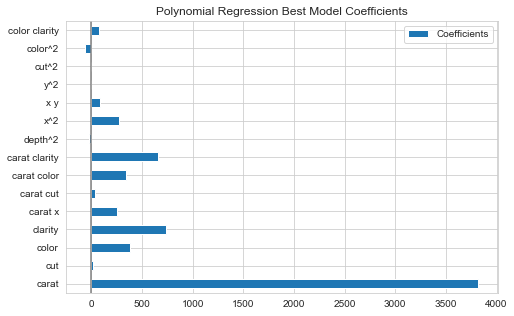

In [98]:
coefs_df[coefs_df.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [99]:
coefs_df['coef_absolute'] = coefs_df.Coefficients.apply(lambda x: abs(x))
coefs_df[coefs_df.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

carat     clarity  carat clarity       color  \
Coefficients   3819.165766  736.942242     658.568956  379.512189   
coef_absolute  3819.165766  736.942242     658.568956  379.512189   

               carat color         x^2    carat x        x y  color clarity  \
Coefficients    340.220949  272.697483  255.50225  83.223653      79.471302   
coef_absolute   340.220949  272.697483  255.50225  83.223653      79.471302   

                 color^2  carat cut    depth^2        cut     cut^2      y^2  
Coefficients  -58.635986  36.487862 -25.612413  19.424984 -5.943162 -0.96111  
coef_absolute  58.635986  36.487862  25.612413  19.424984  5.943162  0.96111

From the coefficients, we can see that Lasso assigns 0 to many of the features and only small number of them have non-zero coefficients.
Within the most salient features, the most important one is carat with the biggest coefficient 3819.17. This means the increase in price is positively correlated with the carat coefficient. Clarity is the second most important feature followed by compound carat clarit feature, color, carat color, x^2 and carat x. Color^2, depth^2, cut^2 and y^2 also has negative correlation with diamond price. Decreasing either one of them leads to increase the price.
The coefficient values also matter, the bigger the absolute coefficient value means the bigger impact it has on the target variable (pricing the diamond), the more important the feature in terms of predicting the target variable. 

##### __Gas Data__

In [100]:
 grid_search_poly_gas, grid_res_poly_df_gas = polynomial_feat_linear_model_exp(X=X_gas, y=y_gas, cv=10,
                                                                       data_name='gas', search_type='grid')


##### __Polynomial Regression Experiment Results__

Top 10 hyperparameter combination results based on based mean validation score. From the below table, the best combinations 10-fold avg train RMSE: 5.72  avg validation RMSE:  7.15 which are way better than the Linear Regression results which were around 8.1-8.76 RMSE results for both metrics.

In [101]:
show_cols =['mean_train_score','mean_validation_score','param_model','param_model__alpha','param_poly_features__degree']
grid_res_poly_df_gas[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  \
35          5.719778               7.155798   
34          5.827271               7.171435   
22          5.508430               7.226445   
23          5.273528               7.369680   
33          6.246073               7.436532   
18          5.682998               7.459753   
21          6.055840               7.464865   
19          5.119546               7.514624   
20          4.895412               7.588859   
31          5.156848               7.655462   

                           param_model  param_model__alpha  \
35  Lasso(alpha=0.1, random_state=142)                0.10   
34  Lasso(alpha=0.1, random_state=142)                0.10   
22             Ridge(random_state=142)             1000.00   
23             Ridge(random_state=142)             1000.00   
33  Lasso(alpha=0.1, random_state=142)                0.10   
18             Ridge(random_state=142)              100.00   
21             Ridge(random_state=142)             1000.00   
19             Ridge(random_state=142)              100.00   
20             Ridge(random_state=142)              100.00   
31  Lasso(alpha=0.1, random_state=142)                0.01   

    param_poly_features__degree  
35                            4  
34                            3  
22                            3  
23                            4  
33                            2  
18                            2  
21                            2  
19                            3  
20                            4  
31                            3

__Best model found from GridSearch:__

The best model is Lasso with alpha 0.1 and PolynomialFeatures set with degree 4. alpha 0.1 with degree 3 is also the second best result where the validation scores of both options are very close to each other.

In [102]:
best_model_poly_gas = grid_search_poly_gas.best_estimator_
print('Best Model:',best_model_poly_gas)
print('Best Model Params:',grid_search_poly_gas.best_params_)

Best Model: Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=4, interaction_only='False')),
                ('model', Lasso(alpha=0.1, random_state=142))])
Best Model Params: {'model': Lasso(alpha=0.1, random_state=142), 'model__alpha': 0.1, 'poly_features': PolynomialFeatures(degree=4, interaction_only='False'), 'poly_features__degree': 4}


###### __Coefficient of the best model and Most Salient Features:__

Since the selected best model is with Lasso Regularization, we can see that most of the features have 0 coefficients.

In [103]:
best_model_poly_gas = grid_search_poly_gas.best_estimator_
feature_names_gas = best_model_poly_gas['poly_features'].get_feature_names_out()

coefs_df_gas = pd.DataFrame(
    best_model_poly_gas['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_gas,
)
coefs_df_gas

Coefficients
1                     0.000000
AT                   -8.175731
AP                   -0.380350
AH                   -2.069612
AFDP                  0.000000
...                        ...
TIT TAT TEY CDP       0.000000
TIT TAT TEY year     -0.000000
TIT TAT CDP year     -0.000000
TIT TEY CDP year      0.000000
TAT TEY CDP year     -0.168597

[386 rows x 1 columns]

Lasso Regression assigns 0 values to coefficients as seen above, to understand salient features better, I plotted the non-zero coefficients only.

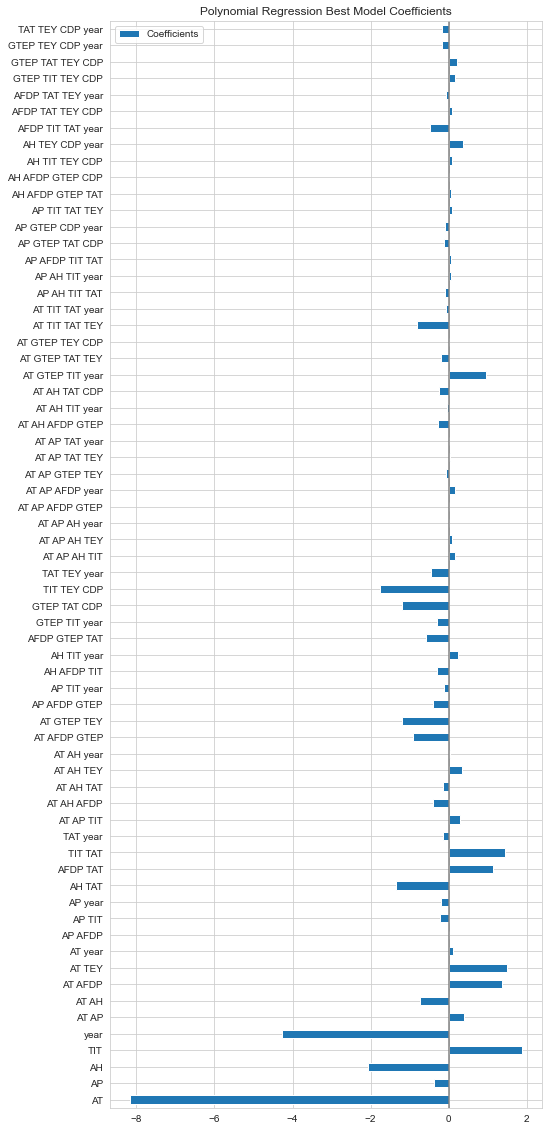

In [104]:
coefs_df_gas[coefs_df_gas.Coefficients!=0].plot(kind="barh", figsize=(10, 20))
plt.title("Polynomial Regression Best Model Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [105]:
coefs_df_gas['coef_absolute'] = coefs_df_gas.Coefficients.apply(lambda x: abs(x))
coefs_df_gas[coefs_df_gas.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

AT      year        AH       TIT  TIT TEY CDP    AT TEY  \
Coefficients  -8.175731 -4.280409 -2.069612  1.888307    -1.751613  1.498123   
coef_absolute  8.175731  4.280409  2.069612  1.888307     1.751613  1.498123   

                TIT TAT   AT AFDP    AH TAT  GTEP TAT CDP  ...  \
Coefficients   1.444971  1.357626 -1.338949     -1.195913  ...   
coef_absolute  1.444971  1.357626  1.338949      1.195913  ...   

               AH AFDP GTEP TAT  AT AH TIT year  AT AH year  AT AP TAT TEY  \
Coefficients           0.048713       -0.047831     0.03267       0.030092   
coef_absolute          0.048713        0.047831     0.03267       0.030092   

               AH AFDP GTEP CDP  AT AP AFDP GTEP  AT AP AH year  \
Coefficients          -0.023979           0.0165        0.01368   
coef_absolute          0.023979           0.0165        0.01368   

               AT GTEP TEY CDP   AP AFDP  AT AP TAT year  
Coefficients          0.008394  0.005628        0.002765  
coef_absolute         0.008394  0.005628        0.002765  

[2 rows x 66 columns]

In [106]:
print('Total coefficient counts:',coefs_df_gas.shape[0])
print('Zero coefficient counts:',coefs_df_gas[coefs_df_gas.Coefficients==0].shape[0])

Total coefficient counts: 386
Zero coefficient counts: 320


From the coefficients, we can see that Lasso assigns 0 to many of the features and only small number of them have non-zero coefficients. 320 out of 386 possible coefficients assigned 0 values.

Within the most salient features, the most important one is AT with -8.17, showcasing negative correlation. This is followed by year and AH with smaller negative correlations. TIT has positive correlation. The first 4 highest correlation values given to non-compounda features and then the most of the remaining non-zero coefficients (the biggest absolute ones) seem to be given to the compound features.

#### Question 13

The experiment is done for degrees 2, 3, and 4. Given that degree=1 would be just linear results, and we want to see the results for polynomial features, I omitted degree=1 in the experiment. I also didn't include degrees higher than 4 because given the dataset, the amount of compound features created would be too much with degrees higher than 5. Another reason is that both dataset are relatively small 30-50k samples, very high degrees would more likely to cause overfit rather then help generalizing the model.  

##### __Diamonds Data__


__What degree of polynomial is best?__
From experiment results we can see that the best degree is 2. The first 9 of the top 10 combinations of our experiment shows that 2 is the best degree values anf Lasso is a better regularization for this dataset.

Best model parameters:

In [107]:
grid_search_poly.best_params_

{'model': Lasso(alpha=100, random_state=142),
 'model__alpha': 100,
 'poly_features': PolynomialFeatures(),
 'poly_features__degree': 2}

Top 10 combinations from gridsearch results sorted with lowest RMSE validation scores:

In [108]:
grid_res_poly_df[show_cols].sort_values(by='mean_validation_score', ascending=True).head(10)

mean_train_score  mean_validation_score  \
42        921.572213             882.226435   
39        782.419320            1129.772967   
36        763.272005            1615.358097   
21        795.955216            1667.221668   
24        757.769711            1777.435298   
27        757.769829            1777.748836   
30        757.771652            1780.882997   
45       1841.870944            1790.712541   
33        757.857294            1809.238839   
46       2023.787034            1902.183814   

                           param_model  param_model__alpha  \
42  Lasso(alpha=100, random_state=142)            100.0000   
39  Lasso(alpha=100, random_state=142)             10.0000   
36  Lasso(alpha=100, random_state=142)              1.0000   
21             Ridge(random_state=142)           1000.0000   
24  Lasso(alpha=100, random_state=142)              0.0001   
27  Lasso(alpha=100, random_state=142)              0.0010   
30  Lasso(alpha=100, random_state=142)              0.0100   
45  Lasso(alpha=100, random_state=142)           1000.0000   
33  Lasso(alpha=100, random_state=142)              0.1000   
46  Lasso(alpha=100, random_state=142)           1000.0000   

    param_poly_features__degree  
42                            2  
39                            2  
36                            2  
21                            2  
24                            2  
27                            2  
30                            2  
45                            2  
33                            2  
46                            3

##### __Gas Data__


__What degree of polynomial is best?__
From experiment results we can see that best degree chosen by gridsearch is 4. If we look at the top 10 combinations of best results from grid search in the below table, we can see that degree 3 is also a good choice, given that the mean validation score has only very little difference in the second significant digits. So, one can select degree 3 as the best parameter value as well.

Best model parameters:

In [109]:
grid_search_poly_gas.best_params_

{'model': Lasso(alpha=0.1, random_state=142),
 'model__alpha': 0.1,
 'poly_features': PolynomialFeatures(degree=4, interaction_only='False'),
 'poly_features__degree': 4}

Top 10 combinations from gridsearch results sorted with lowest RMSE validation scores:

In [110]:
grid_res_poly_df_gas[show_cols].sort_values(by='mean_validation_score', ascending=True).head(10)

mean_train_score  mean_validation_score  \
35          5.719778               7.155798   
34          5.827271               7.171435   
22          5.508430               7.226445   
23          5.273528               7.369680   
33          6.246073               7.436532   
18          5.682998               7.459753   
21          6.055840               7.464865   
19          5.119546               7.514624   
20          4.895412               7.588859   
31          5.156848               7.655462   

                           param_model  param_model__alpha  \
35  Lasso(alpha=0.1, random_state=142)                0.10   
34  Lasso(alpha=0.1, random_state=142)                0.10   
22             Ridge(random_state=142)             1000.00   
23             Ridge(random_state=142)             1000.00   
33  Lasso(alpha=0.1, random_state=142)                0.10   
18             Ridge(random_state=142)              100.00   
21             Ridge(random_state=142)             1000.00   
19             Ridge(random_state=142)              100.00   
20             Ridge(random_state=142)              100.00   
31  Lasso(alpha=0.1, random_state=142)                0.01   

    param_poly_features__degree  
35                            4  
34                            3  
22                            3  
23                            4  
33                            2  
18                            2  
21                            2  
19                            3  
20                            4  
31                            3

##### __What does a very high-order polynomial imply about the fit on the training data? How do you choose this parameter?__


With a higher-order polynomial, we can create more complex models that covers larger hypothesis spaces. With increasing model complexity, it means we can fit the data better, however, if the degree of polynomial is higher than the optimal degree that data lies, then model may overfit the data. In case of overfitting, the fitted curve will start to memorize the training data rather then learn to generalize and find patterns. When model overfits, the training error would be low and test/validation errors would be high since it perform badly on the unseen data. We can see this from the experiment results in the above table as well. For higher degrees we see that training errors (avg RMSEs) are very low but the avg. validation scores are very high compared to the training score. 

On the other hand, if the degree order is too small, the model cannot learn enough from the data and model can underfit resulting in high training and validation errors. 
In order to avoid overfitting or underfitting, and have a model that generalizes well, we need to choose a degree that matches with the true structure of the data. This happens when the the model has a good training score and the gap between the training and validation scores are lowest. One way to choosee optimal degree parameter, is to run cross validation with different degree values and compare the avg. training and validation results. Then choose a degree where model has low trainining RMSE and low test RMSE. The optimal point is generally when the model has low training RMSE and the gap beetween train and validation score is also lowest.

#### Question 14

__For the diamond dataset it might make sense to craft new features such as z = x1 × x2, etc. Explain why this might make sense and check if doing so will boost accuracy.__

Depending on some dataset a compound feature might make sense on predicting the target variable. For example, for the diamonds dataset the diamond price might be correlated with the diamond volume, and diamond volume can be represented by x*y*z. Using compounding features (combination of different features) might be more helpful in predicting target variable rather than individual columns by itself. There could be cases where individual feature might not contribute as much as a compound feature to the prediction. 

I tried 2 approaches to craft new features such as z= x1 x x2. 

Approach 1: Use interaction_only=True in Polynomial Features and run only for the combinations of different features. In this approach I created all possible interacted features and checked whether any of them are important features. 

Approach 2: Create craft features by hand for the combinations that makes sense and could be helpful for prediction of target variable:

For diamonds dataset new hand crafted features:

    - volume of diamond: x * y * z
    - table * depth
    - density of diamond: carat / (x*y*z)
    
In the results below saw that approach 1 helped us improve the accuracy. Approach 2 by adding only few selected hand-crafted features, instead of the regular features worsen the accuracy.


###### __Approach 1: Polynomial Feature on Interactions only__

I applied a randomized search with 12 samples (n_iter) with the same parameter range on q12, but this time I only used the compound features to feed in the linear model. I did 10-fold cv and Lasso, Ridge Regularizations.

In [111]:
grid_search_poly_interaction_only, grid_res_poly_inter_only_df = polynomial_feat_linear_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                                                       data_name='diamonds', interaction_only=True,
                                                                       search_type='grid', rerun=False,
                                                                       post_fix='interaction_only')
    
    

Polynomial Feature Interaction Only features experiment results on top 10 combination:

In [112]:
grid_res_poly_inter_only_df[show_cols].sort_values(by=['mean_validation_score']).head(10)

mean_train_score  mean_validation_score  \
39        805.512807             813.970583   
40        679.765887             825.384492   
42        927.309710             873.199024   
21        811.508988             874.116912   
41        647.222578             883.514943   
43        874.565986             900.154033   
44        859.818400             937.391952   
22        683.784705            1067.001516   
23        647.120971            1101.171040   
18        789.987240            1108.538274   

                          param_model  param_model__alpha  \
39  Lasso(alpha=10, random_state=142)                10.0   
40  Lasso(alpha=10, random_state=142)                10.0   
42  Lasso(alpha=10, random_state=142)               100.0   
21            Ridge(random_state=142)              1000.0   
41  Lasso(alpha=10, random_state=142)                10.0   
43  Lasso(alpha=10, random_state=142)               100.0   
44  Lasso(alpha=10, random_state=142)               100.0   
22            Ridge(random_state=142)              1000.0   
23            Ridge(random_state=142)              1000.0   
18            Ridge(random_state=142)               100.0   

    param_poly_features__degree  
39                            2  
40                            3  
42                            2  
21                            2  
41                            4  
43                            3  
44                            4  
22                            3  
23                            4  
18                            2

The avg 10-fold CV Train RMSE:805.51 and Validation RMSE=813.97 with interaction only features are much better then the Q12-13 results. This results the performances of the models.

In [113]:
print('Best model:\n',grid_search_poly_interaction_only.best_estimator_)
print('Best model parameters:\n',grid_search_poly_interaction_only.best_params_)

Best model:
 Pipeline(steps=[('poly_features', PolynomialFeatures(interaction_only=True)),
                ('model', Lasso(alpha=10, random_state=142))])
Best model parameters:
 {'model': Lasso(alpha=10, random_state=142), 'model__alpha': 10, 'poly_features': PolynomialFeatures(interaction_only=True), 'poly_features__degree': 2}


__The coefficients of the best found model with polynomial interactions only features (non-zero coeffs only):__

In [114]:
best_model_poly_interaction = grid_search_poly_interaction_only.best_estimator_
feature_names_inter = best_model_poly_interaction['poly_features'].get_feature_names_out()

coefs_df_inter = pd.DataFrame(
    best_model_poly_interaction['model'].coef_,
    columns=["Coefficients"],
    index=feature_names_inter,
)
coefs_df_inter[coefs_df_inter.Coefficients!=0]

Coefficients
carat           4034.341806
table            -32.671368
cut               93.303139
color            557.804933
clarity          918.785316
carat depth     -163.438333
carat table      -19.371410
carat x          384.641881
carat cut        101.794631
carat color      582.467856
carat clarity    937.881468
depth table       23.574794
depth y          173.265004
depth cut         29.052115
table clarity     -6.953471
x y              298.472237
x z              164.424270
x clarity         -3.652150
y z              -22.220218
y color           44.728856
cut color         12.634970
cut clarity        4.550465
color clarity    321.181135

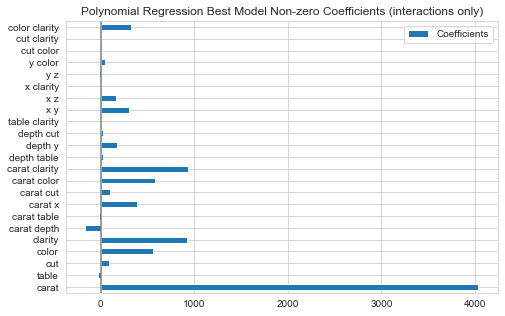

In [115]:
coefs_df_inter[coefs_df_inter.Coefficients!=0].plot(kind="barh", figsize=(10, 5))
plt.title("Polynomial Regression Best Model Non-zero Coefficients (interactions only)")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Non-zero Coefficients ordered from highest to lowest absolute coefficient values:

In [116]:
coefs_df_inter['coef_absolute'] = coefs_df_inter.Coefficients.apply(lambda x: abs(x))
coefs_df_inter[coefs_df_inter.Coefficients!=0].sort_values(by='coef_absolute', ascending=False).T

carat  carat clarity     clarity  carat color  \
Coefficients   4034.341806     937.881468  918.785316   582.467856   
coef_absolute  4034.341806     937.881468  918.785316   582.467856   

                    color     carat x  color clarity         x y     depth y  \
Coefficients   557.804933  384.641881     321.181135  298.472237  173.265004   
coef_absolute  557.804933  384.641881     321.181135  298.472237  173.265004   

                     x z  ...    y color      table  depth cut  depth table  \
Coefficients   164.42427  ...  44.728856 -32.671368  29.052115    23.574794   
coef_absolute  164.42427  ...  44.728856  32.671368  29.052115    23.574794   

                     y z  carat table  cut color  table clarity  cut clarity  \
Coefficients  -22.220218    -19.37141   12.63497      -6.953471     4.550465   
coef_absolute  22.220218     19.37141   12.63497       6.953471     4.550465   

               x clarity  
Coefficients    -3.65215  
coef_absolute    3.65215  

[2 rows x 23 columns]

We can see that the most important features are very similar as in Q12-Q13, however the model is only using the compounds of different features now. 

###### __Approach 2.1: Hand-crafted features - Option 1- create compound features from raw data and then scale__

In this approach I only hand crafted new feature set. The process is I created the features from raw data and then scaled the. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [120]:
# create new features: Option 1- create from raw data and then scale
diamonds_new_feat_df = diamonds_df.copy()
diamonds_new_feat_df['x*y*z'] = diamonds_new_feat_df['x']*diamonds_new_feat_df['y']*diamonds_new_feat_df['z']
diamonds_new_feat_df['table*depth'] = diamonds_new_feat_df['table']*diamonds_new_feat_df['depth']
diamonds_new_feat_df['density'] = diamonds_new_feat_df['carat']/ (diamonds_new_feat_df['x*y*z'])
diamonds_new_feat_df['density'] = diamonds_new_feat_df['density'].apply(lambda x: 0 if x==np.Inf else x)
diamonds_new_num_cols = ['carat', 'x','y','z','table','depth', 'x*y*z','table*depth', 'density' ]
diamonds_new_feat_df = feature_transformer(data=diamonds_new_feat_df, 
                                                numeric_feats=diamonds_new_num_cols, 
                                                categ_feats=diamonds_cat_cols,
                                                categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df.head())
diamonds_new_feat_df.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth   density  
1 -1.587837 -1.536196 -1.571129 -1.171294    -1.188533 -0.489328  
2 -1.641325 -1.658774 -1.741175 -1.218533     0.728291 -0.183160  
3 -1.498691 -1.457395 -1.741175 -1.172894     1.094605 -0.396553  
4 -1.364971 -1.317305 -1.287720 -1.062372     0.521653  0.382562  
5 -1.240167 -1.212238 -1.117674 -0.996008     0.898804 -0.721797

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth       density  
count  5.394000e+04  5.394000e+04  5.394000e+04  
mean   3.161480e-16 -1.559664e-16 -5.342639e-15  
std    1.000009e+00  1.000009e+00  1.000009e+00  
min   -1.659533e+00 -8.850773e+00 -2.871741e+01  
25%   -8.270555e-01 -7.116750e-01 -3.601900e-01  
50%   -1.922285e-01 -9.681727e-02 -3.771660e-02  
75%    5.239094e-01  6.054644e-01  3.051422e-01  
max    4.742502e+01  1.603977e+01  7.746588e+01

In [121]:
features_q14= [
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table','depth', 'cut', 'color', 'clarity', 'density'],
    ['carat', 'x','y','z','table','depth', 'cut', 'color', 'clarity', 'x*y*z', 'table*depth','density']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed) 
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.257425103957
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.9244651005379


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1250.9522429042684
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.883579227349


Results for features:  ['carat', 'x', 'y', 'z', 'table', 'depth', 'cut', 'color', 'clarity', 'density']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2749901090597
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8990105660093


Results for features:  ['carat', 'x', 'y', 'z', 'table', 'depth', 'cut', 'color', 'clarity', 'x*y*z', 'table*depth', 'density']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.0241173671452
Lasso with new fe

By only using these 3 crafted features doesn't really help with the model performance, it rather detoriates.

###### __Approach 2.2: Hand-crafted features - Option 2- create compound features from scaled data__

In this approach I only hand crafted new feature set. The process is I created the features from scaled data directly. Then I checked the results on best found model and its parameters in Question 12 to see if the model performance is improved. Lasso Regression with 100 alpha is used:

In [123]:
# create new features: Option 2- create from scaled data 
fs= [ 'x','y','z','table','depth']
diamonds_new_feat_df2 = diamonds_df.copy()
diamonds_new_feat_df2[fs] = diamonds_prep_df[fs]
diamonds_new_feat_df2['x*y*z'] = diamonds_new_feat_df2['x']*diamonds_new_feat_df2['y']*diamonds_new_feat_df2['z']
diamonds_new_feat_df2['table*depth'] = diamonds_new_feat_df2['table']*diamonds_new_feat_df2['depth']
diamonds_new_num_cols2 = ['carat', 'x*y*z','table*depth' ]
diamonds_new_feat_df2 = feature_transformer(data=diamonds_new_feat_df2, 
                                                numeric_feats=diamonds_new_num_cols2, 
                                                categ_feats=diamonds_cat_cols,
                                                categs_order=diamonds_categs_order,
                                                scale=True)
display(diamonds_new_feat_df2.head())
diamonds_new_feat_df2.describe()

carat       cut     color   clarity     depth     table  price  \
1 -1.198168  0.981473  0.937163 -1.245215 -0.174092 -1.099672    330   
2 -1.240361  0.085889  0.937163 -0.638095 -1.360738  1.585529    327   
3 -1.198168 -1.705279  0.937163  0.576145 -3.385019  3.375663    328   
4 -1.071587  0.085889 -1.414272 -0.030975  0.454133  0.242928    337   
5 -1.029394 -1.705279 -2.002131 -1.245215  1.082358  0.242928    338   

          x         y         z     x*y*z  table*depth  
1 -1.587837 -1.536196 -1.571129 -1.011985     0.331656  
2 -1.641325 -1.658774 -1.741175 -1.231300    -1.267281  
3 -1.498691 -1.457395 -1.741175 -1.004910    -7.576892  
4 -1.364971 -1.317305 -1.287720 -0.645658     0.276436  
5 -1.240167 -1.212238 -1.117674 -0.492275     0.380321

carat           cut         color       clarity         depth  \
count  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04  5.394000e+04   
mean   2.444878e-16  1.454281e-16  1.338360e-16 -8.114467e-17 -3.996902e-15   
std    1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00  1.000009e+00   
min   -1.261458e+00 -2.600864e+00 -2.002131e+00 -1.852335e+00 -1.308760e+01   
25%   -8.395232e-01 -8.096951e-01 -8.264134e-01 -6.380951e-01 -5.231053e-01   
50%   -2.066210e-01  8.588908e-02 -2.385547e-01 -3.097505e-02  3.531678e-02   
75%    5.106683e-01  9.814733e-01  9.371628e-01  5.761450e-01  5.239361e-01   
max    8.886075e+00  9.814733e-01  1.525021e+00  2.397505e+00  1.204139e+01   

              table         price             x             y             z  \
count  5.394000e+04  53940.000000  5.394000e+04  5.394000e+04  5.394000e+04   
mean   9.695207e-17   3934.801557  2.782103e-16 -8.430615e-17 -2.002271e-16   
std    1.000009e+00   3989.442321  1.000009e+00  1.000009e+00  1.000009e+00   
min   -6.470073e+00    327.000000 -5.109120e+00 -5.020931e+00 -5.014556e+00   
25%   -6.521385e-01    952.000000 -9.103248e-01 -8.882800e-01 -8.909461e-01   
50%   -2.046051e-01   2403.000000 -2.777553e-02 -2.147398e-02 -1.237618e-02   
75%    6.904618e-01   5327.250000  7.210542e-01  7.052421e-01  7.103184e-01   
max    1.680167e+01  18823.000000  4.465203e+00  4.654965e+01  4.004758e+01   

              x*y*z   table*depth  
count  5.394000e+04  5.394000e+04  
mean   4.215307e-18 -2.357938e-17  
std    1.000009e+00  1.000009e+00  
min   -3.115138e+01 -2.494149e+01  
25%   -2.538809e-01 -9.321787e-02  
50%   -8.649803e-02  1.546745e-01  
75%   -7.972652e-03  3.096073e-01  
max    1.513640e+02  5.721680e+01

In [124]:
features_q14= [
    ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x','y','z', 'table*depth', 'cut', 'color', 'clarity'],
    ['carat', 'x*y*z', 'table','depth', 'cut', 'color', 'clarity']
]

for feat in features_q14:
    print('\n\nResults for features: ',feat)
    X_diamonds_new_feats= diamonds_new_feat_df2[feat]

    model_lr_q14 = Lasso(alpha=100, random_state=rand_seed)
    cv_results_lr_q14 = apply_cv_to_model(model=model_lr_q14, 
                                      X=X_diamonds_new_feats, y=y_diamonds, 
                                      model_name='Lasso with new features')



Results for features:  ['carat', 'x*y*z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x', 'y', 'z', 'table*depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2751638566913
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8986831815869


Results for features:  ['carat', 'x*y*z', 'table', 'depth', 'cut', 'color', 'clarity']
Lasso with new features Train Avg RMSE accross 10-fold cv:  1251.2749901090597
Lasso with new features Validation Avg RMSE accross 10-fold cv:  1244.8990105660093


The result of this approach is also similar to Approach 2.1. and it doesn't really help model improve.

## Neural Network

#### Question 15

For question 15, I ran a MLP model with the default parameters in sklearn (MLPRegressor). The default MLP model has 1 hidden layer with 100 neurons and activation function as relu, solver as adam. 


##### __Diamond Data__

From the below results we can see that Neural Network is performed much better. 


To compare the best result for linear model avg Train and Validation RMSE were around 1205-1206 and for polynomial regression was avg Train RMSE: 921.572213and Avg. Validation RMSE was: 882.226435.

In [125]:
model_nn =  MLPRegressor(random_state=rand_seed, max_iter=200)
cv_results_nn = apply_cv_to_model(model=model_nn, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='Neural Network',
                                  cv=10)

Neural Network Train Avg RMSE accross 10-fold cv:  777.6786147628094
Neural Network Validation Avg RMSE accross 10-fold cv:  747.3036406022716


In [126]:
print('Train RMSEs:', cv_results_nn['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_nn['test_score']*(-1.))

Train RMSEs: [820.08474187 809.08852109 788.44200593 726.8316636  614.1550364
 728.2570057  813.74382945 823.98262994 818.55573404 833.64497961]
Validation RMSEs:  [ 643.18346529  618.63124327  823.05710113 1144.74096698 1702.28150625
 1161.93618763  166.91549116  234.49500132  531.01778216  446.77766084]


##### __Gas Data__

From the below results we can see that Neural Network is performed much better. 

To compare the best result for linear model avg Train and Validation RMSE were around 8.1-8.76 and for polynomial regression was avg Train RMSE: 5.71 and Avg. Validation RMSE was: 7.15.


In [127]:
model_nn_gas =  MLPRegressor(random_state=rand_seed, max_iter=200)
cv_results_nn_gas = apply_cv_to_model(model=model_nn_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='Neural Network',
                                  cv=10)

Neural Network Train Avg RMSE accross 10-fold cv:  4.403767325900161
Neural Network Validation Avg RMSE accross 10-fold cv:  7.151286634532899


In [128]:
print('Train RMSEs:', cv_results_nn_gas['train_score']*(-1.))
print('Validation RMSEs: ', cv_results_nn_gas['test_score']*(-1.))

Train RMSEs: [4.47615828 4.5742852  4.48336537 4.5141129  4.21791965 4.17030782
 4.22640164 4.45268037 4.48474852 4.43769352]
Validation RMSEs:  [ 5.38507075  4.59652659  6.32313728  5.57556881 10.56163598  8.31752303
  9.66792933  6.62430684  6.91606435  7.54510338]


__Why does it do much better than linear regression?__

Neural networks can capture non-linear dependencies (with the help of activation functions such as relu) whereas linear models cannot. This means that neural network models have a larger hypothesis space to choose from including non-linear spaces and the complexity of the model is higher. Neural networks working better than linear regression suggest that for both of our dataset, its data has non-linear dependencies that help predicting the target variable. 

#### Question 16

__Adjust your network size (number of hidden neurons and depth), and weight decay
as regularization. Find a good hyper-parameter set systematically.__


There are different possibilities to systematically tune hyperparameters. To name a few we can use GridSearch, Randomized Search or HalvingGridSearchCV or HalvingRandomSearchCV from sklearn library. GridSearch is an exhaustive search of all parameter combinations, whereas Randomized Search sample from the all parameter combinations based on the sample number given by the user and conducts the search from that random sample. With many parameters and many candidates for each parameter, GridSearch takes a very long time to run. RandomizedSearch in that sense can be a good candidate to avoid long run times. 

HalvingSearch strategies is similar to GridSearch and RandomizedSearch but it applies succesive halving after every iteration and continues parameter search by halving the candidates after each iteration. The halving strategy is much faster but doesn't support for multiple scoring in sklearn, and for the next chapters, Random Forest part we are required to calculate multiple scores for the search results. In order to stay consistent on the parameter tuning techniques, I decided to go with Randomized Search with a good sample number, I can cover wider range of parameter combinations.

The hyperparameters tuned in this question are number of hidden neurons, number of hidden layers, and weight decay (alpha) parameters in the MLPRegressor object from sklearn. 

- Number of hidden layers: 1, 2, 3, 4    

- Number of hidden neurons: 30, 50, 100, 120

- The specific hidden_layer_sizes parameters used in the search: [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]

- Alpha values used in the range of $[10^{-5},10^3]$; with every 10 power range from -5 to 3 included.

I used Randomized Search with 100 samples and 10-fold cross validation due to the time it takes to train each combination.
The same search space is kept for both datasets.

In [129]:
def nn_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_nn_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_nn_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    hidden_layer_sizes_list = [(30,),(50,),(100,), (120,), (30,30), (50, 50), (50, 50, 50), (50,50,50,50)]
    alphas = [10**(x) for x in range(-5,4)] 
    
    params = {
        "model": [ MLPRegressor(random_state=rand_seed, max_iter=200, early_stopping=True)],
        "model__hidden_layer_sizes": hidden_layer_sizes_list,
        "model__alpha": alphas     
    }

    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

##### __Diamonds Data__

In [130]:
rand_search_nn, rand_res_nn_df = nn_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                               data_name='diamonds',
                                               search_type='randomized', n_iter=100, post_fix='iter_100_cv10')

__Neural Network Experiment Results__

After the parameter tuning, the model performed better than the default neural network parameters. 10-fold Mean Train RMSE is now 595.01 anf 10-fold validation RMSE is 637.48 for the best model parameter combination.

These RMSE metrics were around 750-780 with the default NN results in Q15.

Top 10 best combination results:

In [131]:
show_cols =['mean_train_score','mean_validation_score','param_model__alpha', 'param_model__hidden_layer_sizes']
rand_res_nn_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  param_model__alpha  \
53        595.010078             637.488677            10.00000   
45        601.467299             641.372646             1.00000   
29        616.363558             642.977524             0.01000   
61        593.316732             644.878249           100.00000   
21        620.648627             650.541119             0.00100   
5         626.699392             658.240621             0.00001   
37        603.151681             661.902062             0.10000   
69        598.967497             664.097029          1000.00000   
13        625.323358             667.144400             0.00010   
54        568.869844             684.246047            10.00000   

   param_model__hidden_layer_sizes  
53                        (50, 50)  
45                        (50, 50)  
29                        (50, 50)  
61                        (50, 50)  
21                        (50, 50)  
5                         (50, 50)  
37                        (50, 50)  
69                        (50, 50)  
13                        (50, 50)  
54                    (50, 50, 50)

In [132]:
print('Best Model:\n',rand_search_nn.best_estimator_)
print('Best Model Params:\n',rand_search_nn.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 MLPRegressor(alpha=10, early_stopping=True,
                              hidden_layer_sizes=(50, 50), random_state=142))])
Best Model Params:
 {'model__hidden_layer_sizes': (50, 50), 'model__alpha': 10, 'model': MLPRegressor(alpha=10, early_stopping=True, hidden_layer_sizes=(50, 50),
             random_state=142)}


Using 2 hidden layers each with 50 neurons, with alpha 10 further improved the performance of the Neural Network model results.

##### __Gas Data__

In [133]:
rand_search_nn_gas, rand_res_nn_df_gas = nn_model_exp(X=X_gas, y=y_gas, cv=10,
                                               data_name='gas',
                                               search_type='randomized', n_iter=100, post_fix='iter_100_cv10')

__Neural Network Experiment Results__

After the parameter tuning, the model performed better than the default neural network parameters. 
10-fold Mean Train RMSE is now 5.03 and 10-fold  validation RMSE is 6.33 for the best model parameter combination.

Top 10 best combination results:

In [134]:
show_cols =['mean_train_score','mean_validation_score','param_model__alpha', 'param_model__hidden_layer_sizes']
rand_res_nn_df_gas[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  param_model__alpha  \
50          5.034472               6.334995                10.0   
48          5.075886               6.339038                10.0   
51          4.979858               6.381388                10.0   
62          5.112718               6.396729               100.0   
61          5.437319               6.439728               100.0   
49          5.056675               6.479673                10.0   
63          4.915925               6.642107               100.0   
40          4.828005               6.730642                 1.0   
52          4.541026               6.769982                10.0   
53          4.509395               6.782365                10.0   

   param_model__hidden_layer_sizes  
50                          (100,)  
48                           (30,)  
51                          (120,)  
62                    (50, 50, 50)  
61                        (50, 50)  
49                           (50,)  
63                (50, 50, 50, 50)  
40                           (30,)  
52                        (30, 30)  
53                        (50, 50)

The best model parameter is 1 hidden layer with 100 neurons and alpha 10. Notice that the model can also found almost same 10-fold mean validation score with 1 hidden layer with 30 neuron size. 

In [135]:
print('Best Model:\n',rand_search_nn_gas.best_estimator_)
print('Best Model Params:\n',rand_search_nn_gas.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 MLPRegressor(alpha=10, early_stopping=True,
                              random_state=142))])
Best Model Params:
 {'model__hidden_layer_sizes': (100,), 'model__alpha': 10, 'model': MLPRegressor(alpha=10, early_stopping=True, random_state=142)}


#### Question 17

__What activation function should be used for the output?__

We want our output to be a numerical value as it is a regression task. The activation function could be identity (linear activation function), in this case the output will be linear output and the predicted result range will be from $-\infty$ to $\infty$. Another possible activation function could be ReLu, this will also return a numerical value but the range would be from 0 to $\infty$.

For diamonds data set since we are predicting price, therefore, it may be better to not allow negative range for the results and make it either zero or positive value. That is why we can use ReLU as activation. On another note, the price values on our data is all positive values with a minimum price 327. Therefore, using both linear output (no activation) and Relu would be possible in these two datasets.

For gas dataset as well, the target variable is again seems to be positive valued results, again we could use either of the activation functions.

sklearn MLPRegressor uses identity activation function as default, I kept using this in my experiments.


In [136]:
print('NN model output activation:', rand_search_nn.best_estimator_['model'].out_activation_)

NN model output activation: identity


#### Question 18

__What is the risk of increasing the depth of the network too far?__

Two possible things can happen if we increase the depth of network too far:
1. With the increase of depth, hidden layers, model complexity increases and the __model can overfit__ as wider hypothesis space is available to fit the train data. When model overfits, the train performance would be good, ie. low RMSe score however the validation and test scores would be bad since model cannot generalize well and predicts the unseen data badly.

2. Another possibility is the direct opposite, when the model layers increases, during back propagation the gradients of the loss function might approach to zero causing vanishing gradient problem. With vanishing gradient it gets harder for model to learn and train which leads to __model underfit__. When model underfits both train and validation performances would be bad, ie. very high RMSE scores.

We can check both training and testing loss curves during training to spot either of these problems is occuring. We can also check the cross validation results of train and test scores. 


Below two tables show the results for 1,2,3,4 hidden layers with each 50 neurons. The first table shows the mean_train_score values on different model alpha and hidden layer size. The second plot shows the mean_validation_scores.

For diamonds dataset, we can see that when we increase the number of hidden layers, depth of the model, the training RMSE decrease but validation RMSE increases, which shows the models start to overfit.

In [137]:
piv_df = rand_res_nn_df[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_train_score'], columns=['param_model__alpha'])
# ['(30,)','(50,)','(100,)', '(120,)', '(30, 30)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
reorderlist = ['(50,)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
piv_df.reindex(reorderlist)

mean_train_score                          \
param_model__alpha                    0.00001     0.00010     0.00100      
param_model__hidden_layer_sizes                                            
(50,)                                 860.387372  860.387160  860.386317   
(50, 50)                              626.699392  625.323358  620.648627   
(50, 50, 50)                          566.731348  566.014459  564.883705   
(50, 50, 50, 50)                      549.086232  545.684920  548.163076   

                                                                     \
param_model__alpha               0.01000     0.10000     1.00000      
param_model__hidden_layer_sizes                                       
(50,)                            860.392727  860.609681  862.323489   
(50, 50)                         616.363558  603.151681  601.467299   
(50, 50, 50)                     563.522269  566.650971  566.704099   
(50, 50, 50, 50)                 549.841766  551.695817  547.207621   

                                                                     
param_model__alpha               10.00000    100.00000   1000.00000  
param_model__hidden_layer_sizes                                      
(50,)                            868.732516  875.627936  885.655224  
(50, 50)                         595.010078  593.316732  598.967497  
(50, 50, 50)                     568.869844  570.243132  567.576103  
(50, 50, 50, 50)                 544.183427  549.337372  551.231189

In [138]:
piv_df = rand_res_nn_df[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_validation_score'], columns=['param_model__alpha'])
piv_df.reindex(reorderlist)

mean_validation_score                          \
param_model__alpha                         0.00001     0.00010     0.00100      
param_model__hidden_layer_sizes                                                 
(50,)                                      860.478273  860.475928  860.470553   
(50, 50)                                   658.240621  667.144400  650.541119   
(50, 50, 50)                               752.885226  740.185870  725.238640   
(50, 50, 50, 50)                           723.286306  748.312344  722.771248   

                                                                     \
param_model__alpha               0.01000     0.10000     1.00000      
param_model__hidden_layer_sizes                                       
(50,)                            860.489272  859.995527  863.376201   
(50, 50)                         642.977524  661.902062  641.372646   
(50, 50, 50)                     723.608246  736.513553  701.309009   
(50, 50, 50, 50)                 725.818526  725.074987  718.449520   

                                                                     
param_model__alpha               10.00000    100.00000   1000.00000  
param_model__hidden_layer_sizes                                      
(50,)                            855.726821  863.994765  873.184344  
(50, 50)                         637.488677  644.878249  664.097029  
(50, 50, 50)                     684.246047  699.210512  719.523413  
(50, 50, 50, 50)                 732.374139  704.885216  718.318497

For gas dataset, we can see that when we increase the number of hidden layers, depth of the model, the training RMSE decrease but validation RMSE increases for mos tof the cases as well.

In [139]:
piv_df = rand_res_nn_df_gas[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_train_score'], columns=['param_model__alpha'])
# display(piv_df)
# ['(30,)','(50,)','(100,)', '(120,)', '(30, 30)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
reorderlist = ['(50,)', '(50, 50)', '(50, 50, 50)', '(50, 50, 50, 50)']
piv_df.reindex(reorderlist)

mean_train_score                        \
param_model__alpha                    0.00001    0.00010    0.00100      
param_model__hidden_layer_sizes                                          
(50,)                                   4.637899   4.639643   4.636757   
(50, 50)                                4.090331   4.084285   4.100788   
(50, 50, 50)                            4.035329   4.009868   4.064147   
(50, 50, 50, 50)                        3.884436   3.972271   3.945383   

                                                                             \
param_model__alpha              0.01000    0.10000    1.00000    10.00000     
param_model__hidden_layer_sizes                                               
(50,)                             4.639676   4.648805   4.730151   5.056675   
(50, 50)                          4.131832   4.111577   4.100098   4.509395   
(50, 50, 50)                      4.057370   4.077180   4.136366   4.260865   
(50, 50, 50, 50)                  3.820922   3.899991   3.929041   4.118325   

                                                       
param_model__alpha              100.00000  1000.00000  
param_model__hidden_layer_sizes                        
(50,)                             6.481601   8.306890  
(50, 50)                          5.437319   7.097664  
(50, 50, 50)                      5.112718   6.680367  
(50, 50, 50, 50)                  4.915925   6.524656

In [140]:
piv_df = rand_res_nn_df_gas[show_cols]
piv_df = piv_df.pivot_table(index='param_model__hidden_layer_sizes', values=['mean_validation_score'], columns=['param_model__alpha'])
piv_df.reindex(reorderlist)

mean_validation_score                        \
param_model__alpha                         0.00001    0.00010    0.00100      
param_model__hidden_layer_sizes                                               
(50,)                                        6.901441   6.913977   6.891217   
(50, 50)                                     7.407305   7.326312   7.372348   
(50, 50, 50)                                 7.185461   7.107952   7.181652   
(50, 50, 50, 50)                             7.324528   7.220236   7.190370   

                                                                             \
param_model__alpha              0.01000    0.10000    1.00000    10.00000     
param_model__hidden_layer_sizes                                               
(50,)                             6.978835   6.891648   6.902512   6.479673   
(50, 50)                          7.296752   7.328153   7.298903   6.782365   
(50, 50, 50)                      7.120696   7.045864   7.335931   7.047754   
(50, 50, 50, 50)                  8.076287   7.410987   6.966002   6.986474   

                                                       
param_model__alpha              100.00000  1000.00000  
param_model__hidden_layer_sizes                        
(50,)                             7.384260   8.889102  
(50, 50)                          6.439728   7.945318  
(50, 50, 50)                      6.396729   7.607922  
(50, 50, 50, 50)                  6.642107   7.507126

## Random Forest

#### Question 19

##### __Diamond Data__

__Random Forest with default Parameters__

10-fold CV results with default random forest parameters:

In [141]:
model_rf =  RandomForestRegressor(random_state=rand_seed)
cv_results_rf = apply_cv_to_model(model=model_rf, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='RF',
                                  cv=10)

RF Train Avg RMSE accross 10-fold cv:  196.18467228232933
RF Validation Avg RMSE accross 10-fold cv:  752.9655008100951


In [142]:
def rf_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    fname = f'exp_results/{data_name}_rf_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_rf_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    max_feats = ['auto','sqrt','log2', None]  # 0.01, 0.05, 0.1, 0.2, 0.3
    max_depths = [2, 4, 6, 8, 10] + [None]
    n_estimators = [20*(x) for x in range(1,10)]

    params = {
        "model": [ RandomForestRegressor(random_state=rand_seed,
                                         oob_score=True, 
                                         n_jobs=-1)],
        "model__max_features": max_feats,
        "model__n_estimators": n_estimators,
        "model__max_depth": max_depths
          
    }
    scoring = {"RMSE": "neg_root_mean_squared_error", "R2": "r2"}
    
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring=scoring, fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

__Random Forest Parameter Tuning__

I applied 10-fold cross validation to tune parameters on grid search with the following parameters:

- Maximum number of Features: ['auto', 'sqrt', 'log2', None]

- Number of Trees: [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

- Depth of each tree: [2, 4, 6, 8, 10, None]


In [143]:
grid_search_rf, grid_res_rf_df = rf_model_exp(X=X_diamonds, y=y_diamonds, cv=10,
                                               data_name='diamonds',
                                               search_type='grid', post_fix='grid_cv10', verbose=10)

__RF Parameter tuning Top 10 Results:__

The best 10-fold avg train RMSE is 197 and avg validation RMSE is 715 which is much better than the values we found from default Random Forest parameter results.

The avg. validation RMSE is also better than linear and polynomial regression but worse than the Neural Network results.

The R^2 value for 10-fold avg train score is 0.9975 which is very high. The R^2 mean validation value is 0.644 which is on the lower side. 

In [144]:
grid_res_rf_df.rename(columns={'mean_test_R2': 'mean_validation_R2'}, inplace=True)
show_cols =['mean_train_RMSE','mean_validation_RMSE','mean_train_R2','mean_validation_R2','param_model__max_features', 'param_model__n_estimators','param_model__max_depth']
grid_res_rf_df[show_cols].sort_values(by='mean_validation_RMSE').head(50)


mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
194       197.555441            715.111659       0.997510            0.644635   
203       197.555441            715.111659       0.997510            0.644635   
197       195.954537            715.395773       0.997550            0.644536   
206       195.954537            715.395773       0.997550            0.644536   
196       196.395238            715.684125       0.997539            0.644486   
205       196.395238            715.684125       0.997539            0.644486   
195       196.904756            715.867991       0.997526            0.644543   
204       196.904756            715.867991       0.997526            0.644543   
202       198.482136            717.630609       0.997487            0.643213   
193       198.482136            717.630609       0.997487            0.643213   
192       199.762981            719.617363       0.997453            0.641107   
201       199.762981            719.617363       0.997453            0.641107   
191       202.270267            722.666892       0.997388            0.637716   
200       202.270267            722.666892       0.997388            0.637716   
190       208.128003            725.638959       0.997235            0.634496   
199       208.128003            725.638959       0.997235            0.634496   
189       222.139587            735.982273       0.996851            0.620411   
198       222.139587            735.982273       0.996851            0.620411   
186       194.958257            752.235459       0.997576            0.609886   
213       194.958257            752.235459       0.997576            0.609886   
215       193.993099            752.453645       0.997600            0.610169   
188       193.993099            752.453645       0.997600            0.610169   
214       194.450887            752.599328       0.997588            0.609425   
187       194.450887            752.599328       0.997588            0.609425   
185       195.540911            752.749529       0.997561            0.610399   
212       195.540911            752.749529       0.997561            0.610399   
184       196.184672            752.965501       0.997545            0.610654   
211       196.184672            752.965501       0.997545            0.610654   
210       197.143996            753.936606       0.997521            0.608289   
183       197.143996            753.936606       0.997521            0.608289   
209       199.413138            754.992440       0.997463            0.607944   
182       199.413138            754.992440       0.997463            0.607944   
181       203.469928            758.039056       0.997359            0.606954   
208       203.469928            758.039056       0.997359            0.606954   
207       213.876759            764.497469       0.997083            0.595430   
180       213.876759            764.497469       0.997083            0.595430   
178       477.861470            795.730562       0.985425            0.513149   
151       477.861470            795.730562       0.985425            0.513149   
150       477.999611            795.984716       0.985416            0.513514   
177       477.999611            795.984716       0.985416            0.513514   
179       477.656420            795.997041       0.985437            0.513704   
152       477.656420            795.997041       0.985437            0.513704   
148       477.977892            796.207996       0.985417            0.515027   
175       477.977892            796.207996       0.985417            0.515027   
174       478.143489            796.456064       0.985406            0.513371   
147       478.143489            796.456064       0.985406            0.513371   
173       479.012273            796.728609       0.985352            0.514150   
146       479.012273            796.728609       0.985352            0.514150   
176       478.007329            796.

The best parameter combination is max_features: 'sqrt', n_estimators=120,  max_depth=None

In [145]:
print('Best Model:\n',grid_search_rf.best_estimator_)
print('Best Model Params:\n',grid_search_rf.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 RandomForestRegressor(max_features='sqrt', n_estimators=120,
                                       n_jobs=-1, oob_score=True,
                                       random_state=142))])
Best Model Params:
 {'model': RandomForestRegressor(max_features='sqrt', n_estimators=120, n_jobs=-1,
                      oob_score=True, random_state=142), 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 120}


In [146]:
print('Best Model OOB score:\n',grid_search_rf.best_estimator_['model'].oob_score_)

Best Model OOB score:
 0.981448128437458


We can also decrease the number of trees as we can substantially improve computation time without loosing too much from performance as it can be seen from the above table.

It is also important to note that when we have max_depth=None we don't really put a regularization effect on trees, the depth of the trees could grow unlimited. Similarly, having max_features None has unlimited effect as well. I also checked the best parameter results when these values are not equal to None.
The best 10 results when we put limited on these parameters can be seen below table:

In [147]:
grid_res_rf_df['RMSE_gap'] = grid_res_rf_df['mean_validation_RMSE']- grid_res_rf_df['mean_train_RMSE']
grid_res_rf_df[grid_res_rf_df['param_model__max_depth'].notnull() & grid_res_rf_df['param_model__max_features'].notnull()][show_cols].sort_values(by='mean_validation_RMSE').head(10)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
151       477.861470            795.730562       0.985425            0.513149   
150       477.999611            795.984716       0.985416            0.513514   
152       477.656420            795.997041       0.985437            0.513704   
148       477.977892            796.207996       0.985417            0.515027   
147       478.143489            796.456064       0.985406            0.513371   
146       479.012273            796.728609       0.985352            0.514150   
149       478.007329            796.780021       0.985416            0.513816   
145       479.947083            799.428969       0.985294            0.513050   
144       482.037451            805.539223       0.985163            0.507270   
169       545.477495            819.380235       0.980995            0.491369   

    param_model__max_features  param_model__n_estimators  \
151                      auto                        160   
150                      auto                        140   
152                      auto                        180   
148                      auto                        100   
147                      auto                         80   
146                      auto                         60   
149                      auto                        120   
145                      auto                         40   
144                      auto                         20   
169                      log2                        160   

     param_model__max_depth  
151                    10.0  
150                    10.0  
152                    10.0  
148                    10.0  
147                    10.0  
146                    10.0  
149                    10.0  
145                    10.0  
144                    10.0  
169                    10.0

By looking these results we can say that the validation RMSE is much bigger and validation R^2 is worse compared to the previous results, however the RMSE gap between train and validation scores are considerably lower. Given the data doesn't have too much samples, it makes more sense to choose a parameter with lower depth and number of trees in order to avoid overfitting, if there is no marginal change in the mean_validation RMSE. However, I beleive that this data doesn't have too much predictive power over price of diamonds given that even the best tuning results can only reach mean_validation_R^2 of 0.644 only. 

##### __Gas Data__

__Random Forest with default Parameters__

10-fold CV results with default random forest parameters:

In [148]:
model_rf_gas =  RandomForestRegressor(random_state=rand_seed)
cv_results_rf_gas = apply_cv_to_model(model=model_rf_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='RF',
                                  cv=10)

RF Train Avg RMSE accross 10-fold cv:  1.3334385377542095
RF Validation Avg RMSE accross 10-fold cv:  7.033552307420598


__Random Forest Parameter Tuning__

I applied 10-fold cross validation to tune parameters on grid search with the following parameters:

- Maximum number of Features: ['auto', 'sqrt', 'log2', None]
- Number of Trees: [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
- Depth of each tree: [2, 4, 6, 8, 10, None]


In [149]:
grid_search_rf_gas, grid_res_rf_df_gas = rf_model_exp(X=X_gas, y=y_gas, cv=10,
                                               data_name='gas',
                                               search_type='grid', post_fix='grid_cv10', verbose=10)

__RF Parameter tuning Top 10 Results:__

The best 10-fold avg train RMSE is 1.34 and avg validation RMSE is 6.76 which is better than the values we found from default Random Forest parameter results.

The R^2 value for 10-fold avg train score is 0.987 which is very high. The R^2 mean validation value is 0.49 which is very low.

In [150]:
grid_res_rf_df_gas.rename(columns={'mean_test_R2': 'mean_validation_R2'}, inplace=True)
show_cols =['mean_train_RMSE','mean_validation_RMSE','mean_train_R2','mean_validation_R2','param_model__max_features', 'param_model__n_estimators','param_model__max_depth']
grid_res_rf_df_gas[show_cols].sort_values(by='mean_validation_RMSE').head(10)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
197         1.342304              6.762084       0.986713            0.496042   
206         1.342304              6.762084       0.986713            0.496042   
195         1.348743              6.762958       0.986585            0.495604   
204         1.348743              6.762958       0.986585            0.495604   
191         1.386028              6.762969       0.985832            0.496487   
200         1.386028              6.762969       0.985832            0.496487   
196         1.344213              6.763069       0.986675            0.495475   
205         1.344213              6.763069       0.986675            0.495475   
192         1.368713              6.764241       0.986183            0.496209   
201         1.368713              6.764241       0.986183            0.496209   

    param_model__max_features  param_model__n_estimators  \
197                      sqrt                        180   
206                      log2                        180   
195                      sqrt                        140   
204                      log2                        140   
191                      sqrt                         60   
200                      log2                         60   
196                      sqrt                        160   
205                      log2                        160   
192                      sqrt                         80   
201                      log2                         80   

     param_model__max_depth  
197                     NaN  
206                     NaN  
195                     NaN  
204                     NaN  
191                     NaN  
200                     NaN  
196                     NaN  
205                     NaN  
192                     NaN  
201                     NaN

The best parameter combination is max_features: 'sqrt', n_estimators=180,  max_depth=None

In [151]:
print('Best Model:\n',grid_search_rf_gas.best_estimator_)
print('Best Model Params:\n',grid_search_rf_gas.best_params_)

Best Model:
 Pipeline(steps=[('model',
                 RandomForestRegressor(max_features='sqrt', n_estimators=180,
                                       n_jobs=-1, oob_score=True,
                                       random_state=142))])
Best Model Params:
 {'model': RandomForestRegressor(max_features='sqrt', n_estimators=180, n_jobs=-1,
                      oob_score=True, random_state=142), 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 180}


In [152]:
print('Best Model OOB score:\n',grid_search_rf_gas.best_estimator_['model'].oob_score_)

Best Model OOB score:
 0.9024957564053923


However, if we check the mean validation scores we can considerably lower the n_estimators and limit the max_dept instead of None to have a better regularization for our dataset.

Decreasing the number of trees would substantially improve computation time without loosing too much from performance as it can be seen from the above table.

It is also important to note that when we have max_depth=None we don't really put a regularization effect on trees, the depth of the trees could grow unlimited. Similarly, having max_features None has unlimited effect as well. I also checked the best parameter results when these values are not equal to None.
The best 10 results when we put limited on these parameters can be seen below table:

In [153]:
grid_res_rf_df_gas['RMSE_gap'] = grid_res_rf_df_gas['mean_validation_RMSE']- grid_res_rf_df_gas['mean_train_RMSE']
grid_res_rf_df_gas[grid_res_rf_df_gas['param_model__max_depth'].notnull() & grid_res_rf_df_gas['param_model__max_features'].notnull()][show_cols].sort_values(by='mean_validation_RMSE').head(20)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
157         3.956339              6.830226       0.884513            0.488974   
166         3.956339              6.830226       0.884513            0.488974   
167         3.958495              6.845531       0.884387            0.487186   
158         3.958495              6.845531       0.884387            0.487186   
161         3.955860              6.847696       0.884537            0.487555   
170         3.955860              6.847696       0.884537            0.487555   
159         3.959350              6.849650       0.884343            0.487073   
168         3.959350              6.849650       0.884343            0.487073   
160         3.958734              6.851686       0.884376            0.487128   
169         3.958734              6.851686       0.884376            0.487128   
164         3.965165              6.858520       0.883993            0.486477   
155         3.965165              6.858520       0.883993            0.486477   
163         3.964615              6.868910       0.884006            0.484301   
154         3.964615              6.868910       0.884006            0.484301   
165         3.951748              6.873718       0.884779            0.483140   
156         3.951748              6.873718       0.884779            0.483140   
153         3.976980              6.932200       0.883312            0.475565   
162         3.976980              6.932200       0.883312            0.475565   
125         4.761402              6.978346       0.832739            0.472878   
134         4.761402              6.978346       0.832739            0.472878   

    param_model__max_features  param_model__n_estimators  \
157                      sqrt                        100   
166                      log2                        100   
167                      log2                        120   
158                      sqrt                        120   
161                      sqrt                        180   
170                      log2                        180   
159                      sqrt                        140   
168                      log2                        140   
160                      sqrt                        160   
169                      log2                        160   
164                      log2                         60   
155                      sqrt                         60   
163                      log2                         40   
154                      sqrt                         40   
165                      log2                         80   
156                      sqrt                         80   
153                      sqrt                         20   
162                      log2                         20   
125                      sqrt                        180   
134                      log2                        180   

     param_model__max_depth  
157                    10.0  
166                    10.0  
167                    10.0  
158                    10.0  
161                    10.0  
170                    10.0  
159                    10.0  
168                    10.0  
160                    10.0  
169                    10.0  
164                    10.0  
155                    10.0  
163                    10.0  
154                    10.0  
165                    10.0  
156                    10.0  
153                    10.0  
162                    10.0  
125                     8.0  
134                     8.0

By looking these results we can say that the validation RMSE is bigger by only 0.05 point and validation R^2 is 0.006 worse compared to the previous results. So without hurting our results too much we can decrease our selected parameter range to max_depth 10 with even around 40-60 n_estimators.

Given the data doesn't have too much samples, it makes more sense to choose a parameter with lower depth and number of trees in order to avoid overfitting, if there is no marginal change in the mean_validation RMSE. However, I beleive that this data doesn't have too much predictive power over  NOX given that even the best tuning results can only reach mean_validation_R^2 of around 0.49 only. 

__Explain how these hyper-parameters affect the overall performance?__ __Do some of them have regularization effect?__

__Maximum number of features:__ (max_features) Initially, increasing maximum number of features will help increasing the model performance. However, having too big max_features would lead the test/validation error to increase, even though training error keeps decreasing. This means model become prone to overfit with a high value of max_features. This value can be used to have regularization effect to avoid overfitting.


__Number of trees:__ (n_estimators) Increasing number of trees at first will help with the model performance, from 1 to optimal number of trees we can see a sharp increase on both training, validation and test scores (increase in cases like accuracy, or decrease in case of RMSE error). After certain number of points however, the scores will start to stabilize and plateaus and won't change much. Having more than optimal number of trees will increase the computation time but wouldn't degrade model performance much.


__Depth of each tree:__ (max_depth), is the longest path from root to leaf. If we increase the max depth too much, the trees can grow bigger and the training data would start to overfit after certain point, this will keep decreasing the training score. However, due to overfit, the model cannot generalize well on unseen test data and test score would increase. Hence, if we have too big maximum depth values, the model performance would start to degrade. Having very small max_depth on the other hand might cause underfitting, with low test and training score, again resulting in low performance. So we need to find an optimal value and fine tune this parameter carefully. We can create a regularization effect by decreasing the max_depth and avoid overfitting.



#### Question 20

__Why does random forest perform well?__

Random forest is an ensemble model using bagging method, this means we have multiple decision trees working as a group and final prediction is based on a majority vote instead of a decision of an individual tree. Having multiple trees help having a more robust, accurate model and reduce the variance of the model. Giving that the final predictions based on a majority vote, the final prediction result doesn't get affected from a wrong prediction of an (few) individual models because decisions is lead by the most common results. This helps Random Forest to use the power of multiple classifiers, reduce the prone to overfit and performs well.


#### Question 21

##### __Diamond Data:__

In [292]:
def select_random_tree(model):
    # select a tree with max depth 4
    for i in range(len(model.estimators_)):
        tree = model.estimators_[i]
        if tree.get_depth()==4:
            return tree
    return None

def plot_tree(selected_tree, X, data_name):
    # Export as dot file
    export_graphviz(selected_tree, out_file=f'tree_{data_name}.dot', 
                    max_depth = 4,
                    feature_names = X.columns,
                    rounded = True, 
                    proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    call(['dot', '-Tpng', f'tree_{data_name}.dot', '-o', f'tree_{data_name}.png']) #, '-Gdpi=300'])

    # Display in jupyter notebook
    from IPython.display import Image
    display(Image(filename = f'tree_{data_name}.png'))


For this question I created a model with max_depth 4, and the choose the remaining best parameters from the tuning results: when max_depth is 4, n_Estimators 60 and max_features='sqrt' have a good performance. Using higher n_estimators as it can be seen from the below table, doesn't effect the validation RMSE score too much, therefore it is a good tradeoff to have a lower n_estimators since it doesn't really hurt mean_validation RMSE. Although we can see that wiht max depth 4 results the RMSE results are much higher.

In [155]:
# choose the best parameter set with max depth 4.
grid_res_rf_df[grid_res_rf_df['param_model__max_depth']==4][show_cols].sort_values(by='mean_validation_RMSE').head(10)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
48      1112.695094           1301.492883       0.920427           -0.346200   
57      1112.695094           1301.492883       0.920427           -0.346200   
52      1117.987926           1301.746884       0.919694           -0.340928   
61      1117.987926           1301.746884       0.919694           -0.340928   
47      1110.161096           1302.317549       0.920779           -0.330555   
56      1110.161096           1302.317549       0.920779           -0.330555   
60      1118.652925           1302.485928       0.919572           -0.346775   
51      1118.652925           1302.485928       0.919572           -0.346775   
62      1118.107021           1302.533351       0.919667           -0.333305   
53      1118.107021           1302.533351       0.919667           -0.333305   

   param_model__max_features  param_model__n_estimators  \
48                      sqrt                         80   
57                      log2                         80   
52                      sqrt                        160   
61                      log2                        160   
47                      sqrt                         60   
56                      log2                         60   
60                      log2                        140   
51                      sqrt                        140   
62                      log2                        180   
53                      sqrt                        180   

    param_model__max_depth  
48                     4.0  
57                     4.0  
52                     4.0  
61                     4.0  
47                     4.0  
56                     4.0  
60                     4.0  
51                     4.0  
62                     4.0  
53                     4.0

In [156]:
model_rf_q21 =  RandomForestRegressor(random_state=rand_seed,
                                     max_features=5,
                                     n_estimators = 60 , 
                                     max_depth=4)
cv_results_rf_q21 = apply_cv_to_model(model=model_rf_q21, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='RF',
                                  cv=10)

RF Train Avg RMSE accross 10-fold cv:  1055.1147964059605
RF Validation Avg RMSE accross 10-fold cv:  1283.5570855502583


Then I select a tree with max depth 4 and plot it.

In [293]:
selected_tree = select_random_tree(model=cv_results_rf_q21['estimator'][0])
print('Selected tree\n:', selected_tree)

Selected tree
: DecisionTreeRegressor(max_depth=4, max_features=5, random_state=1726841109)


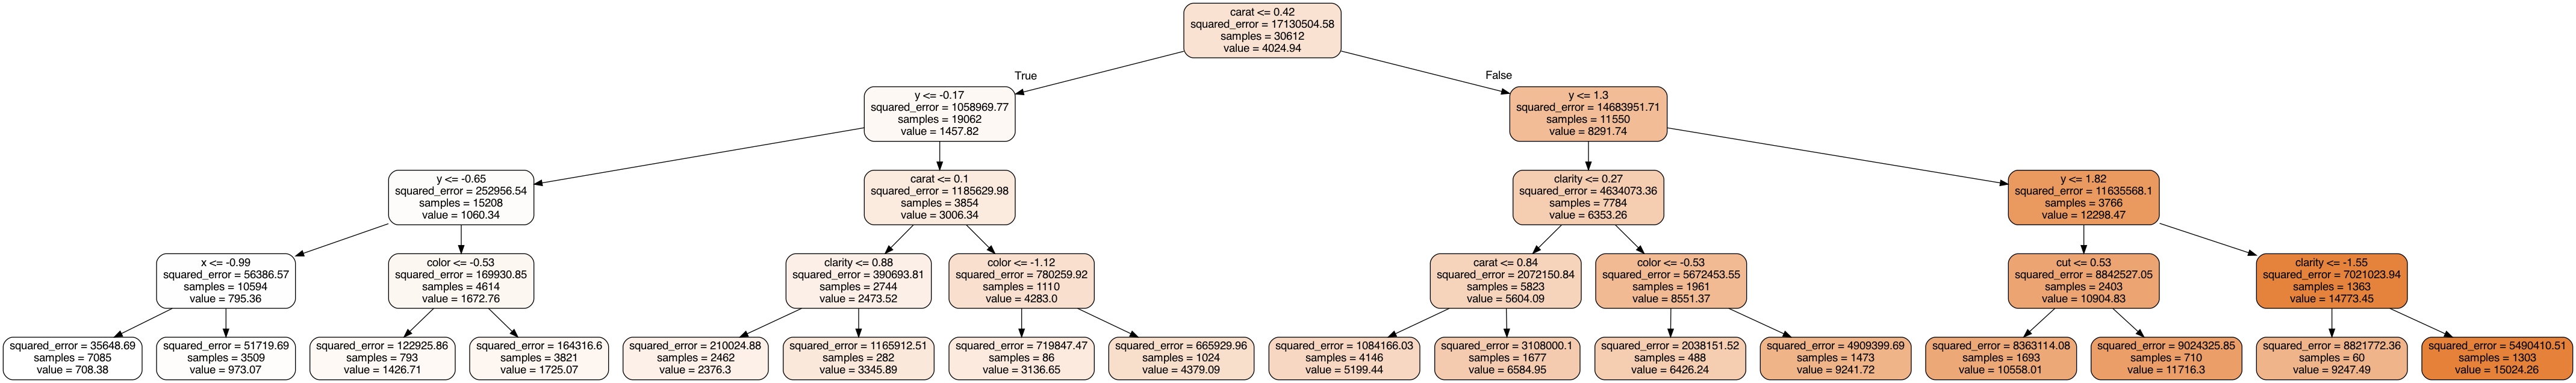

In [298]:
plot_tree(selected_tree=selected_tree, X=X_diamonds, data_name='diamonds')

__Which feature is selected for branching at the root node?__ 

Carat feature is selected as root node. This makes sense since until now, we kept finding carat is the most important feature to predicting price in the previous questions.

__What can you infer about the importance of features?__

For the splits of the branches: carat, x, y, clarity, color, cut features are selected, hence the features that are found to be important for this decision tree. The first split is made using carat feature and the standardized carat features lower than 0.42 goes to the left node and the rest goes to the right node, we can see that from almost 31K samples this decision splits the samples almost 2/3 to 1/3 for the next nodes, which means the feature is very imformative in terms of the being best split to separate samples. The most important feature is carat since it is used on the root node, then the the features used closer to the root are more informative, hence important features compared to the ones closer to leaf nodes.
The decision rules created by this tree can be clearly seen for each node and its corresponding feature. The split decisions are made based on the feature and its corresponding threshold where mean squared error is the most reduced. 

We can also observe that some features are used in several nodes and splits and chosen for new decision splits, such as carat, y, color this shows that these 3 features play more critical role for the final prediction of this specific tree.

 
__Do the important features match what you got in part 3.2.1?__

In the best model found after Linear Regression experiments, 3.2.1, the most important features were carat, x, clarity, color cut and depth in order.
According to the above decision tree, we can as well see that the important features found are very similar, the only difference y and depth and the rest of the most important features are same. 


##### __Gas Data:__

For this question I created a model with max_depth 4, and the choose the remaining best parameters from the tuning results: when max_depth is 4, n_Estimators 40 and max_features='sqrt' have a good performance. Using higher n_estimators as it can be seen from the below table, doesn't effect the validation RMSE score too much, therefore it is a good tradeoff to have a lower n_estimators since it doesn't really hurt mean_validation RMSE. Although we can see that wiht max depth 4 results the RMSE results are higher.

In [159]:
# choose the best parameter set with max depth 4.
grid_res_rf_df_gas[grid_res_rf_df_gas['param_model__max_depth']==4][show_cols].sort_values(by='mean_validation_RMSE').head(10)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2  \
57         6.788010              7.869215       0.660172            0.351490   
48         6.788010              7.869215       0.660172            0.351490   
55         6.817017              7.898831       0.657294            0.346900   
46         6.817017              7.898831       0.657294            0.346900   
49         6.809102              7.907231       0.658098            0.347655   
58         6.809102              7.907231       0.658098            0.347655   
59         6.808216              7.909413       0.658200            0.347542   
50         6.808216              7.909413       0.658200            0.347542   
60         6.811357              7.913407       0.657878            0.347506   
51         6.811357              7.913407       0.657878            0.347506   

   param_model__max_features  param_model__n_estimators  \
57                      log2                         80   
48                      sqrt                         80   
55                      log2                         40   
46                      sqrt                         40   
49                      sqrt                        100   
58                      log2                        100   
59                      log2                        120   
50                      sqrt                        120   
60                      log2                        140   
51                      sqrt                        140   

    param_model__max_depth  
57                     4.0  
48                     4.0  
55                     4.0  
46                     4.0  
49                     4.0  
58                     4.0  
59                     4.0  
50                     4.0  
60                     4.0  
51                     4.0

In [160]:
model_rf_q21_gas =  RandomForestRegressor(random_state=rand_seed,
                                     max_features=5,
                                     n_estimators = 40 , 
                                     max_depth=4)
cv_results_rf_q21_gas = apply_cv_to_model(model=model_rf_q21_gas, 
                                  X=X_gas, y=y_gas, 
                                  model_name='RF',
                                  cv=10)

RF Train Avg RMSE accross 10-fold cv:  6.535650579623966
RF Validation Avg RMSE accross 10-fold cv:  7.683507321594336


Then I select a tree with max depth 4 and plot it.

In [161]:
selected_tree_gas = select_random_tree(model=cv_results_rf_q21_gas['estimator'][0])
print('Selected tree\n:', selected_tree_gas)

Selected tree
: DecisionTreeRegressor(max_depth=4, max_features=5, random_state=1726841109)


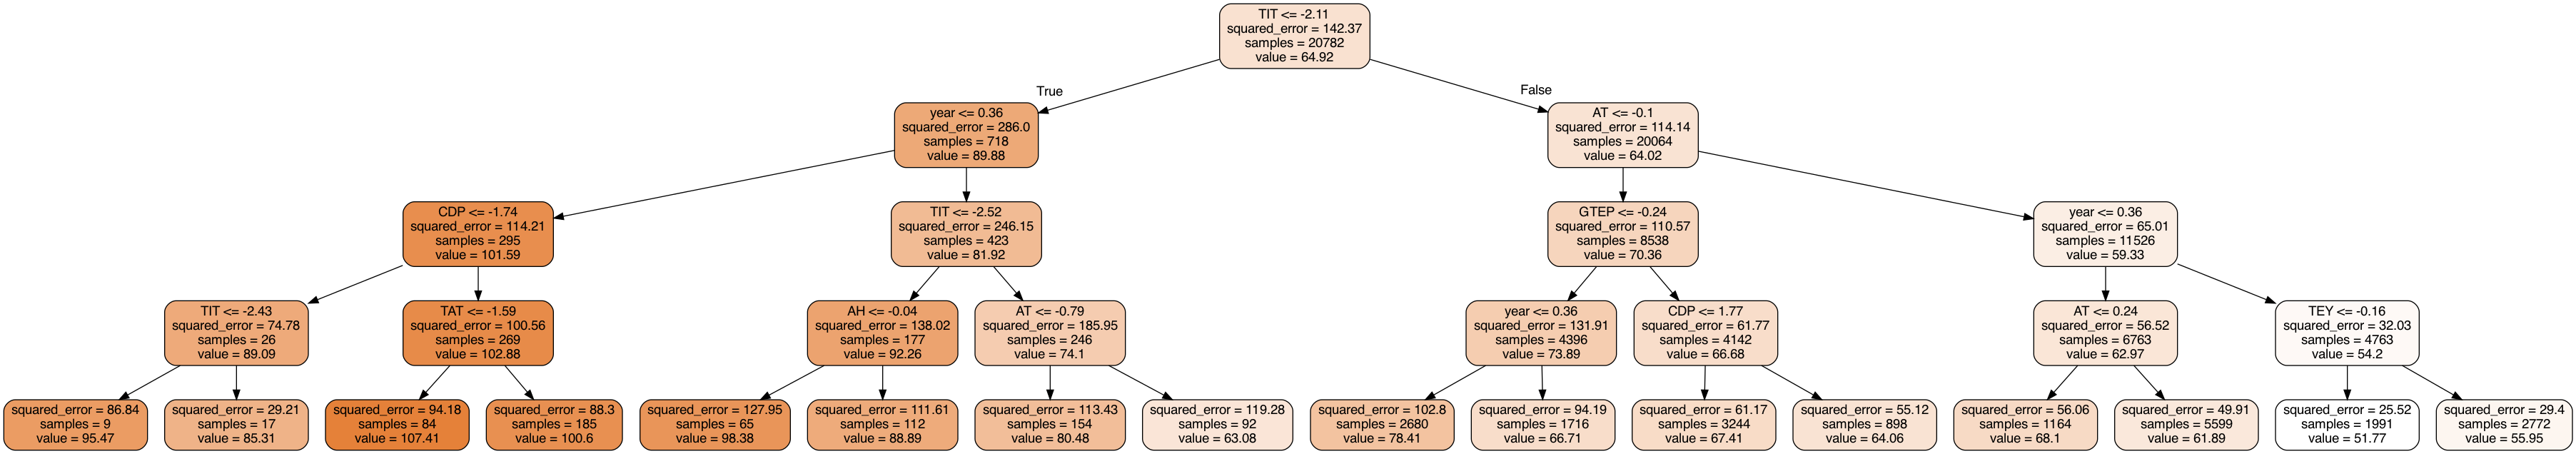

In [299]:
plot_tree(selected_tree=selected_tree_gas, X=X_gas, data_name='gas')

__Which feature is selected for branching at the root node?__ 

TIT feature is selected as root node. The split rule is checked TIT <=-2.11.

__What can you infer about the importance of features?__

For the splits of the branches: TIT, year, CDP, TAT, AH, AT, GTEP, TEY are used. These features are the features found to be the most important ones that is used to split samples. The most important feature is TIT since it is used on the root node, then the the features used closer to the root are more informative, hence important features compared to the ones closer to leaf nodes. We can also observe that some features are used in several nodes and splits and chosen for new decision splits, this shows that these features play more critical role for the final prediction of this specific tree.

 
__Do the important features match what you got in part 3.2.1?__

In the best model found after Linear Regression experiments, 3.2.1, the most important features were TEY, TIT, AT, TAT and AH in order.
According to the above decision tree, we can as well see that the important features found are very similar, in this case though TIT found to be more important than TEY since TIT is used as the root node.

## LightGBM, CatBoost and Bayesian Optimization

I picked the Diamonds dataset for this section:

#### Question 22

##### __LightGBM Parameters to tune__



LightGBM uses leaf-wise tree growth algorithm whereas many other tree algorithms use dept-wiswe tree growth. Leaf-wise algorithms have an advantage of converging faster but also more prone to overfitting if not used appropriatee parameters.

Parameters to tune:
- num_leaves: the parameter is the main one to control complexity of the model according to the documentation. It should be smaller than 2^(max_depth) to avoid overfittting.  
- min_data_in_leaf: this parameter helps prevent overfitting as well. The optimal value depends number of training samples and num_leaves. If it is large, it avoids growing too deep tree but also may cause underfitting. According to the documentation setting it in hundreds or thousands is enough for a large dataset. Since our datasets are smaller I will try values starting from 10 to 1000.
- max_depth: This parameter also limit tree depth, hence helps avoid overfitting.
 
There are also other parameters to use for better performance results suggested in the documentation: use large max_bin (may be slower), use small learning_rate with large num_iterations, use large num_leaves (may cause overfitting
) and try dart as boosting_type.

__My final set of parameters and the search space for LightGBM is:__
    
- num_leaves =  [2**(x) for x in range(4,8)]      

- min_data_in_leaf =  [10, 20, 50, 75, 100, 250, 500, 750, 1000]

- max_depth = [-1, 3, 4, 5, 6, 7, 8, 10, 20]

- boosting_type = ['gbdt', 'dart']

- n_estimators = [30, 50, 100, 150]

- num_iterations =  list(range(100, 301, 50))

- learning_rate = [0.1, 0.05, 0.01]


I decided the above search space range based on the documentation recommendations, further research on the internet and by taking into account my dataset and the samples in there (the number of samples are not big so I tried to keep some parameters smaller, or added smaller numbers as well to try to avoid overfitting).

Reference: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


##### __CatBoost Parameters to tune__

For catboost the important parameters to tune for this questions are:
- iterations: maximum number of trees that can be built
- learning_rate
- depth: Depth of the tree
- l2-leaf-reg: L2 regularization coefficient which is used for leaf value calculation.
- od-pval is threshold for overfitting detector, it is set to the recommended range in the documentation.
- random_strength: amount of randomness to use for scoring splits , it helps avoid overfitting,
- bagging_temperature: defines the settings of the Bayesian bootsrap,the higher the value the most aggressive bagging is.
- border_count: number of splits for the numerical features (its alias is max_bin)

I decided on these parameters after reading catboost documentation for parameter tuning part: https://catboost.ai/en/docs/concepts/parameter-tuning
For the search space for each parameter, I decided either based on the recommendation range in documenation or based on the dataset and number of samples I have in the diamonds dataset. 

__My final set of parameters and the search space for CatBoost is:__

- iterations: Integer(50, 300)
- learning_rate:  Real(0.01, 1.0, 'log-uniform')
- depth: Integer(4, 10)
- od-pval: Real(10e-10, 10e-2, 'log-uniform'), (is set to the recommended range in the documentation.)
- l2_leaf_reg': Integer(2, 20),
- random_strength': Real(1e-9, 10, 'log-uniform'),
- bagging_temperature': Real(0.0, 1.0),
- border_count': Integer(1, 255),



#### Question 23

__Apply Bayesian optimization using skopt.BayesSearchCV from scikit-optmize to search good hyperparameter combinations in your search space. Report the best hyperparameter found and the corresponding RMSE, for both algorithms.__

In this question I used the parameters and search spaces I defined for each of them to tune my parameters for LightGBM and CatBoost models.
I applied Bayesian optimization with  BayesSearchCV for 10-folds for both models. 

##### __LightGBM Results__

To be able to understand how much results are improved with parameter tuning, I also ran a 10-fold cross validation LightGBM with its default parameters.
The results are below, we can see that LightGBM is already performing way better than all the other models with its default values.

In [163]:
model_lgb =  lgb.LGBMRegressor(random_state=rand_seed, n_jobs=1)
cv_results_lgb = apply_cv_to_model(model=model_lgb, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='LightGBM',
                                  cv=10)

LightGBM Train Avg RMSE accross 10-fold cv:  466.01792200127346
LightGBM Validation Avg RMSE accross 10-fold cv:  657.5308021388921


In [164]:
def lgbm_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    model_name = 'lgbm'
    fname = f'exp_results/{data_name}_{model_name}_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_{model_name}_model{post_fix}.pkl'

    full_pipeline = Pipeline([ ('model', "passthrough") ])
    num_leaves = [2**(x) for x in range(4,9)] 
    min_data_in_leaf = [10, 20, 50, 75, 100, 250, 500, 750, 1000]
    max_depths = [-1, 3, 4, 5, 6, 7, 8, 10, 20]
    boosting_type = ['gbdt', 'dart']
    n_estimators = [30, 50, 100, 150]
    learning_rate = [0.1, 0.05, 0.01]

    params = {
        "model": [lgb.LGBMRegressor(random_state=rand_seed, n_jobs=1)], #, 
        "model__num_iterations": list(range(100, 301, 50)),
        "model__learning_rate": learning_rate,
        "model__n_estimators": n_estimators,
        "model__num_leaves": num_leaves,
        "model__min_data_in_leaf": min_data_in_leaf,
        "model__max_depth": max_depths,
        "model__boosting_type": boosting_type          
    }
    
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose)
    return grid_search, grid_results_df

__LightGBM Parameter Tuning Results__

For LightGBM 200 samples (n_iter=200) are choosen during BayesSearchCV and 10-fold cv is apploed, the parameters tuned can be seen from Q22. 
The top 10 best mean_validation_score score results are shown in the below table:

In [165]:
bayes_search_lgbm, bayes_results_lgbm_df = lgbm_model_exp(X=X_diamonds, y=y_diamonds, cv=10, 
                                               data_name='diamonds', n_iter=200,
                                               search_type='bayes', post_fix='cv_10_niter_200', verbose=10)

In [166]:
show_cols =['mean_train_score','mean_validation_score',
            "param_model__num_iterations", 'param_model__learning_rate', 
            "param_model__n_estimators", "param_model__num_leaves",
            'param_model__min_data_in_leaf','param_model__max_depth',
            "param_model__boosting_type"
           ]
bayes_results_lgbm_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  param_model__num_iterations  \
199        500.356272             599.345728                          300   
122        500.356272             599.345728                          300   
120        500.356272             599.345728                          300   
118        500.356272             599.345728                          300   
117        500.356272             599.345728                          300   
116        500.356272             599.345728                          300   
115        500.356272             599.345728                          300   
114        500.356272             599.345728                          300   
113        500.356272             599.345728                          300   
112        500.356272             599.345728                          300   

     param_model__learning_rate  param_model__n_estimators  \
199                         0.1                         50   
122                         0.1                         50   
120                         0.1                        150   
118                         0.1                         50   
117                         0.1                         50   
116                         0.1                         30   
115                         0.1                        100   
114                         0.1                         50   
113                         0.1                         50   
112                         0.1                         50   

     param_model__num_leaves  param_model__min_data_in_leaf  \
199                       64                             75   
122                       64                             75   
120                       32                             75   
118                       16                             75   
117                       32                             75   
116                       32                             75   
115                       64                             75   
114                       32                             75   
113                       32                             75   
112                       64                             75   

     param_model__max_depth param_model__boosting_type  
199                       4                       gbdt  
122                       4                       gbdt  
120                       4                       gbdt  
118                       4                       gbdt  
117                       4                       gbdt  
116                       4                       gbdt  
115                       4                       gbdt  
114                       4                       gbdt  
113                       4                       gbdt  
112                       4                       gbdt

With parameter tuning we can see that we reached even better results than the default parameter values. The mean train RMSE is around 500.35 and mean validation RMSE is around 599.34. These results are also way better than the models trained on diamonds dataset on the previous questions.

The best parameters found are:

- max depth = 4, 
- min_data_in_leaf=75,
- num_iterations=300,
- num_leaves=16,
- learning_rate=0.1,
- n_estimators = 100

The best parameters and estimator chosen by BayesSearchCV is shown below:

In [167]:
print('Best model: \n', bayes_search_lgbm.best_estimator_)
print('Best model parameters: \n', bayes_search_lgbm.best_params_)

Best model: 
 Pipeline(steps=[('model',
                 LGBMRegressor(max_depth=4, min_data_in_leaf=75, n_jobs=1,
                               num_iterations=300, num_leaves=16,
                               random_state=142))])
Best model parameters: 
 OrderedDict([('model', LGBMRegressor(max_depth=4, min_data_in_leaf=75, n_jobs=1, num_iterations=300,
              num_leaves=16, random_state=142)), ('model__boosting_type', 'gbdt'), ('model__learning_rate', 0.1), ('model__max_depth', 4), ('model__min_data_in_leaf', 75), ('model__n_estimators', 100), ('model__num_iterations', 300), ('model__num_leaves', 16)])


One thing we can notice is that we actually get same scores for different combinations in the top 10 best results. When I further explored I saw that this is the case for the best 100 experiment combination results. We can explain this as: after some the mean_validation_score starts to saturate and the model cannot learn more from the data. In this case it is better to choose the best parameter combinations by minimizing the computation time and/or by choosing some of the parameters that has better regularization effects.

Below table describes the parameter tuning that has thee best training and validation mean scores. For example, we can choose a best parameter combination wheren n_estimators could be as low as 30 and still can get same results or where param_model__num_leaves is as low as 16.


In [168]:
bayes_results_lgbm_df[(bayes_results_lgbm_df['mean_train_score']<=501) &
                      (bayes_results_lgbm_df['mean_validation_score']<=599.5)][show_cols].describe()

mean_train_score  mean_validation_score  param_model__num_iterations  \
count      1.010000e+02           1.010000e+02                        101.0   
mean       5.003563e+02           5.993457e+02                        300.0   
std        1.142539e-13           2.285077e-13                          0.0   
min        5.003563e+02           5.993457e+02                        300.0   
25%        5.003563e+02           5.993457e+02                        300.0   
50%        5.003563e+02           5.993457e+02                        300.0   
75%        5.003563e+02           5.993457e+02                        300.0   
max        5.003563e+02           5.993457e+02                        300.0   

       param_model__learning_rate  param_model__n_estimators  \
count                1.010000e+02                 101.000000   
mean                 1.000000e-01                  78.910891   
std                  2.789401e-17                  43.379742   
min                  1.000000e-01                  30.000000   
25%                  1.000000e-01                  50.000000   
50%                  1.000000e-01                  50.000000   
75%                  1.000000e-01                 100.000000   
max                  1.000000e-01                 150.000000   

       param_model__num_leaves  param_model__min_data_in_leaf  \
count               101.000000                          101.0   
mean                 36.910891                           75.0   
std                  20.457810                            0.0   
min                  16.000000                           75.0   
25%                  16.000000                           75.0   
50%                  32.000000                           75.0   
75%                  64.000000                           75.0   
max                  64.000000                           75.0   

       param_model__max_depth  
count                   101.0  
mean                      4.0  
std                       0.0  
min                       4.0  
25%                       4.0  
50%                       4.0  
75%                       4.0  
max                       4.0

##### __CatBoost Results__

To be able to understand how much results are improved with parameter tuning, I also ran a 10-fold cross validation CatBoost with its default parameters.
The results are below, we can see that CatBoost is now the best model for diamonds dataset compared to the all models we performed in this project even with its default values.

In [169]:
model_cb =  CatBoostRegressor(random_state=rand_seed, verbose=0)
cv_results_cb = apply_cv_to_model(model=model_cb, 
                                  X=X_diamonds, y=y_diamonds, 
                                  model_name='CatBoost',
                                  cv=10)

CatBoost Train Avg RMSE accross 10-fold cv:  427.7612680829581
CatBoost Validation Avg RMSE accross 10-fold cv:  551.9742619473776


In [170]:
def catboost_model_exp(X,y, data_name, search_type, cv=10, n_iter=10, rerun=False, post_fix='', verbose=0):
    model_name = 'catboost'
    fname = f'exp_results/{data_name}_{model_name}_model_exp{post_fix}.csv'
    model_file = f'exp_results/{data_name}_{model_name}_model{post_fix}.pkl'

    
    full_pipeline = Pipeline([ ('model', "passthrough") ])
    model = CatBoostRegressor(random_state=rand_seed,
                              loss_function='RMSE', 
                              eval_metric='RMSE', 
                              #use_best_model=True,
                              #cat_features=cat_features
                              verbose=0)
    params = {
        "iterations": Integer(50, 300),
        "depth": Integer(4, 10), 
        "od_pval": Real(10e-10, 10e-2, 'log-uniform'),
        "learning_rate": Real(0.01, 1.0, 'log-uniform'),
        "random_strength": Real(1e-9, 10, 'log-uniform'),
        "bagging_temperature": Real(0.0, 1.0),
        "border_count": Integer(1, 255),
        "l2_leaf_reg": Integer(2, 20)     
    }
 
    grid_search, grid_results_df = model_experiment(X=X, y=y, full_pipeline=full_pipeline, params=params,
                            scoring='neg_root_mean_squared_error', fname=fname, model_file=model_file, cv=cv,
                            rerun=rerun, search_type=search_type, n_iter=n_iter, verbose=verbose, model=model)
    return grid_search, grid_results_df


__CatBoost Parameter Tuning Results__

For CatBoost 300 samples (n_iter=300) are choosen during BayesSearchCV and 10-fold cv is applied, the parameters tuned can be seen from Q22. 
The top 10 best mean_validation_score score results are shown in the below table:

In [171]:
bayes_search_cb, bayes_results_cb_df = catboost_model_exp(X=X_diamonds, y=y_diamonds, 
                                                cv=10, 
                                               data_name='diamonds', n_iter=300,
                                               search_type='bayes', post_fix='cv_10_n_iter_300', verbose=1)


The best results 10-fold mean train score is 475 and mean validation score is 556.

In [172]:
show_cols =['mean_train_score','mean_validation_score',
          'param_bagging_temperature', 'param_border_count',
       'param_depth', 'param_iterations', 'param_l2_leaf_reg',
       'param_learning_rate', 'param_od_pval', 'param_random_strength',]
bayes_results_cb_df[show_cols].sort_values(by='mean_validation_score').head(10)

mean_train_score  mean_validation_score  param_bagging_temperature  \
279        475.666327             556.067794                   0.418524   
246        466.669808             557.182539                   0.997217   
288        472.834587             557.381485                   1.000000   
269        479.240343             557.608886                   0.664465   
267        464.279413             557.778176                   1.000000   
272        462.116113             558.255516                   0.316298   
265        453.928966             558.339972                   1.000000   
194        459.041886             558.491466                   0.353427   
275        474.309467             558.716024                   0.314705   
242        466.021585             559.242403                   0.489464   

     param_border_count  param_depth  param_iterations  param_l2_leaf_reg  \
279                 214            6               300                  2   
246                 216            7               300                  2   
288                 214            6               300                  2   
269                 213            6               290                  2   
267                 212            7               289                  2   
272                 212            7               286                  2   
265                 212            7               286                  2   
194                 240            7               300                  2   
275                 215            6               300                  2   
242                 214            7               282                  2   

     param_learning_rate  param_od_pval  param_random_strength  
279             0.123266   8.715984e-09                   10.0  
246             0.102324   9.829911e-02                   10.0  
288             0.130456   1.000000e-01                   10.0  
269             0.121453   1.000000e-01                   10.0  
267             0.111908   1.000000e-01                   10.0  
272             0.118755   3.518941e-02                   10.0  
265             0.134351   1.000000e-01                   10.0  
194             0.117091   1.000000e-01                   10.0  
275             0.129174   1.000000e-01                   10.0  
242             0.111860   7.063009e-09                   10.0

The best parameters found:

In [173]:
bayes_results_cb_df[show_cols].sort_values(by='mean_validation_score').head(1)

mean_train_score  mean_validation_score  param_bagging_temperature  \
279        475.666327             556.067794                   0.418524   

     param_border_count  param_depth  param_iterations  param_l2_leaf_reg  \
279                 214            6               300                  2   

     param_learning_rate  param_od_pval  param_random_strength  
279             0.123266   8.715984e-09                   10.0

In [174]:
print('Best model parameters: \n', bayes_search_cb.best_params_)

Best model parameters: 
 OrderedDict([('bagging_temperature', 0.4185244058413902), ('border_count', 214), ('depth', 6), ('iterations', 300), ('l2_leaf_reg', 2), ('learning_rate', 0.12326552106335201), ('od_pval', 8.715984046007978e-09), ('random_strength', 10.0)])


Again the validation results are very close and there isn't marginally very big difference for the first 5-6 combinations so one can choose the best combination based the resources and needs they have.

#### Question 24

Plot_objective plot showd the influence of each search space dimension on the objective function of BayesSearch results. The diagonal shows the effect of a single dimension on objective function and the other subplots show the effect on objective function warying two dimensions. The black dots corresponds to the samples used during optimization, red start indicates the best observed minimum.

In [265]:
def plot_objective_models(model, model_name):
    _ = plot_objective(model.optimizer_results_[0],
                       sample_source='result',
                       n_minimum_search=int(1e8))
    plt.suptitle(f'Diamonds Data {model_name} Partial Dependence Plot of Objective Function')
    plt.show()
    
def plot_hist_models(model, model_name, num_feats, num_rows, num_cols, fig_size):
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)
    plt.suptitle(f'Diamonds Data {model_name} Sample Count Histogram for tuned features')
    for num_feat, ax_ind in zip(num_feats, ax.ravel()):
        _ = plot_histogram(model.optimizer_results_[0], num_feat, ax=ax_ind)
    plt.show()

__Interpret the effect of the hyperparameters using the Bayesian optimization results:__

- __Which of them helps with performance? Which helps with regularization (shrinks the generalization gap)?__

- __Which affects the fitting efficiency?__

- __Endorse your interpretation with numbers and visualizations.__


##### __LightGBM__

I first plotted the Partial Dependence plot and histogram of the samples used in BayesSearch to better understand the parameters and its values used in the search and bayesian optimization:

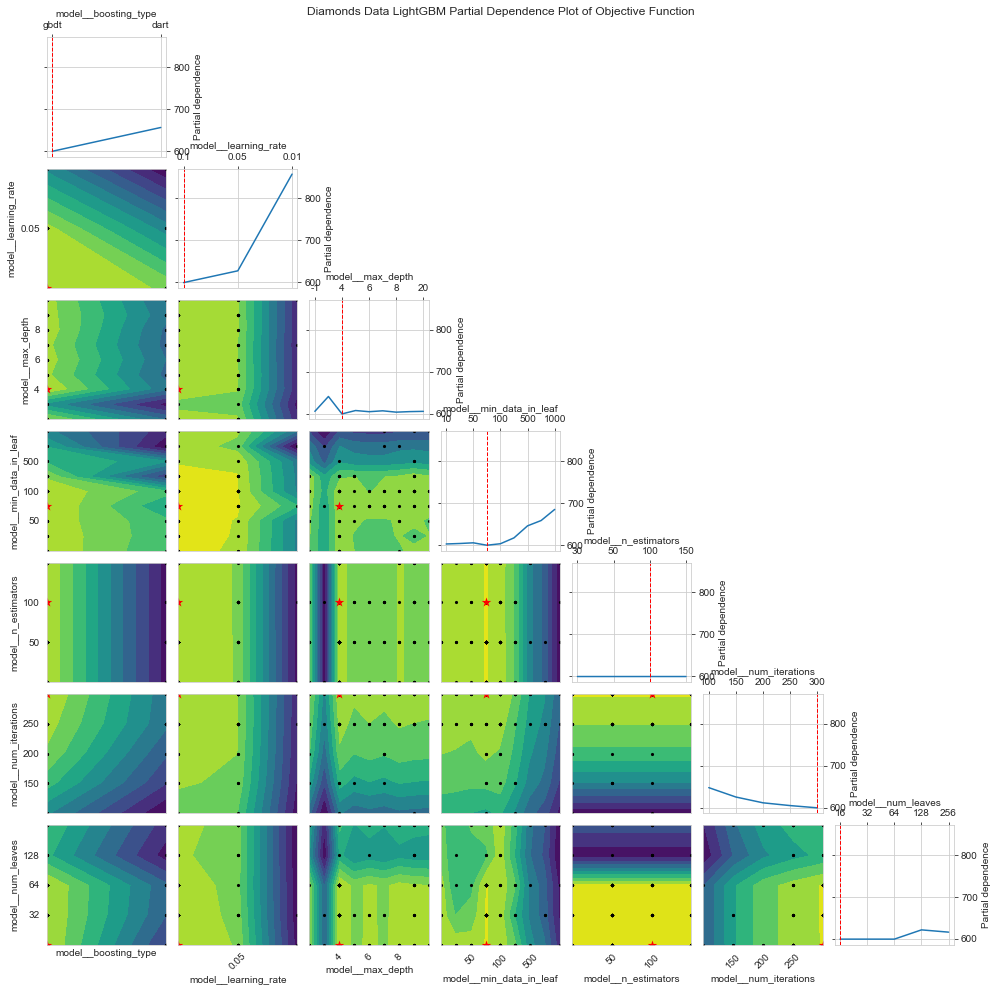

In [266]:
plot_objective_models(model=bayes_search_lgbm, model_name='LightGBM')

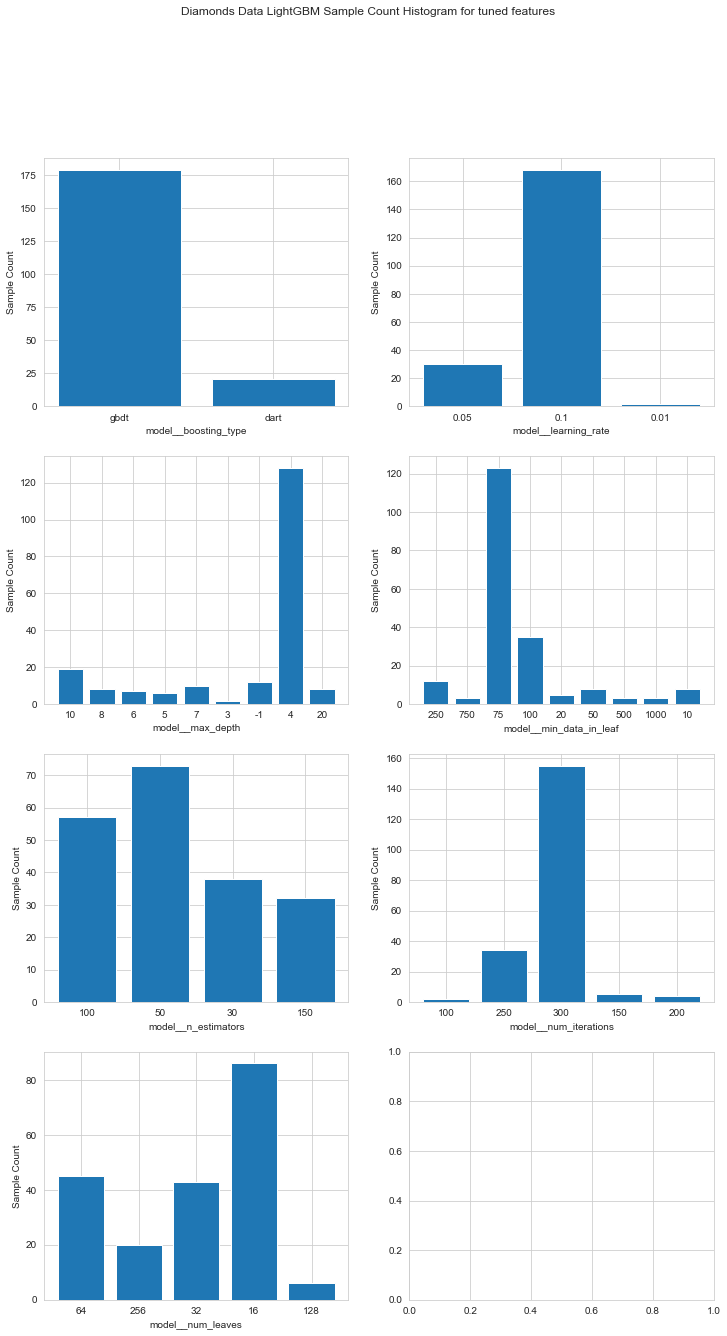

In [267]:
plot_hist_models(model=bayes_search_lgbm, 
                 model_name='LightGBM',
                 num_feats=range(1,8),
                 num_rows=4, num_cols=2, fig_size=(12, 21))

Below tables for each tuned feature shows the mean fit time, mean validation score, mean training score and the RMSE gap between mean train and validation scores:

In [288]:
bayes_results_lgbm_df['RMSE_gap'] = bayes_results_lgbm_df['mean_validation_score']-bayes_results_lgbm_df['mean_train_score']
cols = ['mean_validation_score', 'mean_train_score', 'RMSE_gap', 'mean_fit_time']

for feat in ['param_model__boosting_type',
       'param_model__learning_rate', 'param_model__max_depth',
       'param_model__min_data_in_leaf', 'param_model__n_estimators',
       'param_model__num_iterations', 'param_model__num_leaves',]:
    piv = bayes_results_lgbm_df.groupby(by=[feat])[cols].mean().head(10).T
    display(piv)

param_model__boosting_type        dart        gbdt
mean_validation_score       732.384601  611.090529
mean_train_score            660.391542  497.698208
RMSE_gap                     71.993059  113.392321
mean_fit_time                 9.015170    0.574902

param_model__learning_rate         0.01        0.05        0.10
mean_validation_score       1313.382406  660.143379  609.132233
mean_train_score            1473.259320  524.846458  501.573150
RMSE_gap                    -159.876914  135.296921  107.559083
mean_fit_time                  4.552230    1.253376    1.461431

param_model__max_depth         -1           3           4           5   \
mean_validation_score   619.903682  702.371362  604.561980  678.761426   
mean_train_score        446.765218  613.193459  504.542860  585.237979   
RMSE_gap                173.138464   89.177903  100.019121   93.523447   
mean_fit_time             3.806712    0.405473    0.659794    0.826093   

param_model__max_depth          6           7           8           10  \
mean_validation_score   618.857126  782.929403  630.309871  632.892752   
mean_train_score        484.653455  736.480454  509.251233  495.497381   
RMSE_gap                134.203671   46.448949  121.058637  137.395371   
mean_fit_time             0.555397    2.633360    2.092659    4.347865   

param_model__max_depth          20  
mean_validation_score   654.557147  
mean_train_score        503.734921  
RMSE_gap                150.822226  
mean_fit_time             3.344031

param_model__min_data_in_leaf        10          20          50          75    \
mean_validation_score          625.887256  631.032231  626.692511  607.232678   
mean_train_score               457.509027  459.093484  474.658738  502.773876   
RMSE_gap                       168.378229  171.938746  152.033773  104.458802   
mean_fit_time                    1.207867    1.543826    3.418163    0.552696   

param_model__min_data_in_leaf        100         250         500   \
mean_validation_score          618.406182  662.477765  653.891559   
mean_train_score               492.621715  571.793104  564.410250   
RMSE_gap                       125.784467   90.684661   89.481309   
mean_fit_time                    3.721999    0.973568    5.694160   

param_model__min_data_in_leaf         750         1000  
mean_validation_score          1070.571722  710.841080  
mean_train_score               1191.445502  663.786936  
RMSE_gap                       -120.873780   47.054144  
mean_fit_time                     3.101194    3.726084

param_model__n_estimators         30          50          100         150
mean_validation_score      649.184105  619.245019  619.466426  611.931646
mean_train_score           555.880731  509.105813  497.169168  510.292717
RMSE_gap                    93.303374  110.139206  122.297257  101.638929
mean_fit_time                1.723009    1.594337    1.052512    1.574125

param_model__num_iterations         100         150         200         250  \
mean_validation_score        661.997451  715.500251  685.856882  671.042687   
mean_train_score             545.298755  622.184556  577.071667  567.586741   
RMSE_gap                     116.698696   93.315695  108.785216  103.455946   
mean_fit_time                  0.292926    1.286618    3.212991    4.631984   

param_model__num_iterations         300  
mean_validation_score        608.418750  
mean_train_score             497.731906  
RMSE_gap                     110.686844  
mean_fit_time                  0.741082

param_model__num_leaves         16          32          64          128  \
mean_validation_score    620.299137  642.961006  609.813652  626.046208   
mean_train_score         513.496141  553.977861  503.870603  460.903003   
RMSE_gap                 106.802996   88.983146  105.943049  165.143205   
mean_fit_time              0.926784    0.851639    1.665036    2.708304   

param_model__num_leaves         256  
mean_validation_score    628.717030  
mean_train_score         476.744514  
RMSE_gap                 151.972516  
mean_fit_time              4.236288

From the above plots and tables, we can interpret find hyperparameters that effect the results most, helps/hurts the fitting efficiency and the ones helps with the regularization. 

For the LightGBM, according to the Partial Dependence Plot and above tables, Learning rate, boosting_type, min_data_in_leaf,  num_iterations helps with the performance of the model. Num_leaves, min_data_in_leaf, max_depth seems to help with regularization. Learning rate, num_iterations and max_depth again does effect the fitting efficiency, small learning rate combined with high number of iterations and big max_depth value increase the fitting time of the model (mean fit time in the above tables). The boosting_type dart is also have way bigger fitting time compared to gbdt. 

##### __CatBoost__

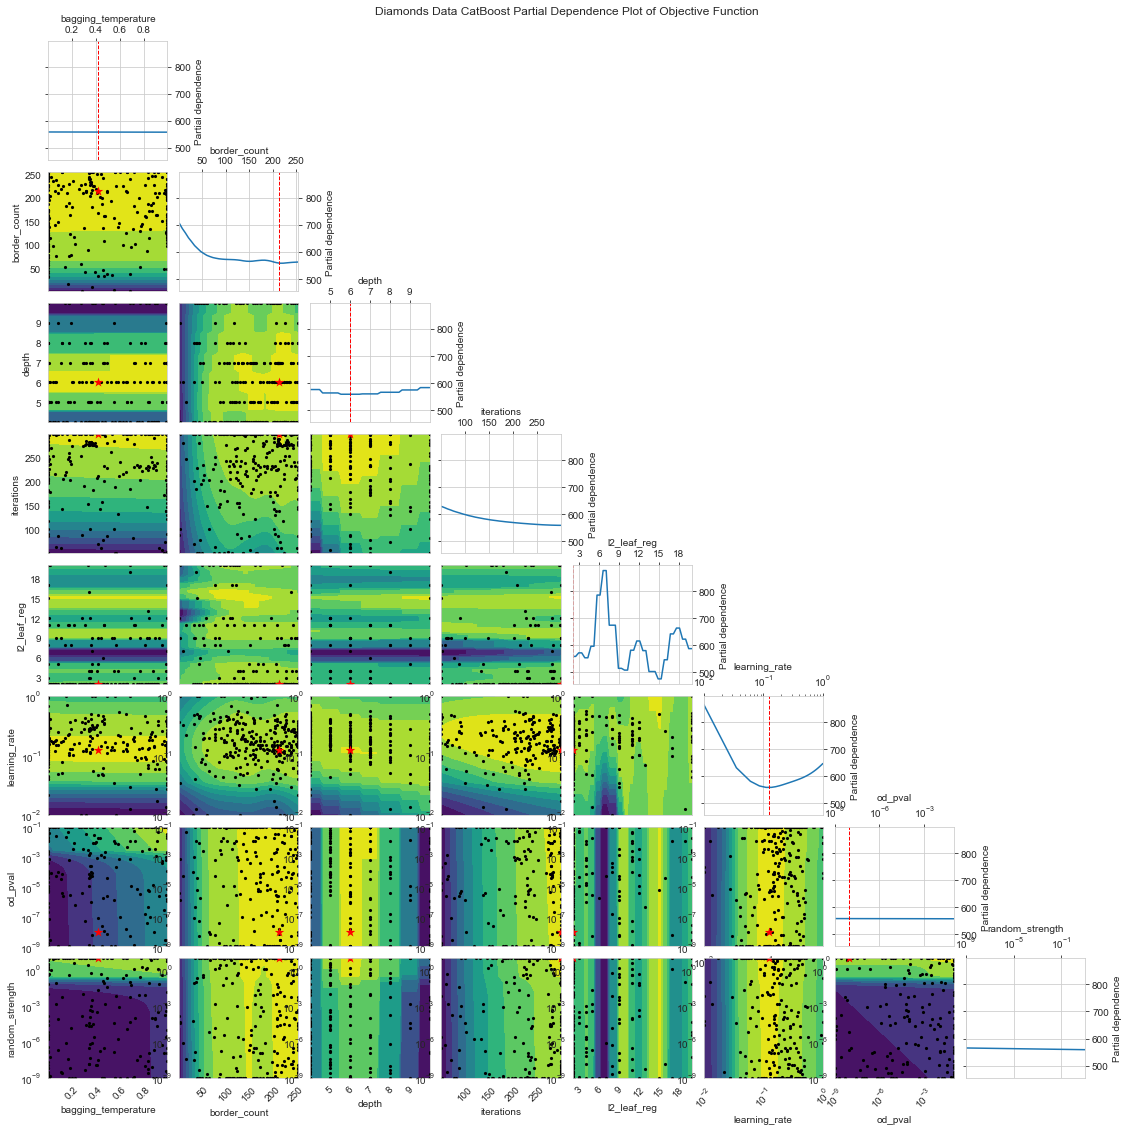

In [268]:
plot_objective_models(model=bayes_search_cb, model_name='CatBoost')

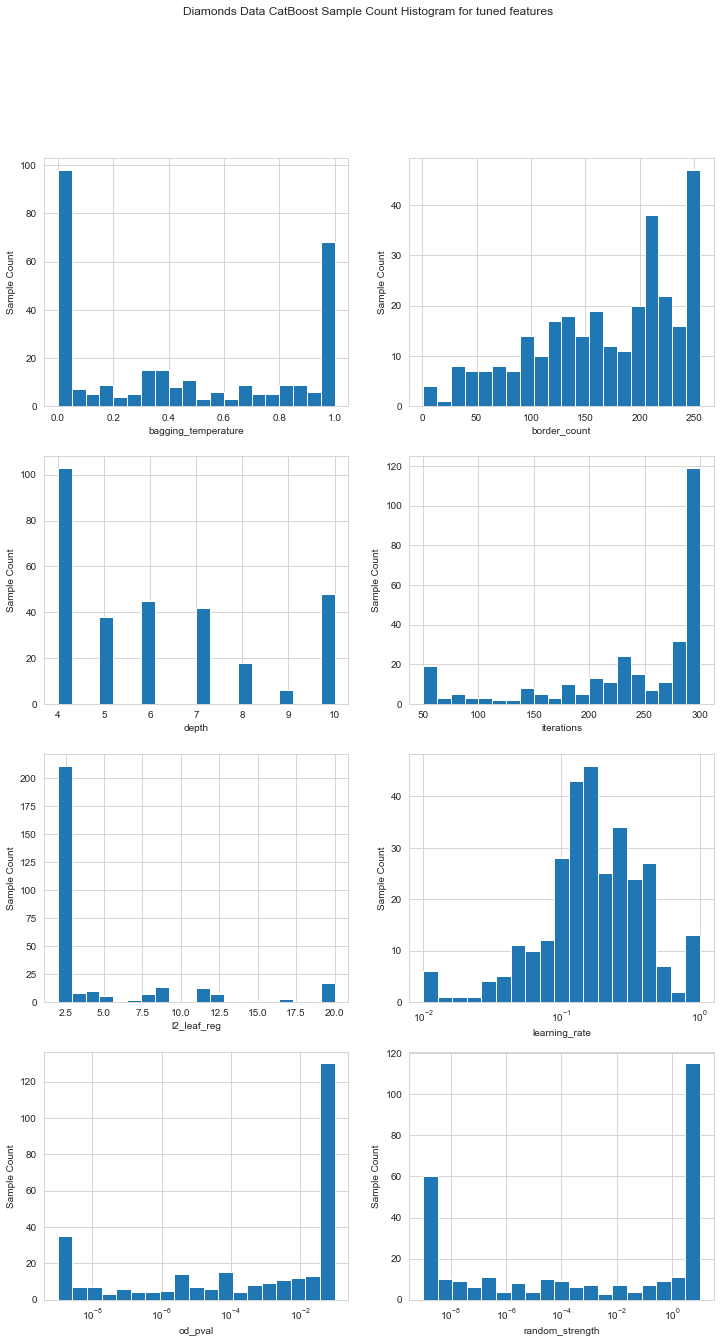

In [269]:
plot_hist_models(model=bayes_search_cb, 
                 model_name='CatBoost',
                 num_feats=range(8),
                 num_rows=4, num_cols=2, fig_size=(12, 21))

Below tables for each tuned feature shows the mean fit time, mean validation score, mean training score and the RMSE gap between mean train and validation scores:

In [289]:
bayes_results_cb_df['RMSE_gap'] = bayes_results_cb_df['mean_validation_score']-bayes_results_cb_df['mean_train_score']
cols = ['mean_validation_score', 'mean_train_score', 'RMSE_gap', 'mean_fit_time']

for feat in ['param_bagging_temperature', 'param_border_count',
       'param_depth', 'param_iterations', 'param_l2_leaf_reg',
       'param_learning_rate', 'param_od_pval', 'param_random_strength']:
    piv = bayes_results_cb_df.groupby(by=[feat])[cols].mean().head(10).T
    display(piv)

param_bagging_temperature    0.000000    0.002968    0.004518    0.006950  \
mean_validation_score      596.420554  576.911417  574.596597  567.890303   
mean_train_score           490.671380  499.741331  443.984078  496.749494   
RMSE_gap                   105.749175   77.170087  130.612520   71.140808   
mean_fit_time                1.467983    1.183442    1.809631    1.119211   

param_bagging_temperature    0.016229    0.016264    0.026538    0.039710  \
mean_validation_score      575.371422  578.230057  568.175920  575.617139   
mean_train_score           449.212034  496.844748  473.947187  507.465929   
RMSE_gap                   126.159388   81.385309   94.228733   68.151210   
mean_fit_time                1.092802    0.680561    4.381694    0.915352   

param_bagging_temperature    0.042568    0.053071  
mean_validation_score      561.070924  559.642755  
mean_train_score           470.670895  476.460018  
RMSE_gap                    90.400029   83.182736  
mean_fit_time                1.169266    1.181843

param_border_count              1            2            3            9   \
mean_validation_score  2437.885042  2155.604170  2050.695108  1113.351649   
mean_train_score       2705.875540  2030.159951  1882.821540   774.600469   
RMSE_gap               -267.990498   125.444219   167.873567   338.751180   
mean_fit_time             0.302329     1.518940     0.804732     1.016317   

param_border_count             16          31          32          34  \
mean_validation_score  868.945692  983.486290  683.633660  674.054715   
mean_train_score       684.835780  919.517794  515.289167  514.836671   
RMSE_gap               184.109911   63.968496  168.344492  159.218044   
mean_fit_time            0.843478    0.858223    1.159559    2.658881   

param_border_count             35          37  
mean_validation_score  654.210713  874.935538  
mean_train_score       569.609654  827.448298  
RMSE_gap                84.601059   47.487241  
mean_fit_time            0.928517    1.262819

param_depth                    4           5           6           7   \
mean_validation_score  619.482407  581.061688  677.234097  577.630664   
mean_train_score       526.896674  485.809802  590.801220  459.122405   
RMSE_gap                92.585733   95.251886   86.432877  118.508259   
mean_fit_time            0.881004    1.270390    1.123163    1.384647   

param_depth                    8           9           10  
mean_validation_score  621.180552  891.826006  621.733797  
mean_train_score       466.948582  760.145866  475.404196  
RMSE_gap               154.231970  131.680140  146.329601  
mean_fit_time            1.486894    2.351749    3.048691

param_iterations               50          52          57          60  \
mean_validation_score  784.127465  628.354904  636.942447  739.782186   
mean_train_score       662.170635  552.337812  565.288087  662.767540   
RMSE_gap               121.956830   76.017092   71.654360   77.014646   
mean_fit_time            0.415664    0.160174    0.201277    0.247884   

param_iterations               61          62          64          69  \
mean_validation_score  611.386375  632.731844  615.897542  682.088667   
mean_train_score       522.973640  551.300124  541.200627  551.531170   
RMSE_gap                88.412735   81.431720   74.696915  130.557497   
mean_fit_time            0.311200    0.649670    0.250633    0.798380   

param_iterations               73          77  
mean_validation_score  602.712813  635.231990  
mean_train_score       491.348203  496.475672  
RMSE_gap               111.364610  138.756318  
mean_fit_time            0.503462    0.659570

param_l2_leaf_reg              2           3           4           5   \
mean_validation_score  592.521556  593.212444  587.557544  698.806326   
mean_train_score       482.540399  483.580004  474.519385  609.794996   
RMSE_gap               109.981157  109.632440  113.038159   89.011330   
mean_fit_time            1.552190    0.922385    0.829635    0.620922   

param_l2_leaf_reg              6           7           8           9   \
mean_validation_score  635.231990  870.853276  850.717300  738.727187   
mean_train_score       496.475672  663.469141  747.746240  610.681058   
RMSE_gap               138.756318  207.384136  102.971060  128.046130   
mean_fit_time            0.659570    0.588245    1.234575    1.877911   

param_l2_leaf_reg              11          12  
mean_validation_score  620.824965  851.370087  
mean_train_score       486.455947  805.707700  
RMSE_gap               134.369017   45.662387  
mean_fit_time            1.480590    1.482583

param_learning_rate       0.010000    0.012573    0.013914    0.017566  \
mean_validation_score  1172.742308  874.935538  929.489008  632.663857   
mean_train_score       1174.963365  827.448298  903.911986  570.690434   
RMSE_gap                 -2.221056   47.487241   25.577022   61.973424   
mean_fit_time             1.634913    1.262819    1.031312    5.734875   

param_learning_rate      0.022048    0.027387    0.027934    0.030159  \
mean_validation_score  731.142892  629.020778  735.845770  609.701538   
mean_train_score       633.231155  521.534205  643.380068  500.774356   
RMSE_gap                97.911737  107.486573   92.465702  108.927182   
mean_fit_time            1.501995    4.283874    0.795100    6.437489   

param_learning_rate      0.032528    0.035221  
mean_validation_score  654.259492  594.356834  
mean_train_score       595.037900  534.476773  
RMSE_gap                59.221592   59.880061  
mean_fit_time            1.446941    2.928060

param_od_pval          1.000000e-09  1.116487e-09  1.170697e-09  1.185287e-09  \
mean_validation_score    584.903536    567.806218    576.528644    570.639234   
mean_train_score         481.655064    484.138349    465.930763    473.850629   
RMSE_gap                 103.248472     83.667870    110.597881     96.788605   
mean_fit_time              1.926178      1.005269      2.044189      0.829658   

param_od_pval          1.281338e-09  1.847439e-09  2.654482e-09  2.655925e-09  \
mean_validation_score    569.995140    622.150930    573.167168    602.712813   
mean_train_score         463.015873    471.792595    499.362146    491.348203   
RMSE_gap                 106.979267    150.358334     73.805022    111.364610   
mean_fit_time              1.397618      0.701155      5.784815      0.503462   

param_od_pval          2.805438e-09  4.801575e-09  
mean_validation_score    578.230057    671.803006  
mean_train_score         496.844748    581.522814  
RMSE_gap                  81.385309     90.280192  
mean_fit_time              0.680561      0.181508

param_random_strength  1.000000e-09  1.179524e-09  1.337562e-09  1.948190e-09  \
mean_validation_score    607.071588    568.576941    575.371422    620.678094   
mean_train_score         474.953623    454.479939    449.212034    445.365418   
RMSE_gap                 132.117965    114.097002    126.159388    175.312676   
mean_fit_time              1.547080      1.115034      1.092802      1.742592   

param_random_strength  1.970483e-09  2.317262e-09  2.657184e-09  2.911235e-09  \
mean_validation_score    576.543032    571.148219    605.680737    731.142892   
mean_train_score         476.682028    490.567075    513.124624    633.231155   
RMSE_gap                  99.861004     80.581144     92.556113     97.911737   
mean_fit_time              0.963859      0.908414      0.997489      1.501995   

param_random_strength  3.064276e-09  3.137981e-09  
mean_validation_score    582.312354    611.386375  
mean_train_score         470.518416    522.973640  
RMSE_gap                 111.793937     88.412735  
mean_fit_time              0.786395      0.311200

From the above plots and tables, we can interpret find hyperparameters that effect the results most, helps/hurts the fitting efficiency and the ones helps with the regularization. 

For CatBoost model, according to the Partial Dependence Plot and above tables, border count, depth, iterations, l2_leaf_reg, learning_rate are thehyperparameters that has the highest effects on model performance. The ones that has most effect is l2_leaf_reg and learning rate. You can observe the changes of RMSE score with the change of these features by looking the diagonal subplots of Partial Dependence plot. Depth, l2_leaf_reg, random_strength all seems to help with regularization. Depth parameter effects the fitting time inversely. Learning rate, iterations again effect the fitting efficiency, small learning rate combined with high number of iterations increase the fitting time of the model. 

## Evaluation

#### Question 25

The two tables below shows the 10-fold avg training and validation RMSE scores for best found model results for each algorithms.

__Diamonds Best Results for Each Model__

In [175]:
# show best model results for each model experiments (modelname, parameters, avg train and test rmse) after 10k cv

diamonds_best_model_results = []
best_res = grid_res_lr_df[grid_res_lr_df.model_name=='Lasso'].sort_values(by=['mean_validation_score']).head(1)
diamonds_best_model_results.append({'model':'Lasso', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )    

best_res = grid_res_lr_df[grid_res_lr_df.model_name=='Ridge'].sort_values(by=['mean_validation_score']).head(1)
diamonds_best_model_results.append({'model':'Ridge', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_poly_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'Polynomial Regression', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = rand_res_nn_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'Neural Network', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_rf_df.sort_values(by='mean_validation_RMSE').head(1)
diamonds_best_model_results.append({'model':'Random Forest', 
                                    'mean_train_score':best_res.mean_train_RMSE.values[0], 
                                    'mean_validation_score':best_res.mean_validation_RMSE.values[0],
                                    'res': best_res} )  

best_res = bayes_results_lgbm_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'LightGBM', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0],
                                    'res': best_res} )  


best_res = bayes_results_cb_df.sort_values(by='mean_validation_score').head(1)
diamonds_best_model_results.append({'model':'CatBoost', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0],
                                    'res': best_res} )  

In [176]:
diamonds_best_df = pd.DataFrame(diamonds_best_model_results)
diamonds_best_df['abs_RMSE_gap'] = abs(diamonds_best_df['mean_validation_score']-diamonds_best_df['mean_train_score'])
diamonds_best_df[['model','mean_train_score', 'mean_validation_score', 'abs_RMSE_gap']]

model  mean_train_score  mean_validation_score  \
0                  Lasso       1206.280597            1205.045051   
1                  Ridge       1206.280597            1205.045051   
2  Polynomial Regression        921.572213             882.226435   
3         Neural Network        595.010078             637.488677   
4          Random Forest        197.555441             715.111659   
5               LightGBM        500.356272             599.345728   
6               CatBoost        475.666327             556.067794   

   abs_RMSE_gap  
0      1.235546  
1      1.235546  
2     39.345778  
3     42.478598  
4    517.556217  
5     98.989456  
6     80.401467

__Gas Best Results for Each Model__

In [177]:
# show best model results for each model experiments (modelname, parameters, avg train and test rmse) after 10k cv

gas_best_model_results = []
best_res = grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Lasso'].sort_values(by=['mean_validation_score']).head(1)
gas_best_model_results.append({'model':'Lasso', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )    

best_res = grid_res_lr_df_gas[grid_res_lr_df_gas.model_name=='Ridge'].sort_values(by=['mean_validation_score']).head(1)
gas_best_model_results.append({'model':'Ridge', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_poly_df_gas.sort_values(by='mean_validation_score').head(1)
gas_best_model_results.append({'model':'Polynomial Regression', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = rand_res_nn_df_gas.sort_values(by='mean_validation_score').head(1)
gas_best_model_results.append({'model':'Neural Network', 
                                    'mean_train_score':best_res.mean_train_score.values[0], 
                                    'mean_validation_score':best_res.mean_validation_score.values[0], 
                                    'res': best_res} )  

best_res = grid_res_rf_df_gas.sort_values(by='mean_validation_RMSE').head(1)
gas_best_model_results.append({'model':'Random Forest', 
                                    'mean_train_score':best_res.mean_train_RMSE.values[0], 
                                    'mean_validation_score':best_res.mean_validation_RMSE.values[0],
                                    'res': best_res} )  


In [178]:
gas_best_df = pd.DataFrame(gas_best_model_results)
gas_best_df['abs_RMSE_gap'] = abs(gas_best_df['mean_validation_score']-gas_best_df['mean_train_score'])
gas_best_df[['model','mean_train_score', 'mean_validation_score', 'abs_RMSE_gap']]

model  mean_train_score  mean_validation_score  \
0                  Lasso          8.036236               8.802989   
1                  Ridge          8.094992               8.761643   
2  Polynomial Regression          5.719778               7.155798   
3         Neural Network          5.034472               6.334995   
4          Random Forest          1.342304               6.762084   

   abs_RMSE_gap  
0      0.766753  
1      0.666650  
2      1.436020  
3      1.300523  
4      5.419779

__Why is the training RMSE different from that of validation set?__

Having a higher train validation gap, when train error is low and validation error is high, generally refers to overfitting (model starts to memorize/fitt training data very well that it cannot perform well/generalize on unseen test data).  
When both train and validation errors are high and gap is small, this would mean the model underfits the data, which is model cannot learn enough from data to generalize.

Diamonds Data:
For the Linear Reg. without Regularization, Lasso and Ridge Regression the train and validation scores are very similar but very high, this might suggest that they are underfitting the dataset we have. The training RMSE and validation RMSE gap is the biggest in Random Forest part, training error is very low and validation is high, suggesting overfitting. For LightGBM and CatBoost are the model types that have higher RMSE gaps, after Random Forest. Again, we can see that train score are lower and the validation scores are bit higher. This shows that the model fit better to the training data and not as much to the test data. For Polynomial Regression we see that the training score is higher than validation, this is generally not an expected behavior but might be because the regularization value chosen is big on the best model. Neural Network gap is also low, which shows model fit well to both train and validation sets.
The best validation results found in all model belongs to CatBoost with 556 RMSE score and the RMSe gap is 80.4, which is acceptable.

Gas Data:

We see similar results on gas data as well, Lasso and Ridge have high train and validation scores, with little gap, referring to underfit. The models cannot fit the data very well and hypothesis space used is not enough to capture the variability in the data. Random Forest looks like overfitting again with very high gap and low train, high validation result. Polynomiald Regression and Neural Network train and validation scores are lower and the gap between them is not much, showing these models are well fit and generalizing well in the unseen test data. The best model found for gas data is neural network.



#### Question 26

__Explain what OOB error and $R^2$ score means.__

OOB Error: Out of bag error, measures the prediction error of Random Forest. 
In Random Forest we use bootsrap samples for training the trees. Then the out of bag samples are the samples that are not selected, left out ones from bootstrap samples. The out of bag samples won't be used in training and therefore can be used as unseen samples and measure model performance for the trees where they are not used as training samples. OOB score is than computed as the number of correctly predicted samples from the out of bag sample, in regression case the oob score is computed using the R^2 score between true values and predicted values for OOB samples. The OOB error is calculated as the average error for predictions from the trees that do not contain in their respective bootstrap sample (oob samples are used).

$R^2$ score:  indicates whether the model is a good fit for the data by measuring the proportion of the variance for target variable explained by the feature variables. $R^2 = 1- (RSS / TSS)$ RSS: sum of squares of residuals, and TSS is total sum of squares. The R^2 value is between 0 and 1, 1 means the model fit data perfectly and 100% of the variance in the target variable explained by the features used in the model. 



##### __Diamonds Data__

In [181]:
rf_best_model = grid_search_rf.best_estimator_['model']
print(f'Best RF Model OOB Score: {rf_best_model.oob_score_}')
print(rf_best_model.oob_prediction_)
print('\nBest RF Model Feature Importances:')
                            
for i, imp in enumerate(rf_best_model.feature_importances_):
    print(f'{X_diamonds.columns[i]} feature importance:{imp}')

Best RF Model OOB Score: 0.981448128437458
[ 473.22222222  388.26666667  430.97368421 ... 2643.73809524 2940.55263158
 2779.66666667]

Best RF Model Feature Importances:
carat feature importance:0.30199465230227157
depth feature importance:0.005615268543312274
table feature importance:0.004346108749685826
x feature importance:0.19090287772735992
y feature importance:0.2554629994561144
z feature importance:0.14922971129722173
cut feature importance:0.003289634910874443
color feature importance:0.031206885821142057
clarity feature importance:0.057951861192017756


__Best RF Model Mean Test and Train RMSE and R2 scores after 10-fold CV:__

In [182]:
cols = ['mean_train_RMSE','mean_validation_RMSE', 'mean_train_R2', 'mean_validation_R2']
grid_res_rf_df[cols].sort_values(by='mean_validation_RMSE').head(1)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2
194       197.555441            715.111659        0.99751            0.644635

For best RF model diamond data, OOB score for 0.98. In Regression case R^2 scores are used to calculate OOB score. 0.98 OOB score is a good result.
Avg. validation R^2 is 0.644 which is not very good.

##### __Gas Data__

In [183]:
rf_best_model_gas = grid_search_rf_gas.best_estimator_['model']
print(f'Best RF Model OOB Score: {rf_best_model_gas.oob_score_}')
print(rf_best_model_gas.oob_prediction_)
print('\nBest RF Model Feature Importances:')
                            
for i, imp in enumerate(rf_best_model_gas.feature_importances_):
    print(f'{X_gas.columns[i]} feature importance:{imp}')

Best RF Model OOB Score: 0.9024957564053923
[82.41471831 82.39423288 81.85991228 ... 89.10917722 65.38696364
 70.00585   ]

Best RF Model Feature Importances:
AT feature importance:0.3010705060339823
AP feature importance:0.04480777238527264
AH feature importance:0.0405105496218159
AFDP feature importance:0.0819215110852701
GTEP feature importance:0.0800383875929842
TIT feature importance:0.12693861634272424
TAT feature importance:0.07691051650405482
TEY feature importance:0.06028978245172857
CDP feature importance:0.048490805350535224
year feature importance:0.13902155263163204


__Best RF Model Mean Test and Train RMSE and R2 scores after 10-fold CV:__

In [184]:
cols = ['mean_train_RMSE','mean_validation_RMSE', 'mean_train_R2', 'mean_validation_R2']
grid_res_rf_df_gas[cols].sort_values(by='mean_validation_RMSE').head(1)

mean_train_RMSE  mean_validation_RMSE  mean_train_R2  mean_validation_R2
197         1.342304              6.762084       0.986713            0.496042

For best RF model gas data, OOB score for 0.90 is a good result. 
Avg. validation R^2 is 0.49 is not very good.